# The Wilson-Cowan model


In [2]:
# change to the root directory of the project
import os
if os.getcwd().split("/")[-1] == "examples":
    os.chdir('..')
# get the current directory
cwd = os.getcwd()


# Print the current working directory
print("Current working directory: {0}".format(cwd))

Current working directory: /Users/masha/Documents/Uni/Thesis/neurolib


In [3]:
from neurolib.models.wc import WCModel
# Some useful functions are provided here
import neurolib.utils.functions as func
import neurolib.utils.stimulus as stim
import numpy as np
import scipy
import math

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import glob

from neurolib.models.wc import WCModel

import neurolib.utils.loadData as ld
import neurolib.utils.functions as func

# a nice color map
plt.rcParams['image.cmap'] = 'plasma'

In [74]:
def optimal_control(wc, exc_exp, inh_exp, exc_stimulus, inh_stimulus, exc_init=None, inh_init=None, n_iter = 5000, plot_freq = 200, w = [0,0], a = 0, debug = False):
    #h = (xn-x0)/n_step
    #times = np.arange(0, xn+h, h)
    times = range(int(wc.params['duration']/wc.params['dt']))
    #print(times)
    #u_i = stim.StepInput(step_size=0,  start=0.1, end=0.2, n=1).to_model(wc)
    #print("u_i", u_i)
    #u_e = stim.StepInput(step_size=0,  start=0.1, end=0.2, n=1).to_model(wc)
    #u_i = stimulus
    u_e = exc_stimulus
    u_i = inh_stimulus
    grad = [0,0]
    
    if(exc_init is not None):
        wc.params["exc_init"] = [[exc_init]]
    if(inh_init is not None):
        wc.params["inh_init"] =[[inh_init]]
    
    small_step_size_counter = 0

    for l in range(n_iter):
        
        step_size_adj = 10 #0.005
        

        wc.params["control_term_E"] = u_e
        wc.params["control_term_I"] = u_i

        
        wc.run()
        #print("check", wc.brackets_E)
        ex = wc.exc
        inh = wc.inh
        
        if(debug):
            print(np.shape(ex))
            print(int(wc.params['duration']/wc.params['dt']))
        if (l%plot_freq==0):
            #print(np.linalg.norm(step_size_adj*np.array(grad[0])))
            #print(np.linalg.norm(step_size_adj*np.array(grad[1])))
            print("___")
            print("iteration:", l)
            plt.figure(figsize = (20, 6))
            #print(wc.t)
            #print(ex[0].tolist())
            plt.plot(wc.t, exc_exp.T, '--', c = 'r', label="exc_target")
            plt.plot(wc.t, ex[0].tolist(), c='r', lw = 2, label="exc")
            plt.plot(wc.t, u_e.T, ':', c='r', lw = 2,label="stimulus")
            plt.axvspan((a+1)*wc.params['dt'], wc.params['duration'], color='y', alpha=0.2, lw=0)
            #plt.legend()
            #plt.show()
            #plt.plot(wc.t, u_e.T, c='r', lw = 2,label="stimulus")
            #plt.show()
            
            #plt.figure(figsize = (20, 6))
            plt.plot(wc.t, inh_exp.T, '--', c = 'blue',label="inh_target")
            plt.plot(wc.t, inh[0].tolist(), c='blue', lw = 2, label="inh")
            plt.plot(wc.t, u_i.T, ':', c='blue', lw = 2,label="stimulus")
            #plt.axvspan((a+1)*wc.params['dt'], wc.params['duration'], color='y', alpha=0.2, lw=0)
            plt.legend()
            plt.show()
            #plt.plot(wc.t, u_i.T, c='r', lw = 2,label="stimulus")
            #plt.show()
        
        
        
        lambdas = euler_backwards(wc, exc_exp, inh_exp, wc.params['dt'], int(math.ceil(wc.params['duration']/wc.params['dt'])), a, debug)
        if debug:
            print("lambdas", lambdas)
            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, [x[0] for x in lambdas], c='blue', lw = 2, label="lambdas")
            plt.legend()
            plt.show()
        
        #w = [0,0]
        
        
        grad = grad_f(w, u_e,u_i, lambdas, times, a)
        
        if True:
            if (l%plot_freq==0):
                print("gradient:")
                plt.figure(figsize = (20, 6))
                plt.plot(wc.t, np.array(grad[0]), c='red', lw = 2, label="grad")
                plt.legend()
                plt.show()
        
        #print("grad", np.array(grad[0]))
        #print("lambdas", lambdas)
        
        
        step_size_adj = bisection(wc, step_size_adj,u_e,u_i,grad, times, exc_exp, inh_exp, w, debug, a)
        
        
        
        if(step_size_adj < 10**(-17)):
            small_step_size_counter +=1
        else:
            small_step_size_counter = 0
            
        if(small_step_size_counter > 50):
            #print("exit early")
            
            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, exc_exp.T, '--', c = 'r', label="exc_target")
            plt.plot(wc.t, ex[0].tolist(), c='r', lw = 2, label="exc")
            plt.plot(wc.t, u_e.T, ':', c='r', lw = 2,label="stimulus")
            plt.axvspan((a+1)*wc.params['dt'], wc.params['duration'], color='y', alpha=0.2, lw=0)

            plt.plot(wc.t, inh_exp.T, '--', c = 'blue',label="inh_target")
            plt.plot(wc.t, inh[0].tolist(), c='blue', lw = 2, label="inh")
            plt.plot(wc.t, u_i.T, ':', c='blue', lw = 2,label="stimulus")
            plt.legend()
            plt.show()
            return u_e, u_i
        #if(l == 0):
        #    step_size_adj = 0.1
            
        if debug:
            print("step", step_size_adj)
            print("step_new", step_size_adj*np.array(grad[0]))

        u_e = u_e-step_size_adj*np.array(grad[0])
        u_i = u_i-step_size_adj*np.array(grad[1])
        
        eps_u = 0#10**(-7)
        
        
        if np.linalg.norm(step_size_adj*np.array(grad[0])) < eps_u and np.linalg.norm(step_size_adj*np.array(grad[1])) < eps_u:
            print("iteration:", l)
            print(np.linalg.norm(step_size_adj*np.array(grad[0])))
            print(np.linalg.norm(step_size_adj*np.array(grad[1])))
            plt.figure(figsize = (20, 6))
            plt.plot(wc.t, exc_exp.T, c = 'blue',label="exc_target")
            plt.plot(wc.t, ex[0].tolist(), c='k', lw = 2, label="exc")
            plt.plot(wc.t, u_e.T, c='r', lw = 2,label="stimulus")
            plt.axvspan(b*wc.params['dt'], wc.params['duration'], color='y', alpha=0.2, lw=0)
            plt.legend()
            plt.show()
            break
        
    cost = cost_f(w, ex[0], exc_exp, inh[0], inh_exp, u_e, u_i, times, a)
    print("cost", cost)
            
    return u_e, u_i

            
            

In [75]:
def bisection(model, step_size, u_e, u_i, grad, times, exc_exp, inh_exp, w, debug = False, b = 0):
    cost_temp = cost_f(w, model.exc[0], exc_exp, model.inh[0], inh_exp,  u_e, u_i, times, b)
    #print("c_t", cost_temp)
    while step_size > 10*(-8):

        u_e_1 = u_e-step_size*np.array(grad[0])
        u_i_1 = u_i-step_size*np.array(grad[1])

        model.params["control_term_E"] = u_e_1
        model.params["control_term_I"] = u_i_1


        model.run()
        ex = model.exc
        inh = model.inh
        
        if debug:
            #print("step: ", step_size)
            plt.figure(figsize = (8, 5))
            plt.plot(model.t, exc_exp.T,c = 'blue', label="exc_target")
            plt.plot(model.t, ex[0].tolist(), c='k', lw = 2, label="exc")
            plt.plot(model.t, u_e_1.T, c='r', lw = 2, label="stimulus")
            plt.legend()
            plt.show()

        cost = cost_f(w, ex[0], exc_exp, inh[0], inh_exp, u_e_1, u_i_1, times, b)
        if debug:
            print("cost", cost)
            print("step_size", step_size)
        #step_size = step_size/2
        #cost_temp = cost
        
        if(cost>cost_temp):
            step_size = step_size/2
            #cost_temp = cost.copy()
            #print("loop_cost", cost)
        else:
            #print("cost", cost)
            #print("step_size", step_size)
            return step_size
    
    print("zero step size")
    return 0
        

def cost_f(w, x, x_, y,y_,u_exc, u_inh, times, b = 0):
    
    #return np.sum(1/2*(x_-x)**2) 
    x_new = x[b:]
    x_new_ = x_[b:]
    y_new = y[b:]
    y_new_ = y_[b:]
    times_new = times[b:]
    return scipy.integrate.simps(0.5*((x_new_-x_new)**2 + (y_new_-y_new)**2),times_new) \
            + w[0] * ((np.sqrt(scipy.integrate.simps(u_exc**2, times))) \
             + np.sqrt(scipy.integrate.simps(u_inh**2, times))) \
                + w[1] * 0.5*(scipy.integrate.simps(u_inh**2 + u_exc**2, times))
    #return  0.3 * (np.sqrt(scipy.integrate.simps(u_exc**2, times)) \
    #        + np.sqrt(scipy.integrate.simps(u_inh**2, times)) \
    #        + 0.5 * scipy.integrate.simps(u_exc**2 + u_inh**2, times)) \
    #        + scipy.integrate.simps((x-x_)**2,times)

In [8]:
def S_E(x, model):
    a_exc = model.params["a_exc"]
    mu_exc = model.params["mu_exc"]
    return 1.0 / (1.0 + np.exp(-a_exc * (x - mu_exc)))
    #return 1.0/(np.exp(-a_exc*(x-mu_exc))+1.0)
    

def S_I(x, model):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    #return 1.0/(np.exp(-a_inh*(x-mu_inh))+1.0)
    return 1.0 / (1.0 + np.exp(-a_inh * (x - mu_inh)))

def dh1_dE(model, i):
    a_exc = model.params["a_exc"]
    C_EE = model.params["c_excexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E[0][i]
    E_j = model.exc[0][i]

    return -1-S_E(brackets_E, model)+(a_exc*np.exp(-a_exc * ( brackets_E - mu_exc)))*(S_E(brackets_E, model)**2)*C_EE*(1-E_j)
    #return -1-S_E(brackets_E, model)+(a_exc*np.exp(-a_exc*(brackets_E - mu_exc))/(1 + np.exp(-a_exc*(brackets_E - mu_exc)))**2)*C_EE*(1-E_j)
    #return -1

def dh2_dI(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_II = model.params["c_inhinh"]
    brackets_I = model.brackets_I[0][i]
    I_j = model.inh[0][i]
    #return -1-S_I(brackets_I, model)+(a_inh * np.exp(-a_inh *(brackets_I - mu_inh))/(1 + np.exp(-a_inh *(brackets_I - mu_inh)))**2)*(-C_II)*(1-I_j)
    return -1-S_I(brackets_I, model)+(a_inh*np.exp(-a_inh * (brackets_I - mu_inh)))*(S_I(brackets_I, model)**2)*(-C_II)*(1-I_j)
    #return -1
def dh1_dI(model, i):
    a_exc = model.params["a_exc"]
    C_IE = model.params["c_inhexc"]
    mu_exc = model.params["mu_exc"]
    brackets_E = model.brackets_E[0][i]
    E_j = model.exc[0][i]
    #return 0 
    #return (1-E_j)*(a_exc*np.exp(-a_exc*(brackets_E - mu_exc))/(1 + np.exp(-a_exc*(brackets_E - mu_exc)))**2)*(-C_IE)
    return (1-E_j)*(a_exc*np.exp(-a_exc * (brackets_E - mu_exc)))*(S_E(brackets_E, model)**2)*(-C_IE)

def dh2_dE(model, i):
    a_inh = model.params["a_inh"]
    mu_inh = model.params["mu_inh"]
    C_EI = model.params["c_excinh"]
    brackets_I = model.brackets_I[0][i]
    I_j = model.inh[0][i]
    #return 0 
    return (1-I_j)*(a_inh*np.exp(-a_inh * (brackets_I - mu_inh)))*(S_I(brackets_I, model)**2)*C_EI
    #return (1-I_j)*(a_inh*np.exp(-a_inh*(brackets_I - mu_inh))/(1 + np.exp(-a_inh*(brackets_I - mu_inh)))**2)*C_EI

    
def lambda_der(model, lambdas, ex_exp, inh_exp, i,a, debug = False):
    
    lambda_ind = i
    i2 = i
    
    
    tauE = model.params["tau_exc"]
    tauI = model.params["tau_inh"]
    
    Dx_doth = np.array([[ -1*tauE, 0], 
                  [0, -1*tauI]])
    
    if(i >= a):
        Dxf = np.array([model.exc[0][i2]-ex_exp[i2], model.inh[0][i2]-inh_exp[i2]])
    else:
        Dxf = np.array([0,0])
    
    Dxh = np.array([[ dh1_dE(model,i2), dh1_dI(model, i2)], 
                  [dh2_dE(model, i2), dh2_dI(model, i2)]])
    if debug:
        #print("a", model.exc[0][i])
        #print("b", ex_exp[i])
        print("Dxh", Dxh)
        print("Dxf", Dxf)
        print("lambdas[i]",lambdas[lambda_ind])
        print("lambdas[i]@Dxh",lambdas[lambda_ind]@Dxh)
        print("Dxf + lambdas[i]@Dxh", Dxf + lambdas[lambda_ind]@Dxh)
        print((Dxf + lambdas[i2]@Dxh)@np.linalg.inv(Dx_doth))
        print("__________________________________")
    
    return (Dxf + lambdas[lambda_ind]@Dxh)@np.linalg.inv(Dx_doth) #i+1 or i????

def euler_backwards(model, ex_exp, inh_exp, step, n, a, debug = False):
     
    lambdas = [[0,0] for i in range(n)]
    
    #inh = wc.inh[0]
    #ex = wc.exc[0]
    if debug:
        print("exc", model.exc[0])
        print("exc_exp", ex_exp)
    
    for i in range(n-2,-1,-1):
        lambdas[i] = lambdas[i+1]-step*lambda_der(model, lambdas, ex_exp, inh_exp, i+1, a, debug) #i+1 or i

    return lambdas

def grad_f(w, u_e, u_i, lambdas, times, a): ##TODO add cost components
    #a = 0
    #if a > 0:
    #    v1 = [0]*a
    #    v1.extend([x[0] for x in lambdas])
    #    v2 = [0]*a
    #    v2.extend([x[1] for x in lambdas])
    #else:
    v1 = [x[0] for x in lambdas]
    v2 = [x[1] for x in lambdas]
    lambda_list = [v1,v2]
    
    
    f_list = [(w[0]*u_e[0]).tolist(), (w[0]*u_i[0]).tolist()]
    
    
    u_e_mul = (np.sqrt(scipy.integrate.simps(u_e[0]**2, times)))
    u_i_mul = (np.sqrt(scipy.integrate.simps(u_i[0]**2, times)))
    if(u_e_mul != 0):
        f_e = [w[1]*u/u_e_mul for u in u_e[0]]
    else:
        f_e = np.zeros(len(u_e[0]))
        
    if(u_i_mul != 0):
        f_i = [w[1]*u/u_i_mul for u in u_i[0]]
    else:
        f_i = np.zeros(len(u_i[0]))
        
        
        
    summed = [[x + y + z for (x, y, z) in zip(f_list[0], lambda_list[0], f_e)],[x + y + z for (x, y, z) in zip(f_list[1], lambda_list[1], f_i)]]

    #summed = [[x + y for (x, y) in zip(f_list[0], lambda_list[0])],[x + y  for (x, y) in zip(f_list[1], lambda_list[1])]]
    return summed
    #return summed
    #return [[x[0] for x in lambdas],[x[1] for x in lambdas]] + [0.3*np.abs(u_e).tolist(), 0.3*np.abs(u_i).tolist()] 
            #+ [(1/np.sqrt(scipy.integrate.simps(u_e**2, times)))*u_e, (1/np.sqrt(scipy.integrate.simps(u_i**2, times)))*u_i]
    

# Better example

In [128]:
def parameters_prep(exc_ext, inh_ext, duration=400, dt = 0.1, stimulus_exc = None, stimulus_inh = None):
    wc_p = WCModel()
    
    """
    if stimulus_exc or stimulus_inh is not provided, then stimulus is set to default stim.StepInput
    """
    
    print("exc_ext, inh_ext", exc_ext, inh_ext)
    
    wc_p.params["dt"] = dt

    wc_p.params['exc_ext'] = exc_ext
    wc_p.params['inh_ext'] = inh_ext
    wc_p.params['duration'] = duration

    stimulus = np.zeros((1,int(duration/wc_p.params["dt"])))
    stimulus[0][50/dt:60/dt] = 1
    stimulus[0][140/dt:150/dt] = -1

    wc_p.params["control_term_E"] = stimulus
    
    wc_p.run()
    
    
    plt.figure(figsize = (20, 6))
    plt.plot(wc_p.t, stimulus.T)
    plt.plot(wc_p.t, wc_p.exc[0].tolist(), c='k', lw = 2)
    plt.show()

    plt.figure(figsize = (20, 6))
    plt.plot(wc_p.t, stimulus.T)
    plt.plot(wc_p.t, wc_p.inh[0].tolist(), c='k', lw = 2)
    plt.show()
    
    target_exc = np.zeros(int(duration/wc_p.params["dt"]))
    target_inh = np.zeros(int(duration/wc_p.params["dt"]))

    target_exc[:] = wc_p.exc[0][1300]
    target_inh[:] = wc_p.inh[0][13000]

    
    exc_init = wc_p.exc[-1][-1]
    inh_init = wc_p.inh[-1][-1]
    
    
    #w_array = np.linspace(0, 1, 15)
    w_array = [1]
    
    wc = WCModel()
    wc.params["dt"] = dt
    for i in w_array:
    
        wc.params['exc_ext'] = exc_ext
        wc.params['inh_ext'] = inh_ext
        wc.params['duration'] = duration
        
        if stimulus_exc is None:
            stimulus_exc = stim.StepInput(step_size=0.5,  start=195, end=203, n=1).to_model(wc)
        if stimulus_inh is None:
            stimulus_inh = stim.StepInput(step_size=-0.5,  start=195, end=203, n=1).to_model(wc)
        stimulus_zeros = np.zeros((1,duration*10))
        
        #print(len(stimulus_exc[0]))
        print("w", i)
        u_e, u_i = optimal_control(wc, target_exc,target_inh, stimulus_exc, stimulus_inh, exc_init, inh_init, n_iter = 400, plot_freq = 100, w = [i,0], a = 0.9*int(duration/wc.params["dt"]), debug = False)
        stimulus_exc = u_e
        stimulus_inh = u_i
    data = [
        target_exc.T,
        wc.exc[0].tolist(),
        u_e.T,
        target_inh.T,
        wc.inh[0].tolist(),
        u_i.T
    ]
    
    filename = str(exc_ext)+"_"+str(inh_ext)+'.npz'
    np.savez(filename, target_exc=target_exc.T, exc = wc.exc[0].tolist(), stimulus_exc = u_e.T,
             target_inh = target_inh.T, inh = wc.inh[0].tolist(), stimulus_inh = u_i.T)
    #np.save(filename, np.asarray(data), allow_pickle=True)


In [125]:
# (exc_ext, inh_ext) tuples

ext_list_full = [(3,3),(3,4),(3,5),(3,6),(3,7),(3,8),(3,9),(4,5),(4,6),(4,7),(4,8),(4,9),(5,6),(5,7),(5,8),(5,9),(6,8),(6,9)]
ext_list = [(5,9)]

for a,b in ext_list:
    print(a,b)

5 9


exc_ext, inh_ext 5 8


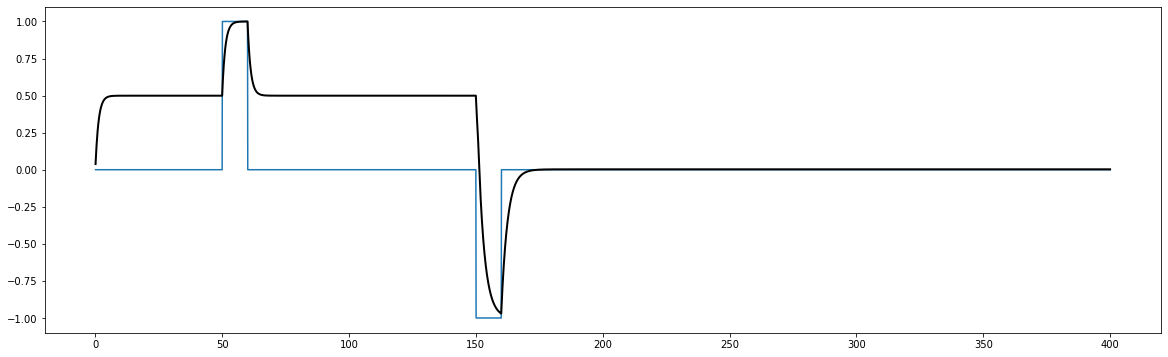

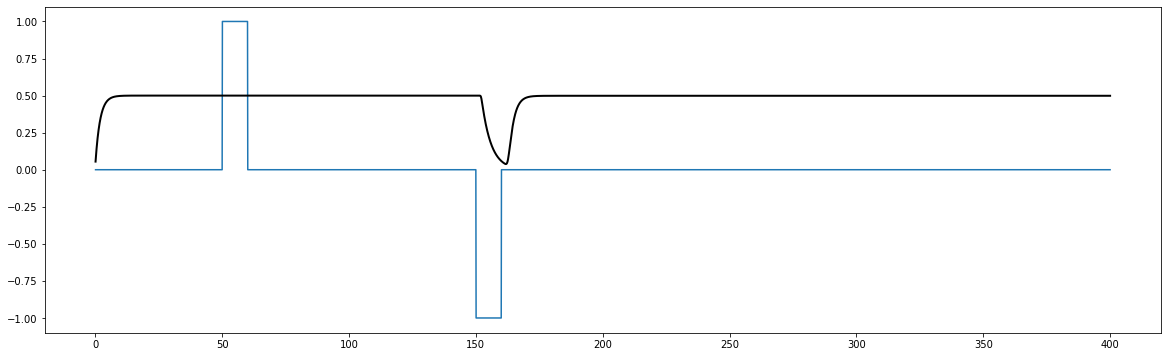

w 1
___
iteration: 0


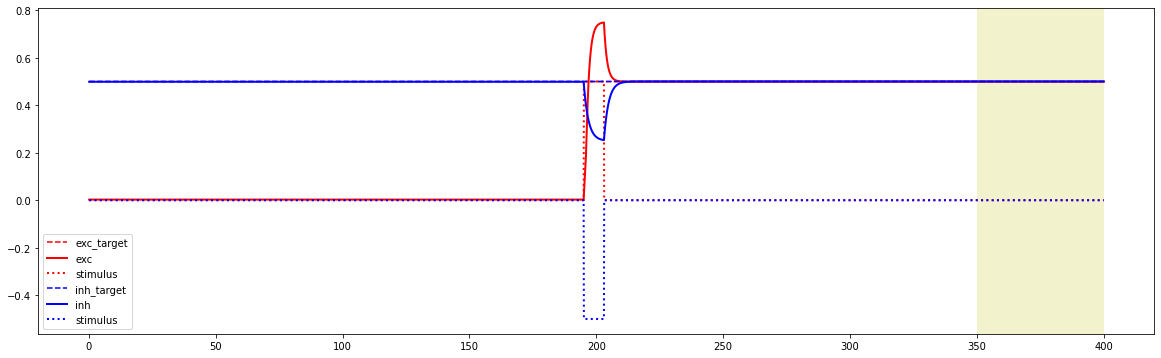

gradient:


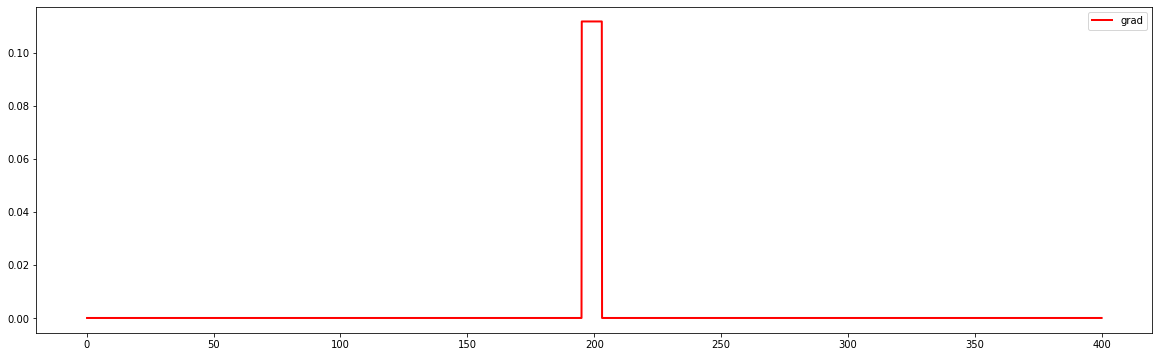

___
iteration: 20


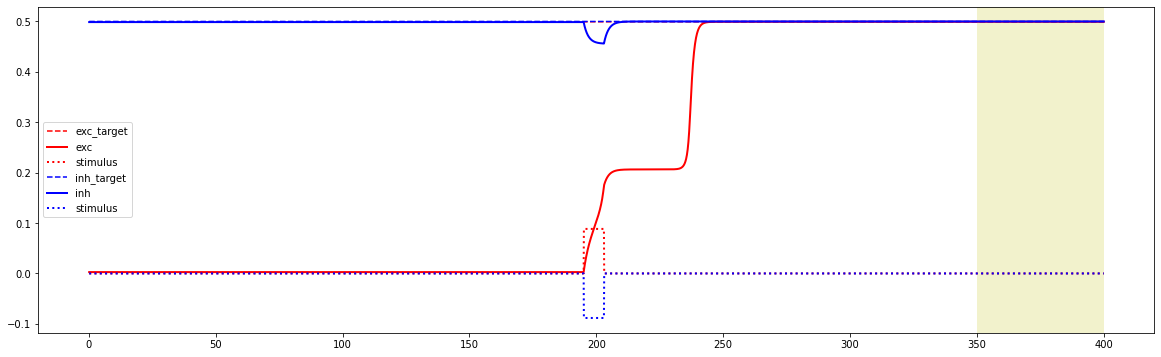

gradient:


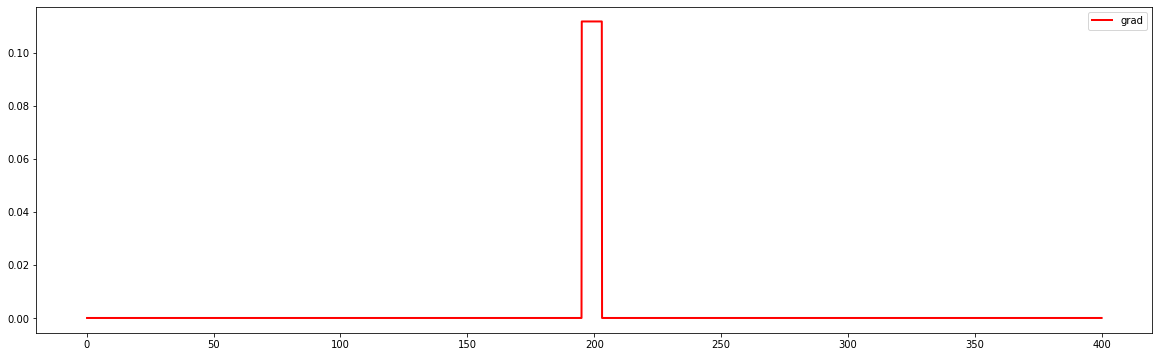

___
iteration: 40


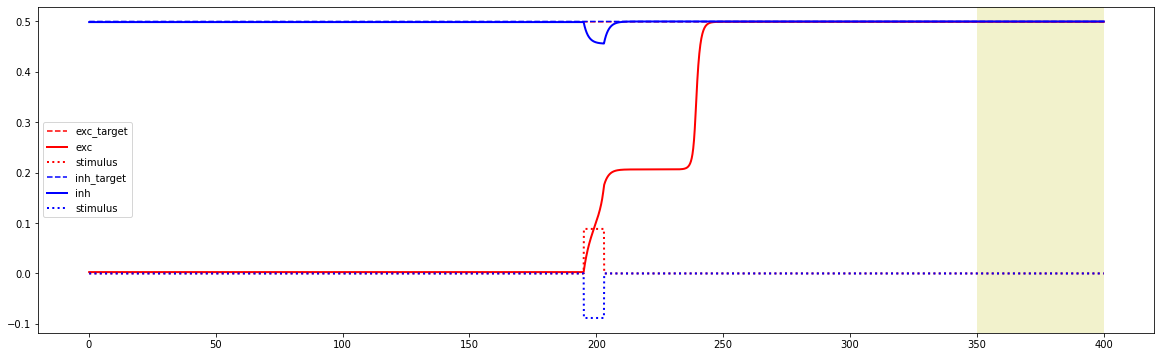

gradient:


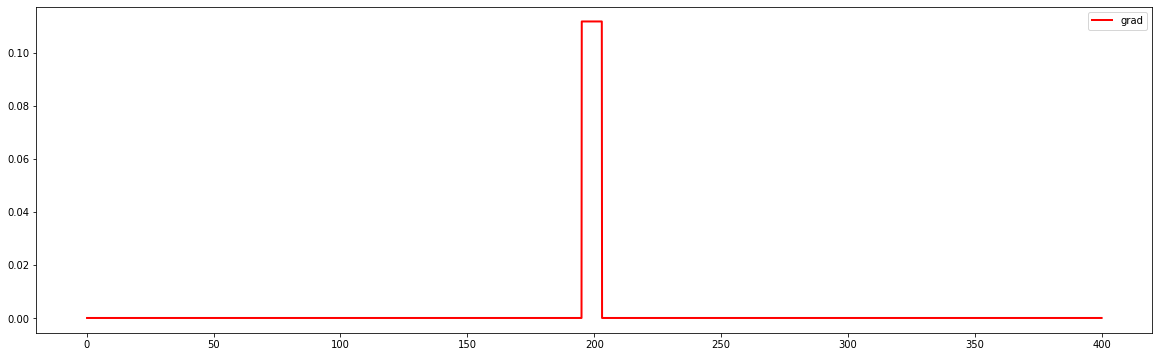

___
iteration: 60


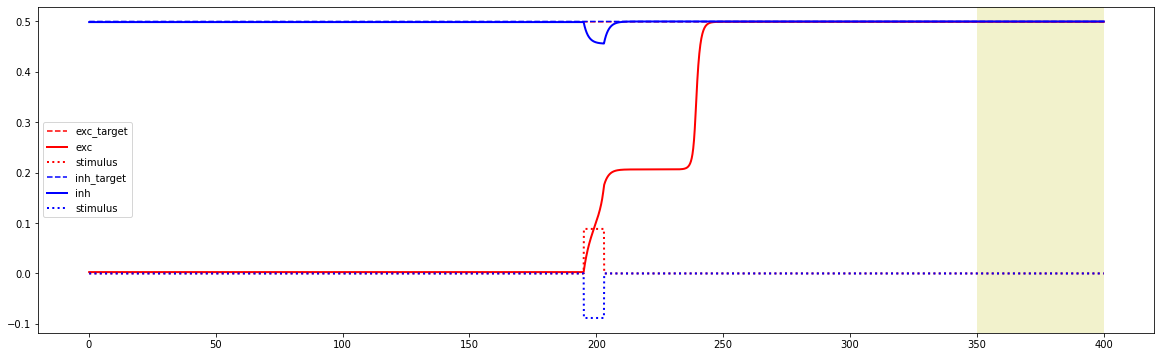

gradient:


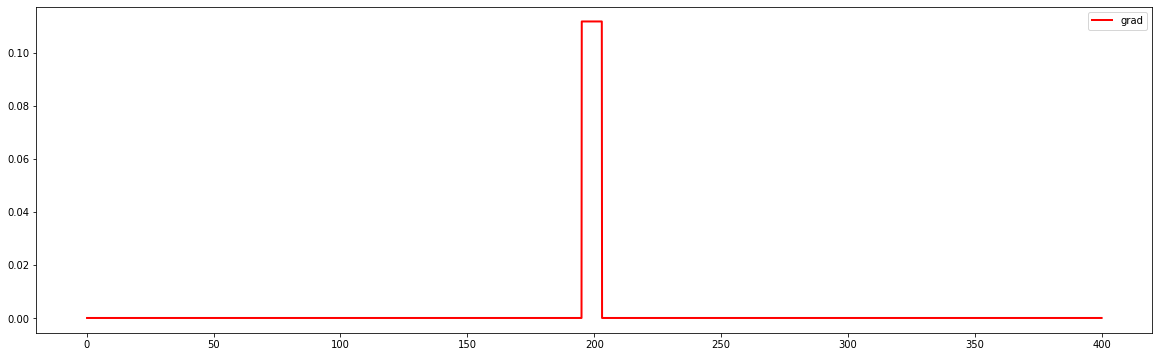

___
iteration: 80


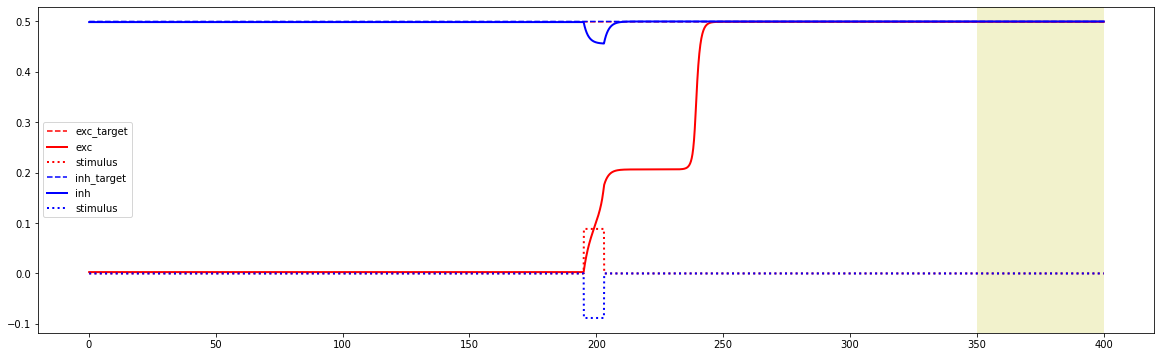

gradient:


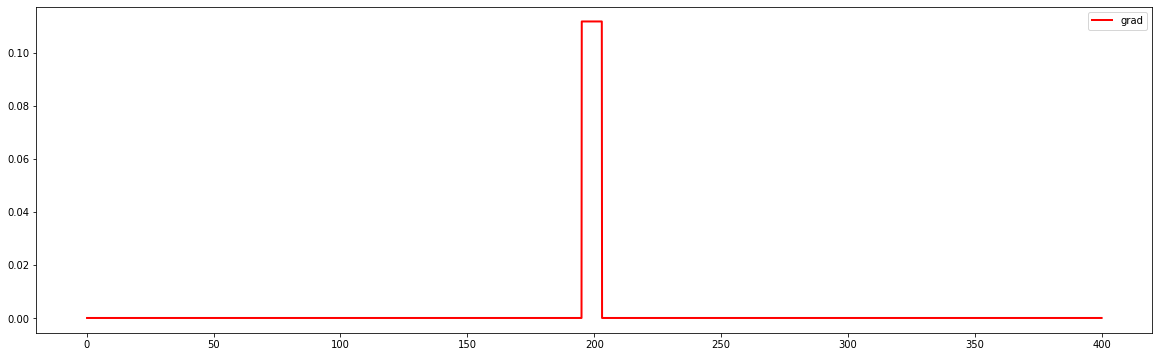

___
iteration: 100


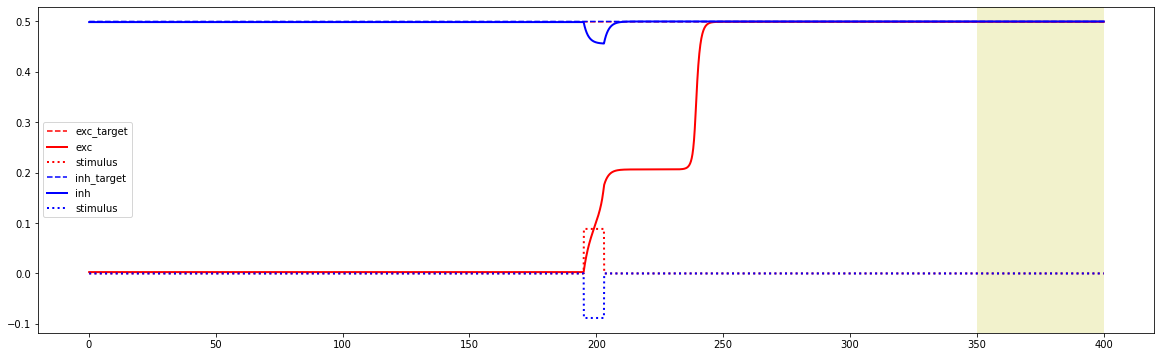

gradient:


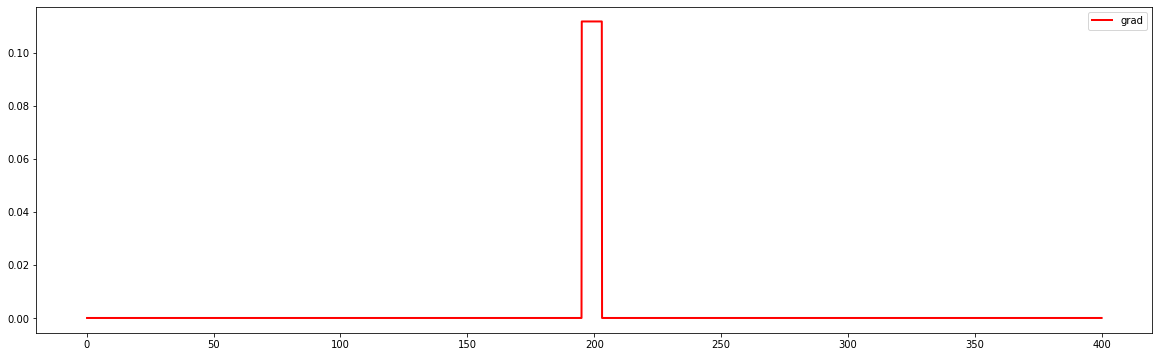

___
iteration: 120


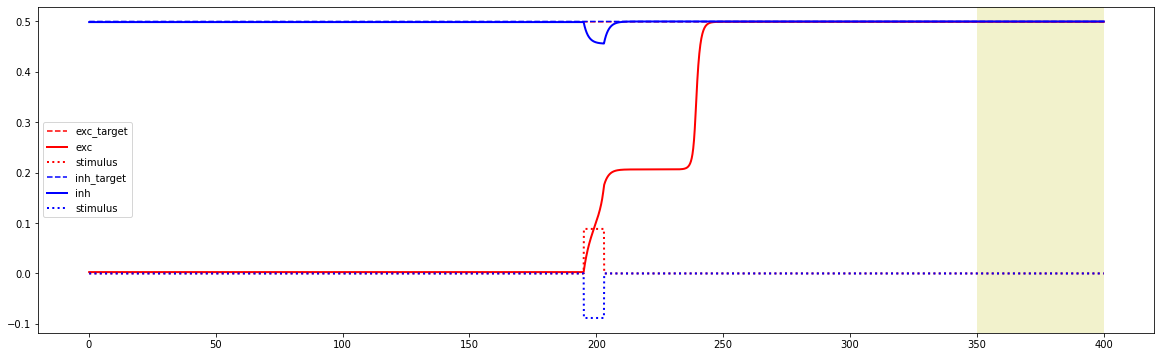

gradient:


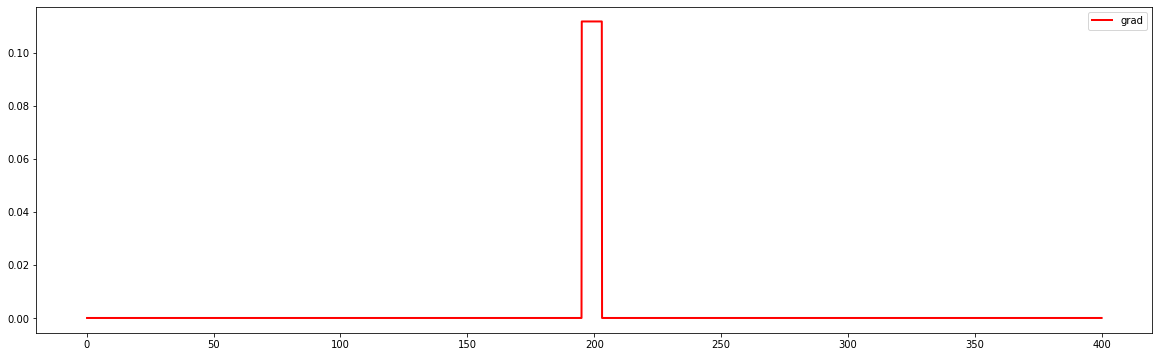

___
iteration: 140


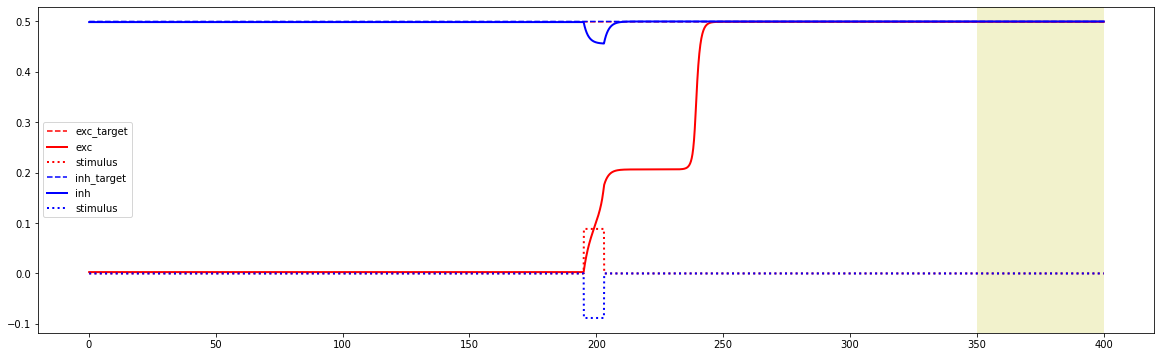

gradient:


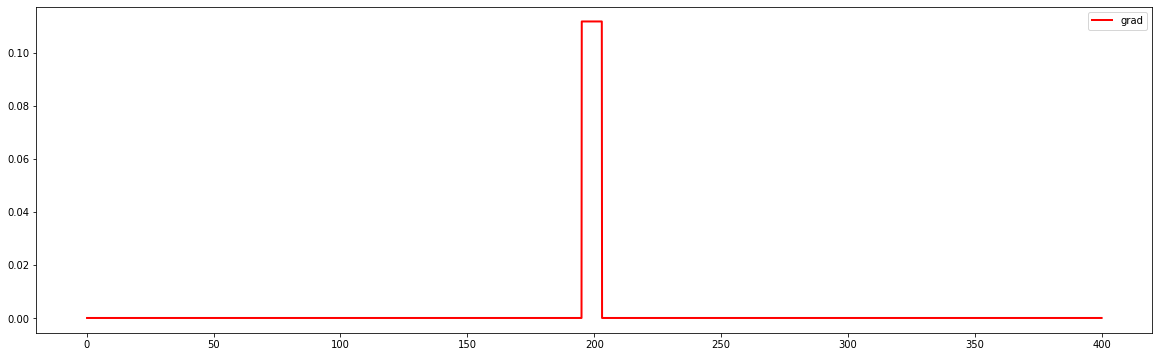

___
iteration: 160


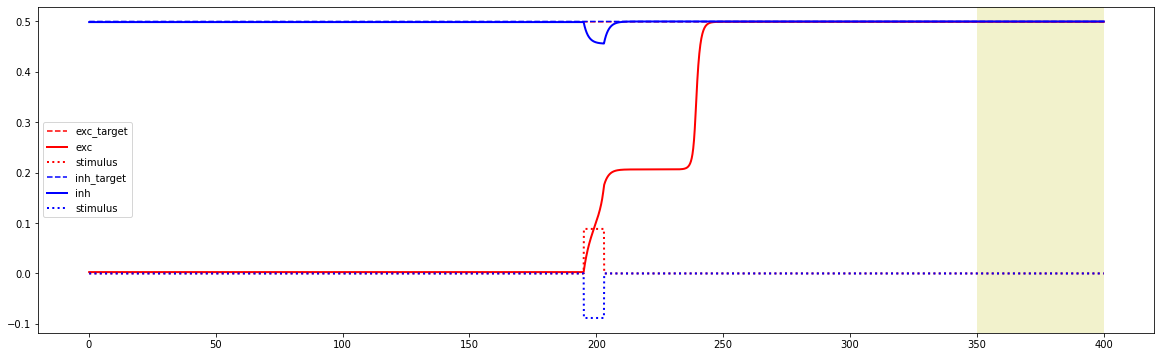

gradient:


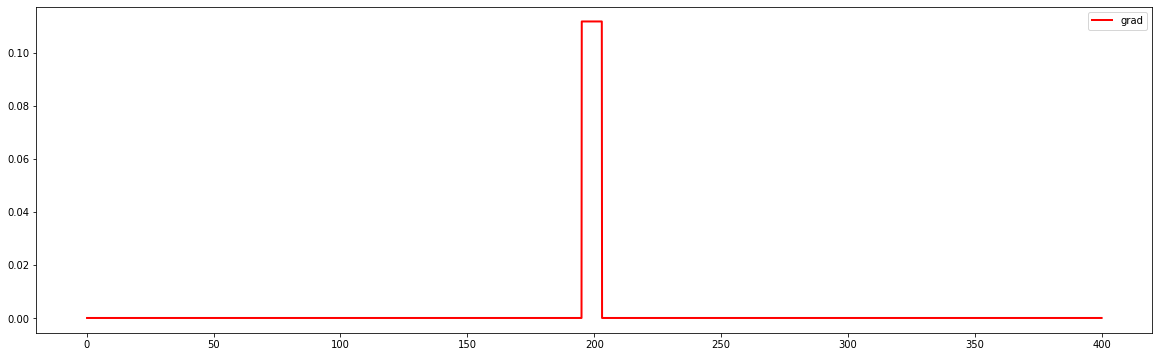

___
iteration: 180


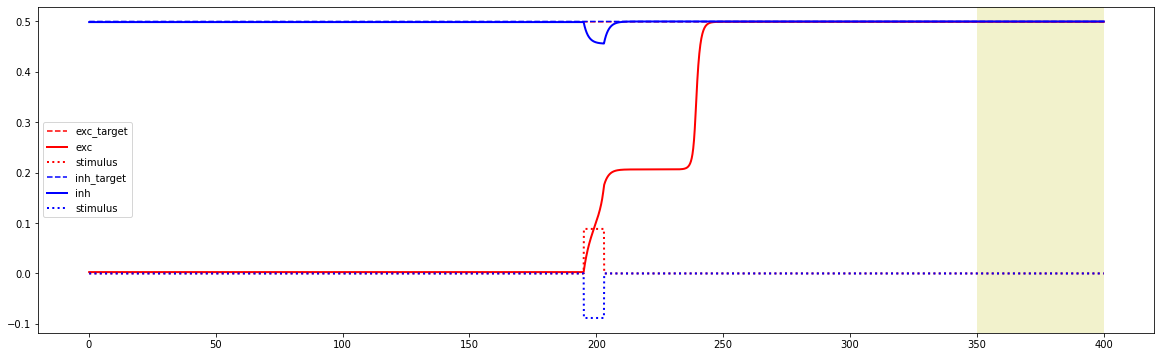

gradient:


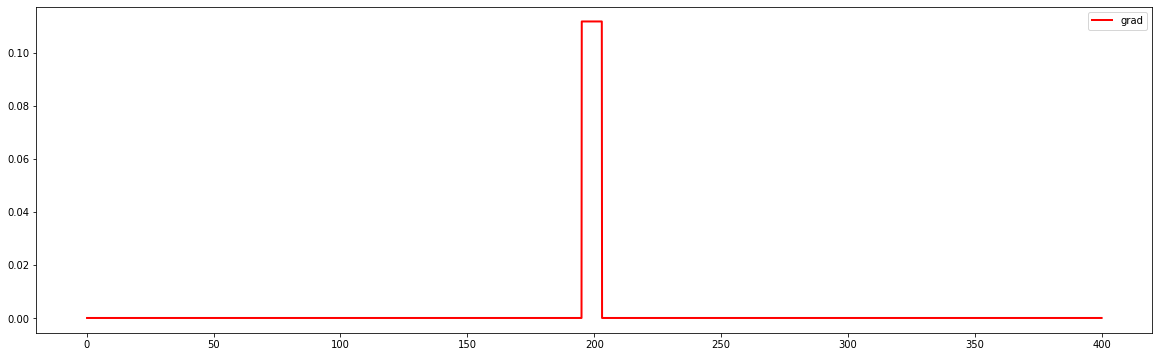

___
iteration: 200


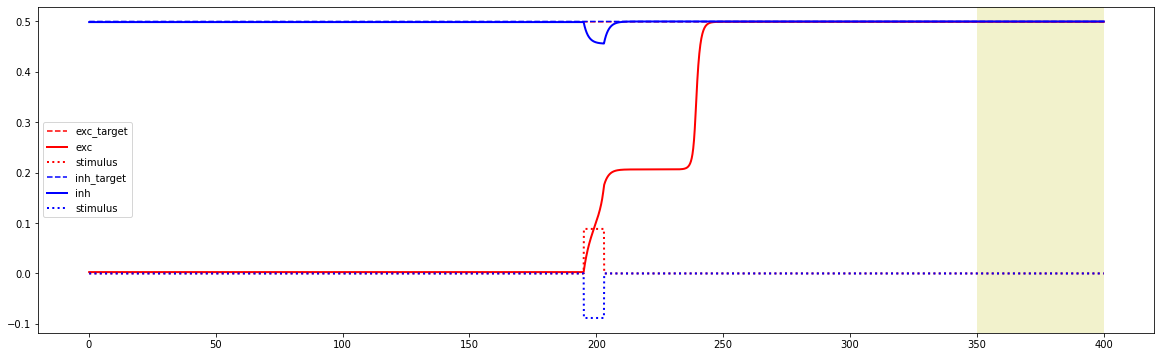

gradient:


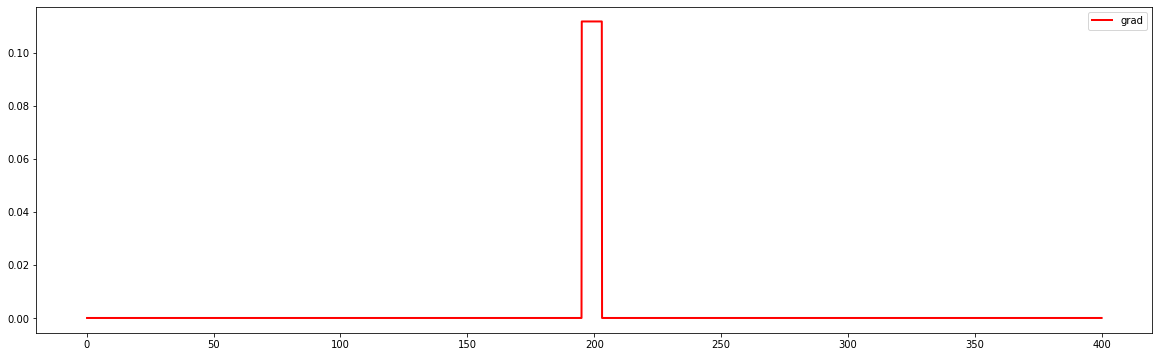

___
iteration: 220


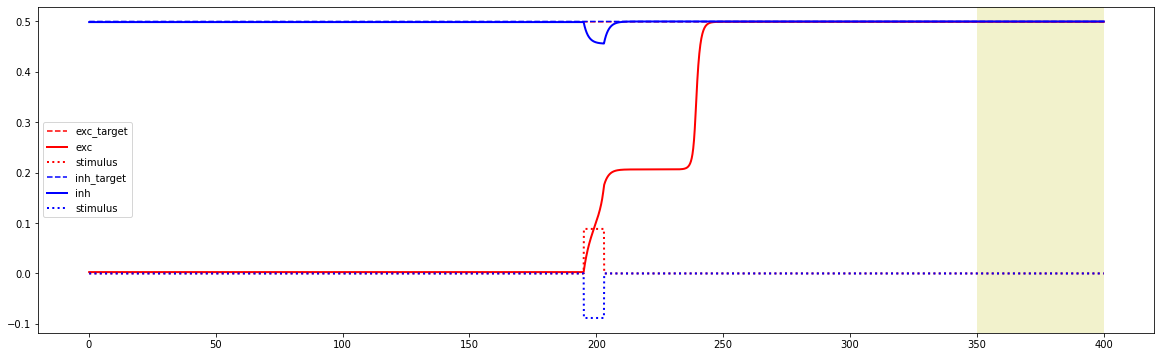

gradient:


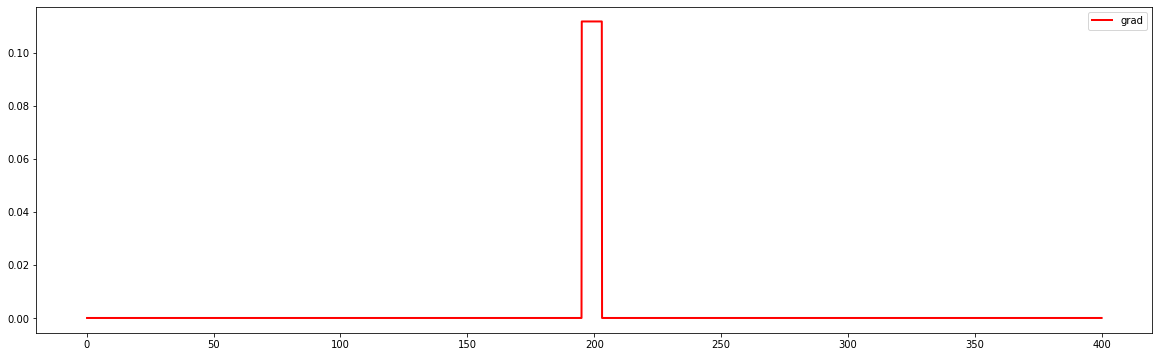

___
iteration: 240


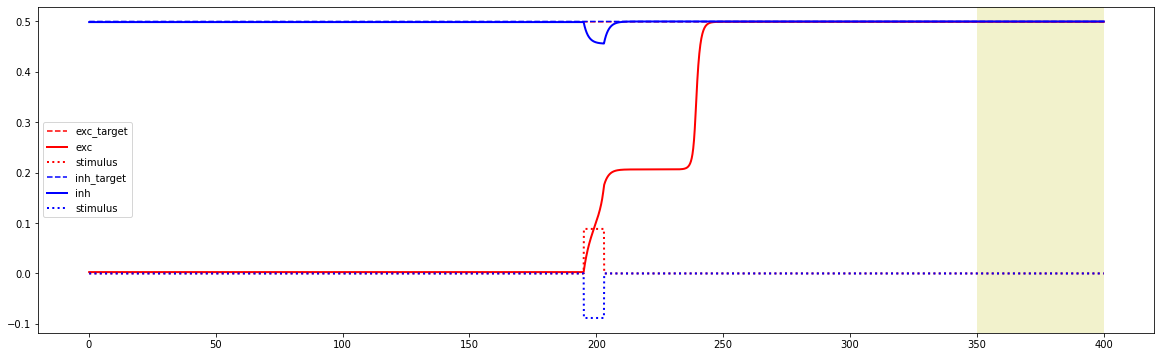

gradient:


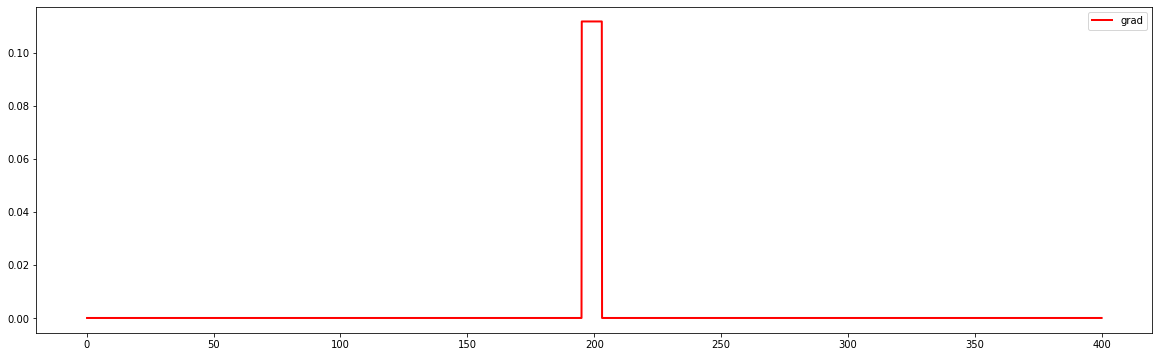

___
iteration: 260


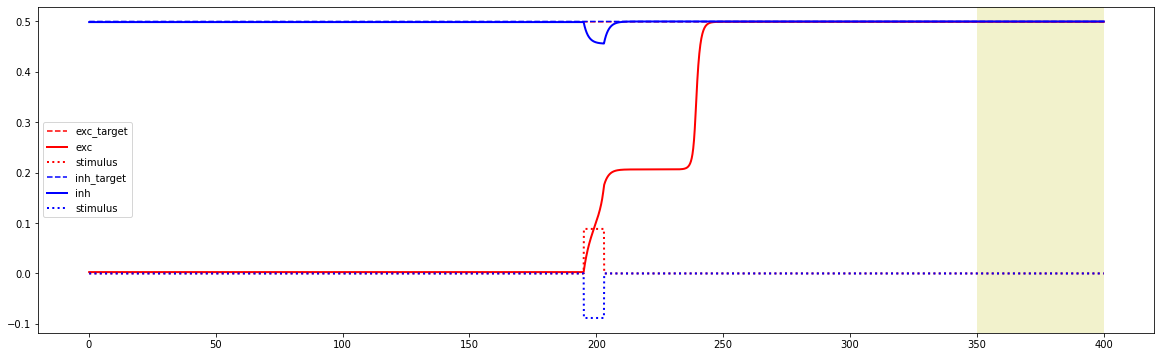

gradient:


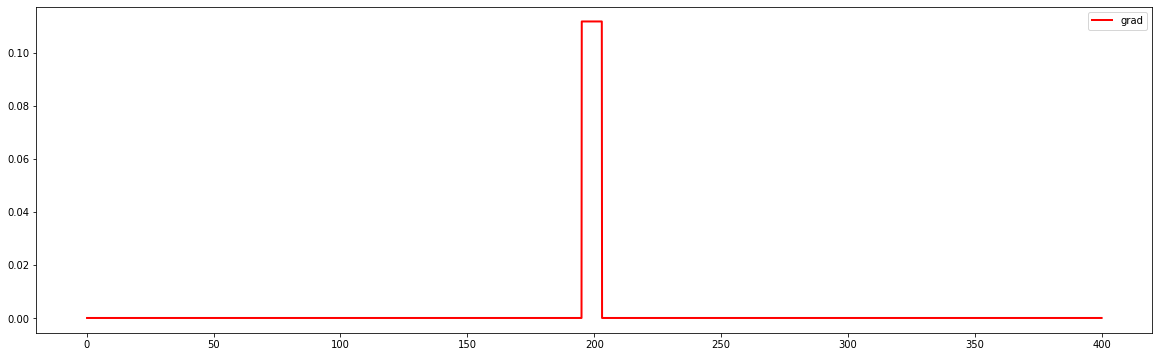

___
iteration: 280


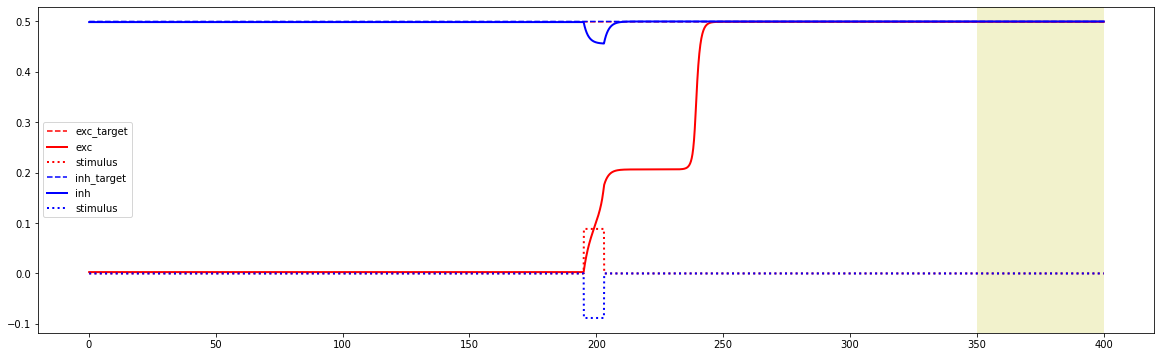

gradient:


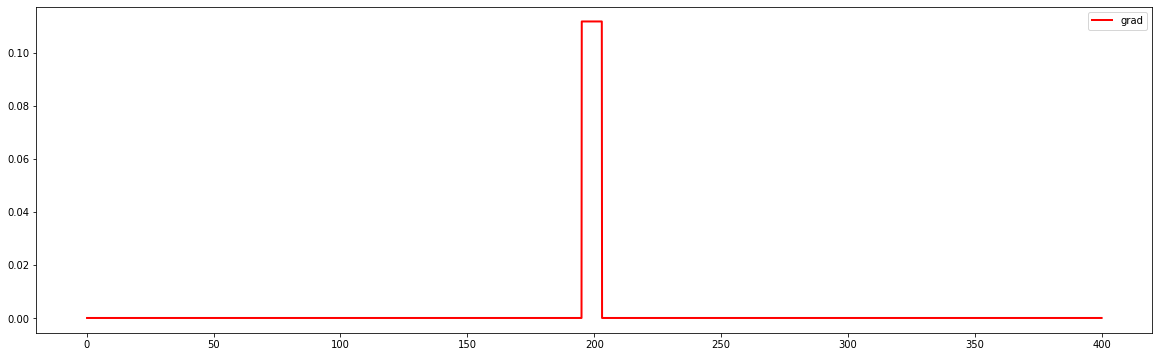

___
iteration: 300


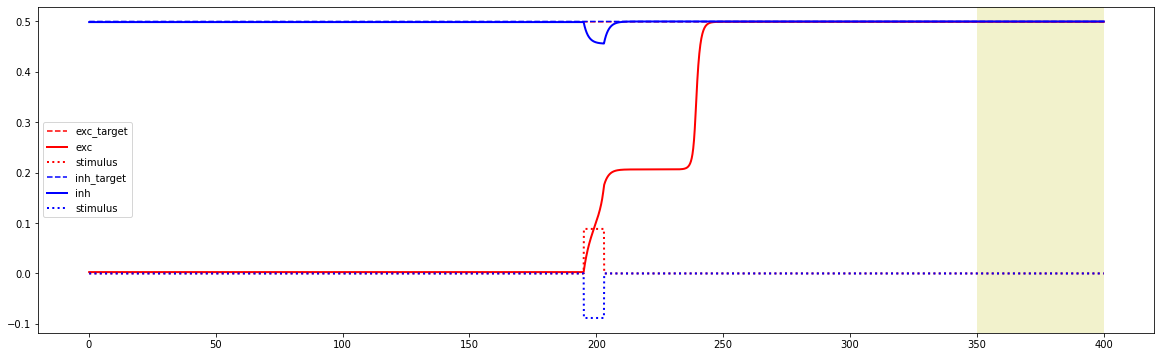

gradient:


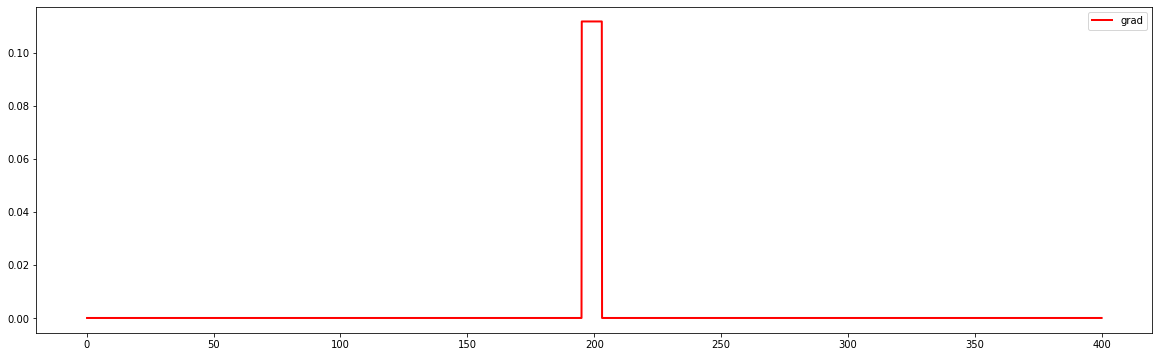

___
iteration: 320


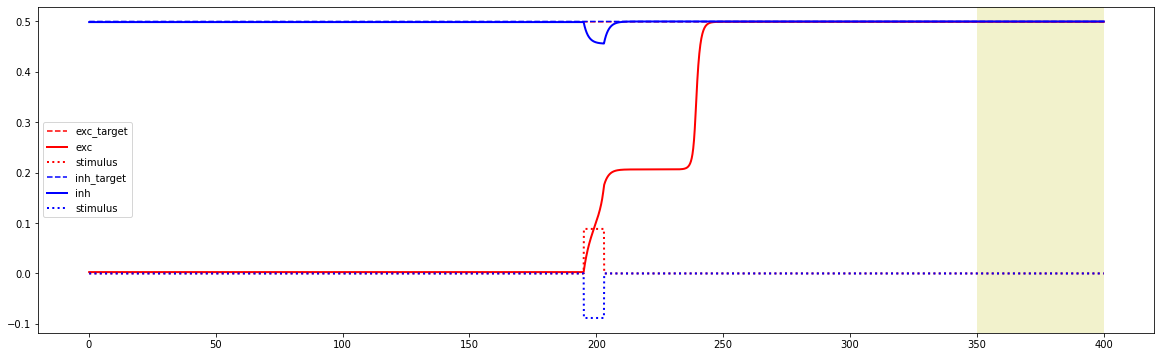

gradient:


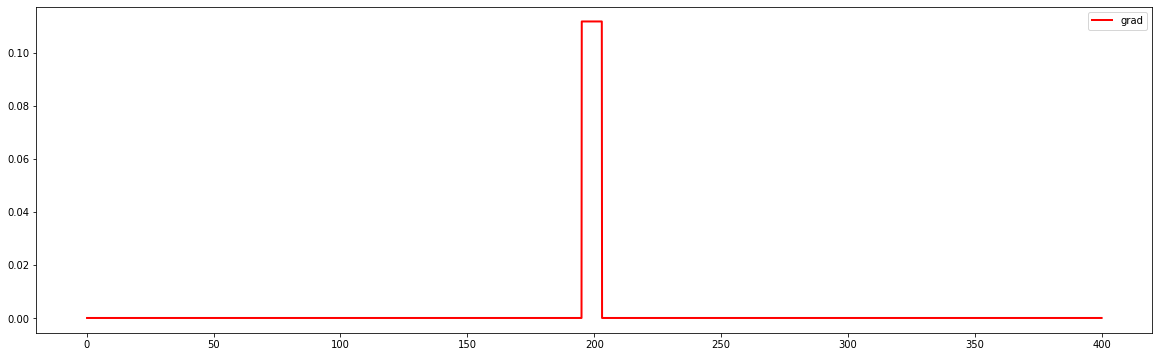

___
iteration: 340


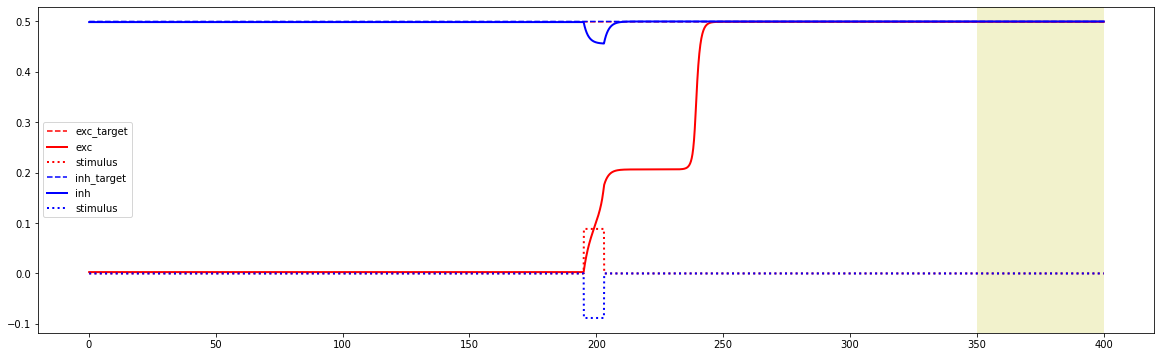

gradient:


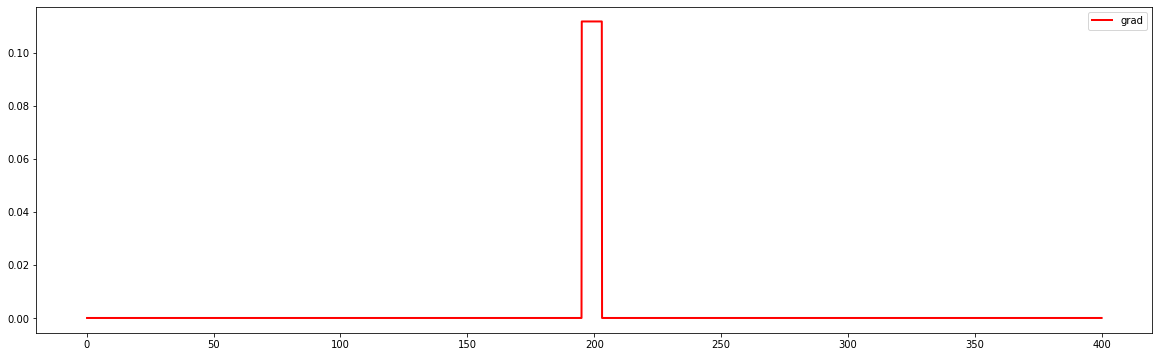

___
iteration: 360


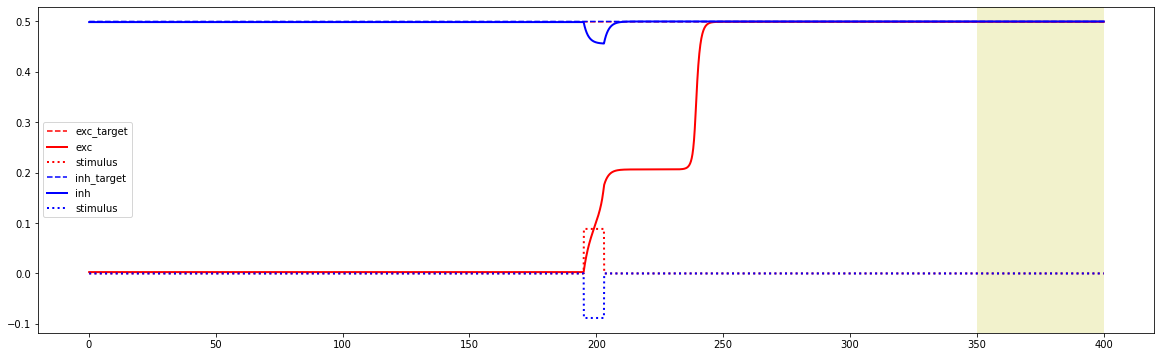

gradient:


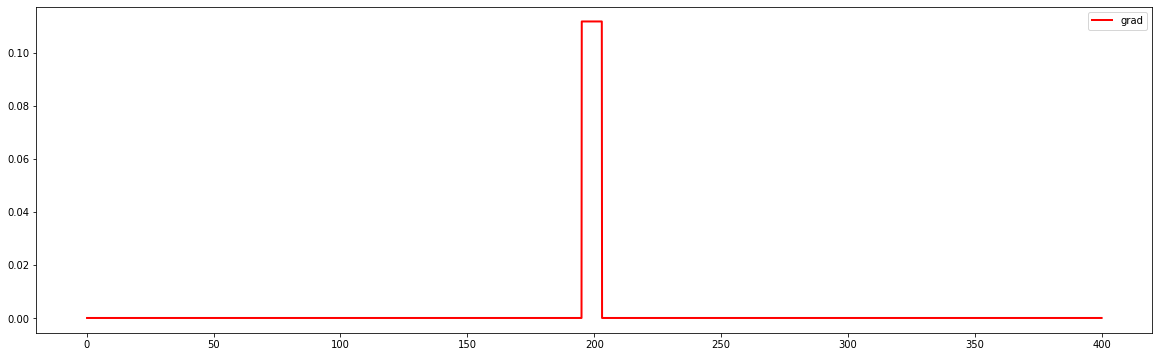

___
iteration: 380


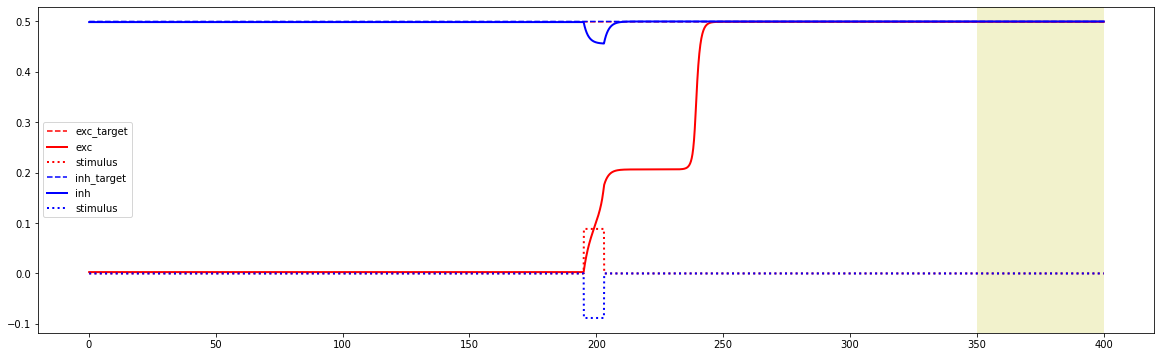

gradient:


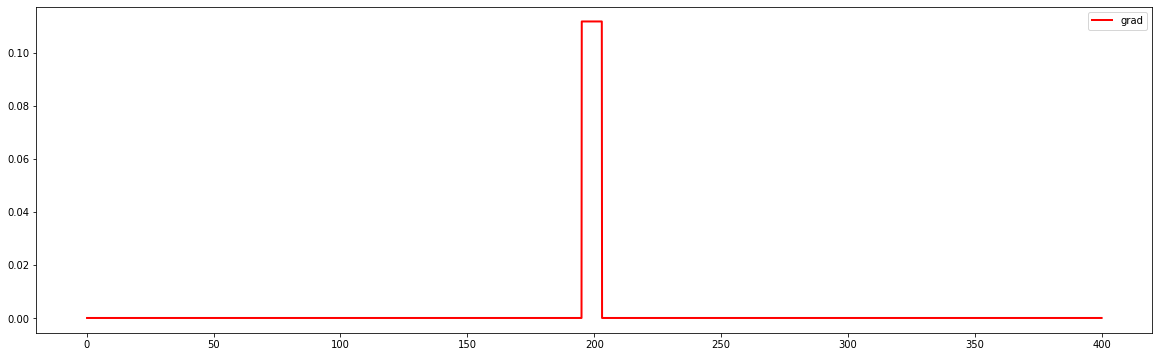

w 90
___
iteration: 0


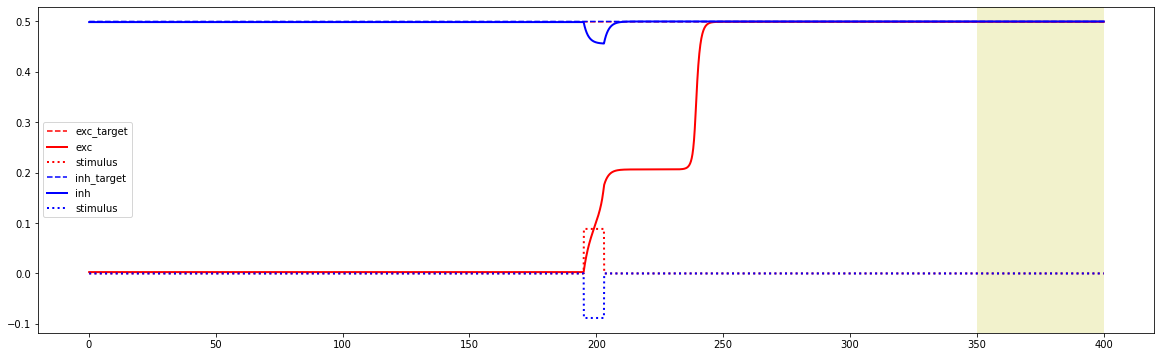

gradient:


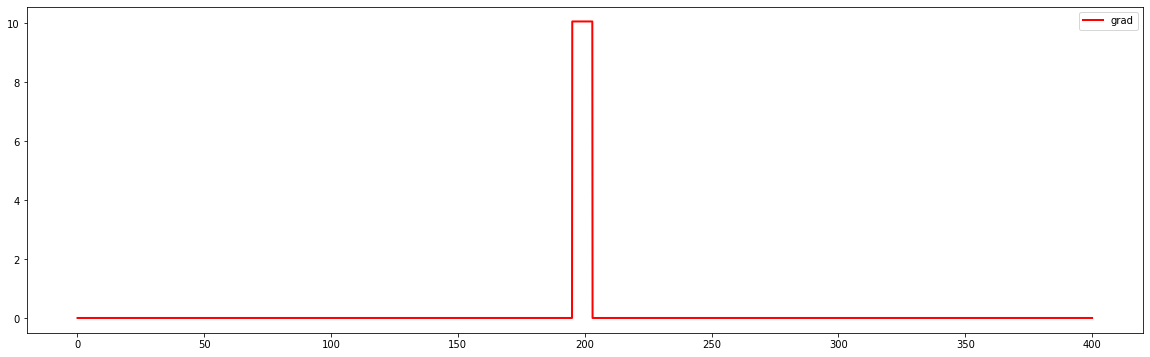

___
iteration: 20


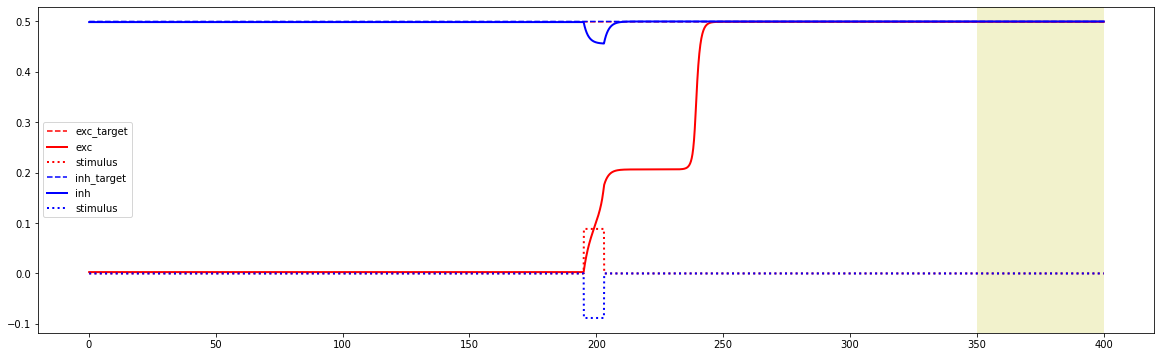

gradient:


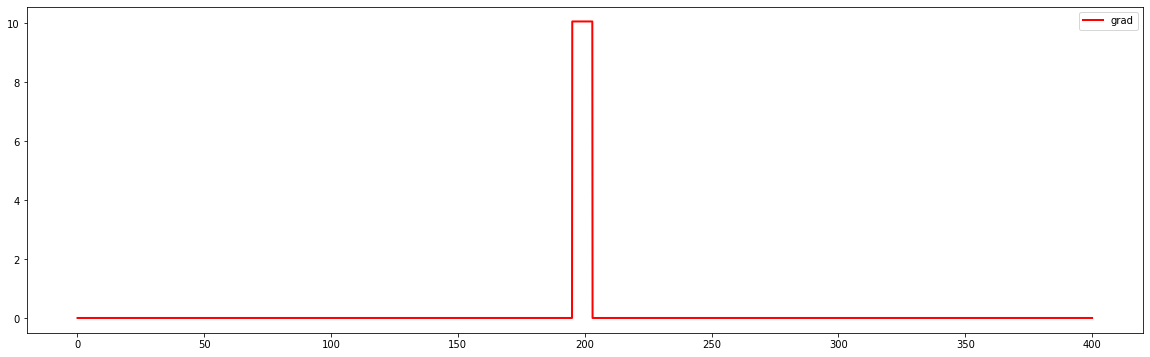

___
iteration: 40


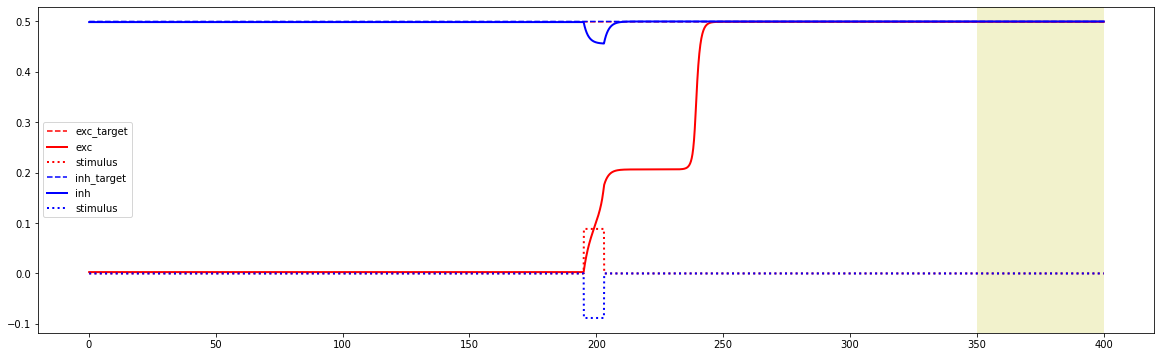

gradient:


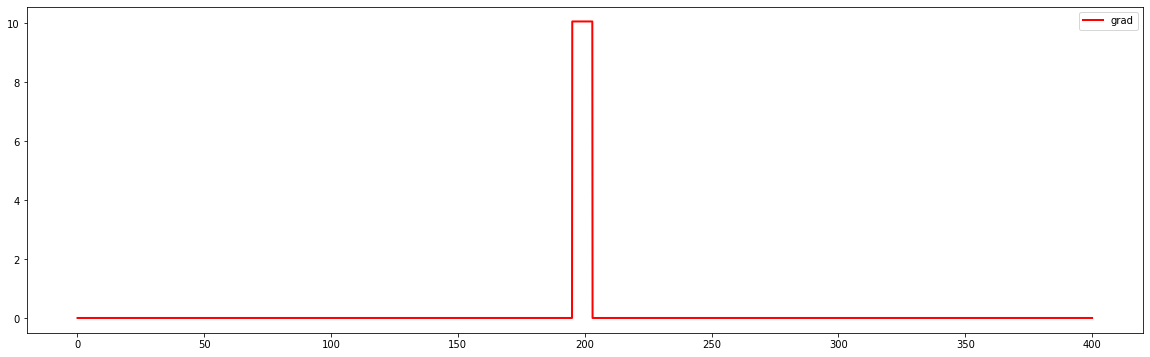

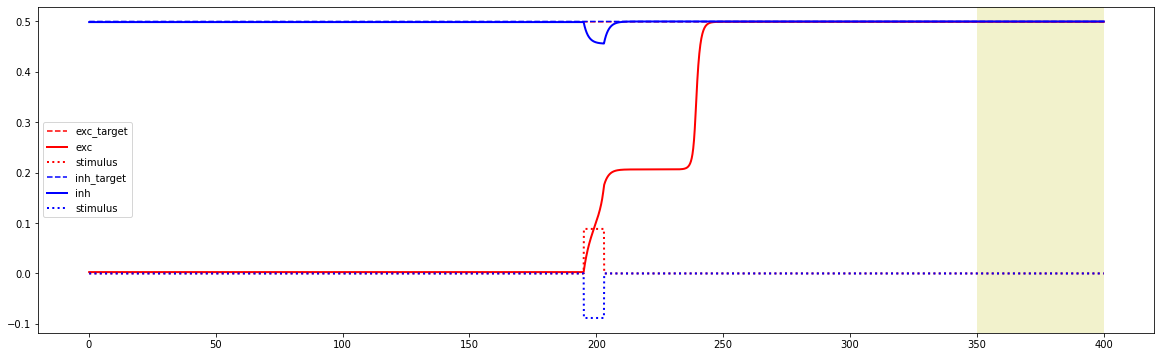

w 1
___
iteration: 0


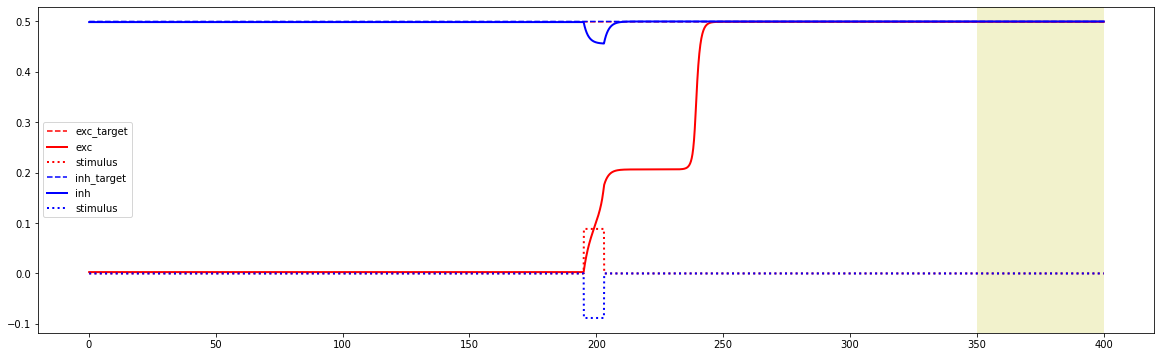

gradient:


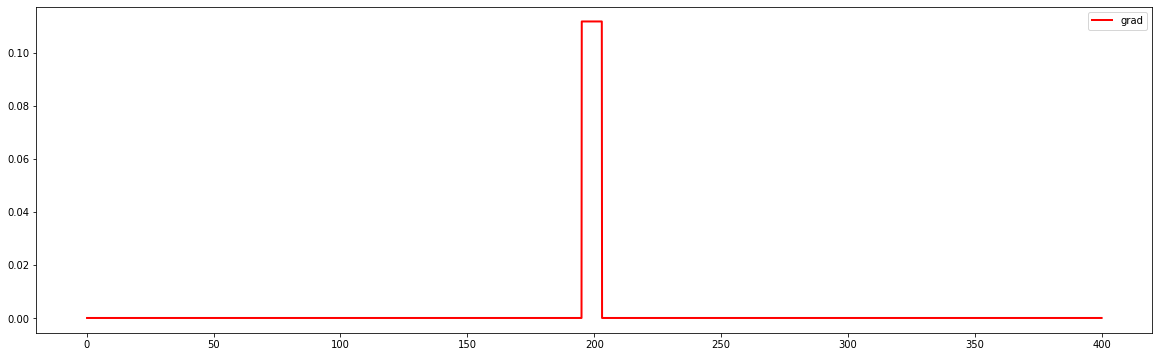

___
iteration: 20


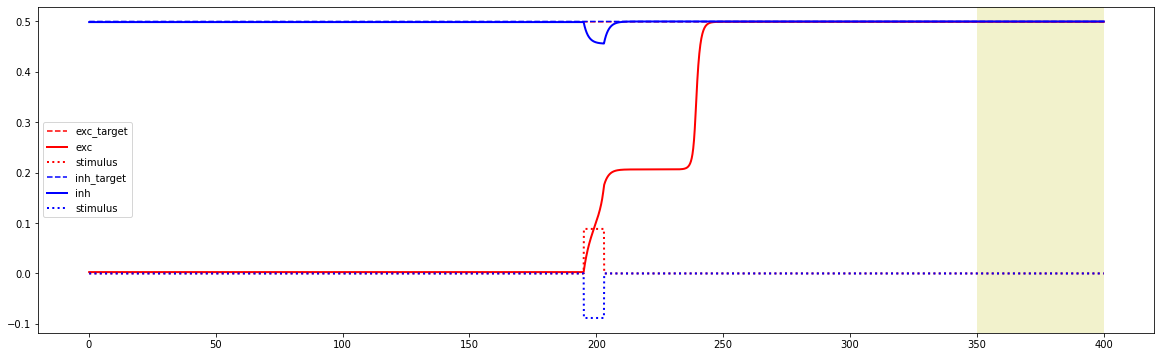

gradient:


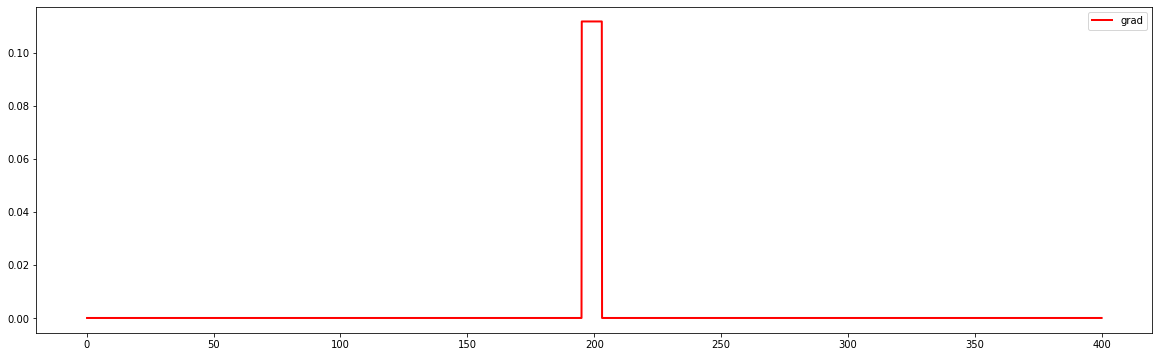

___
iteration: 40


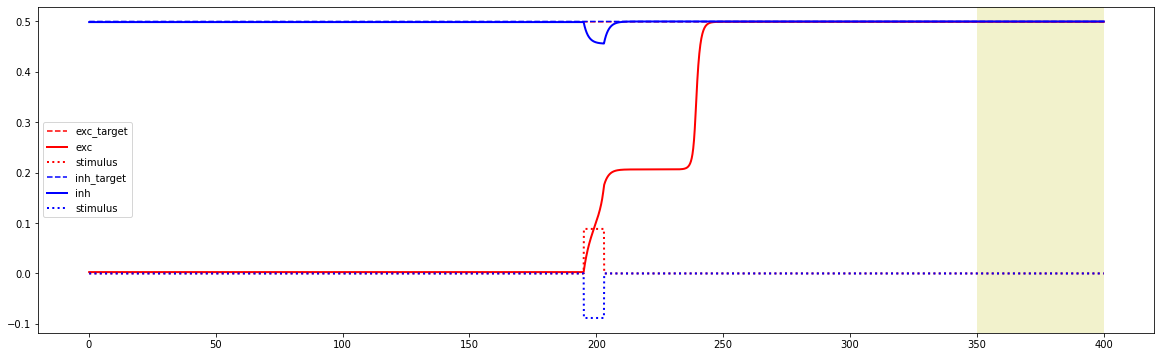

gradient:


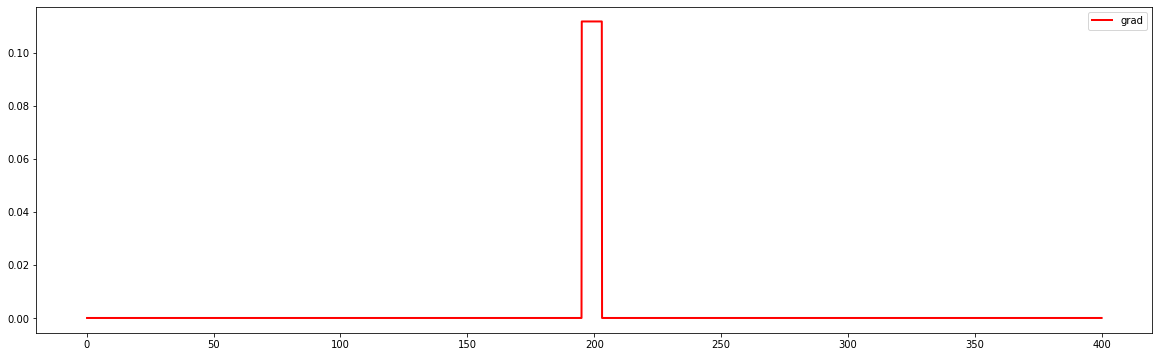

___
iteration: 60


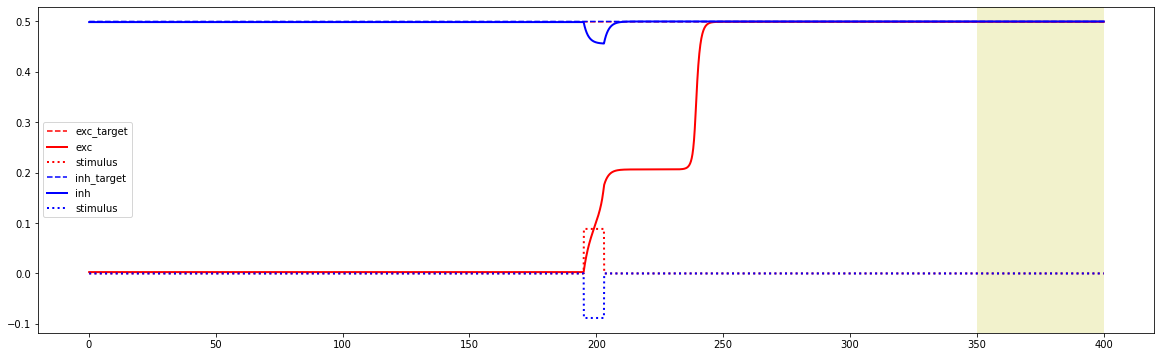

gradient:


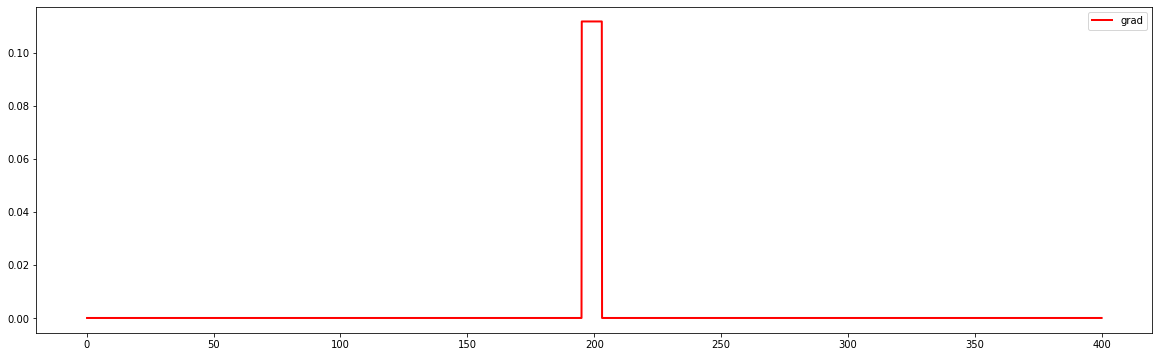

___
iteration: 80


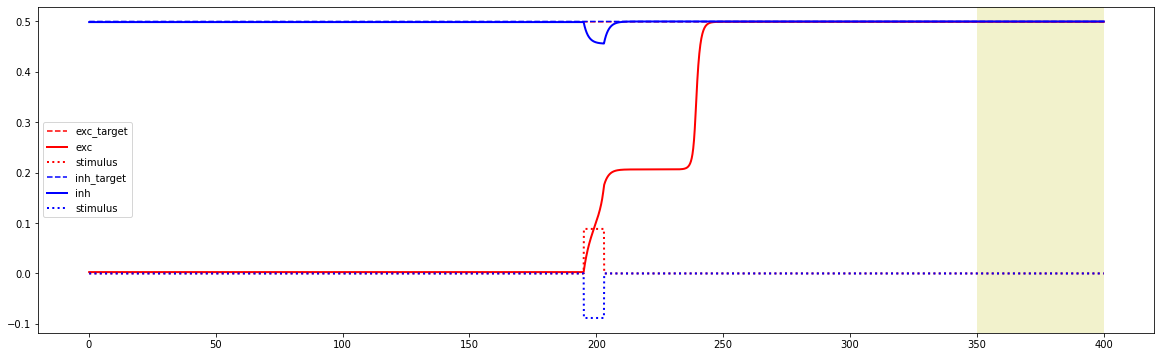

gradient:


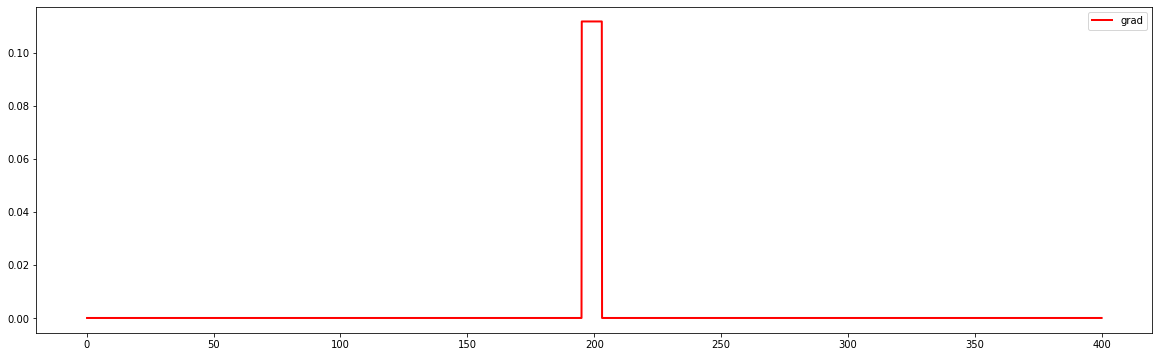

___
iteration: 100


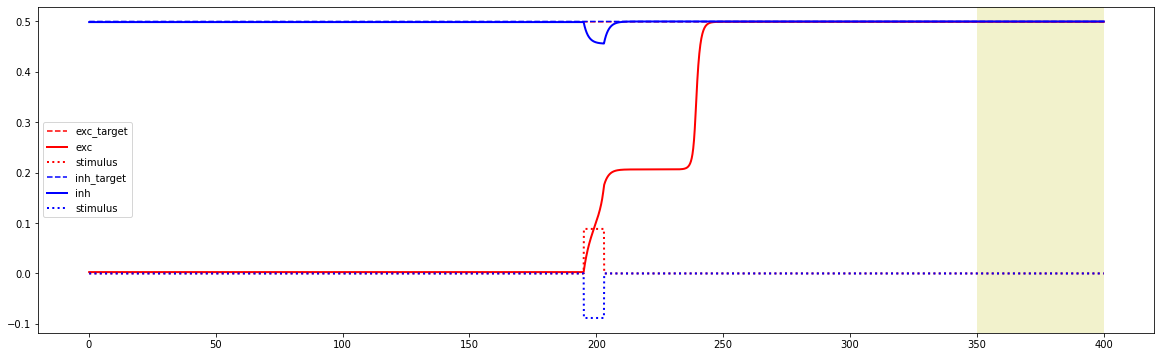

gradient:


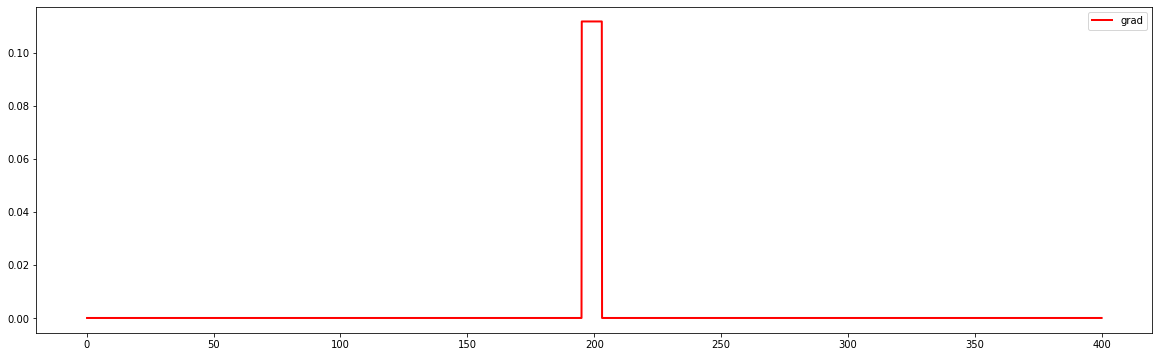

___
iteration: 120


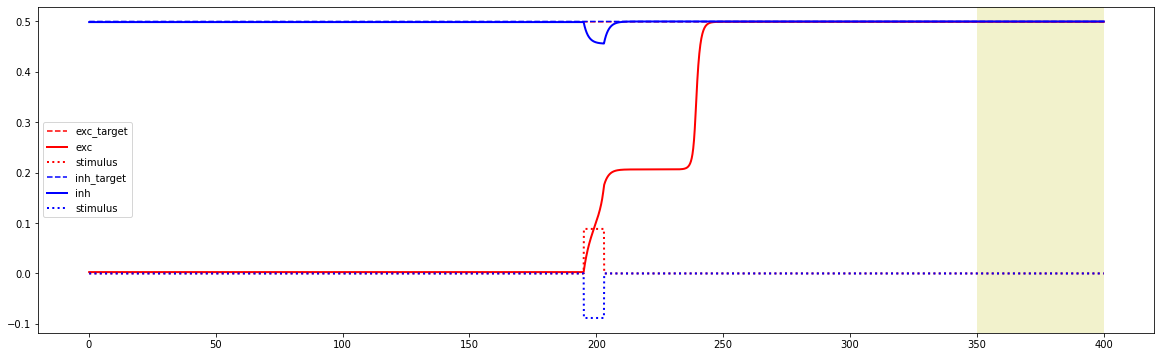

gradient:


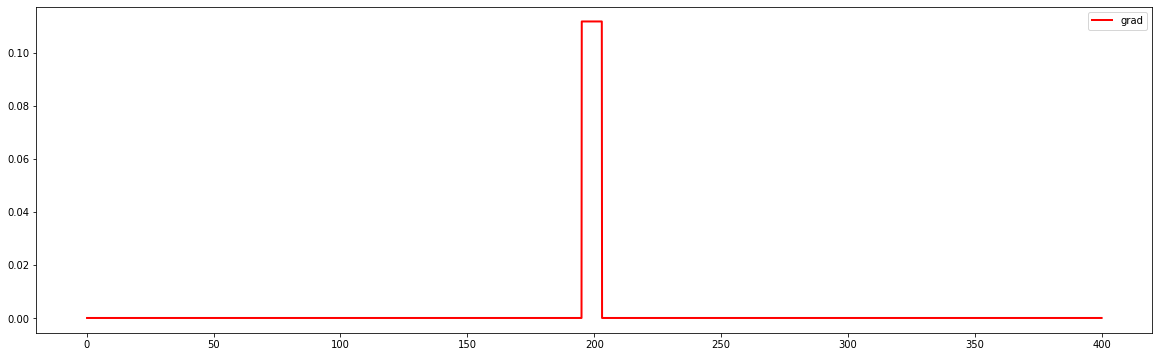

___
iteration: 140


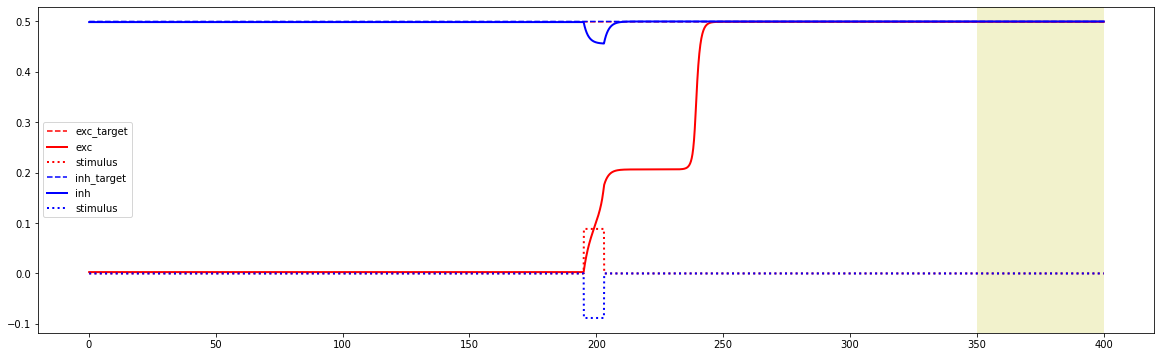

gradient:


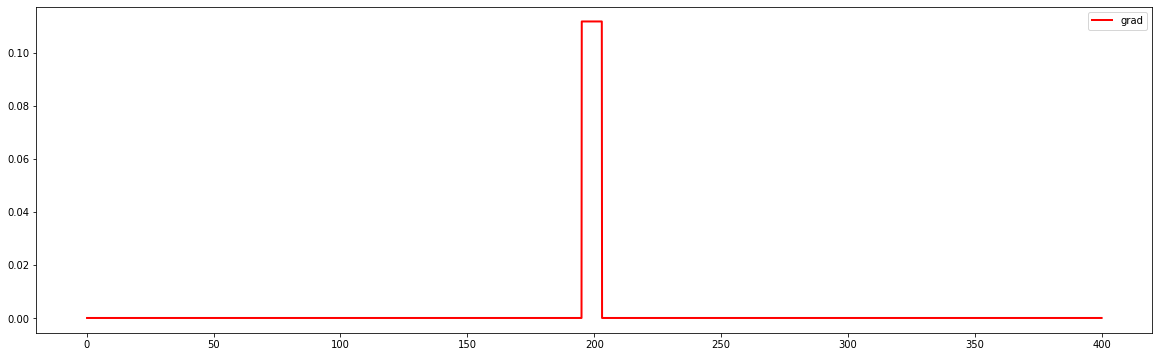

___
iteration: 160


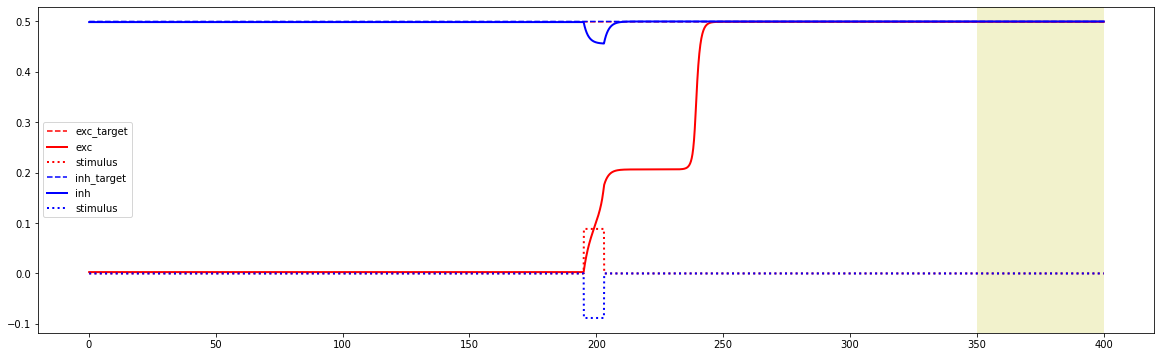

gradient:


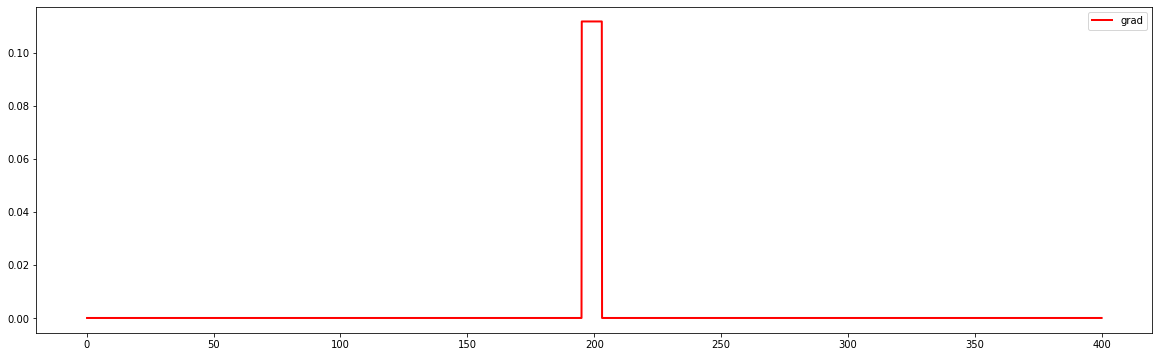

___
iteration: 180


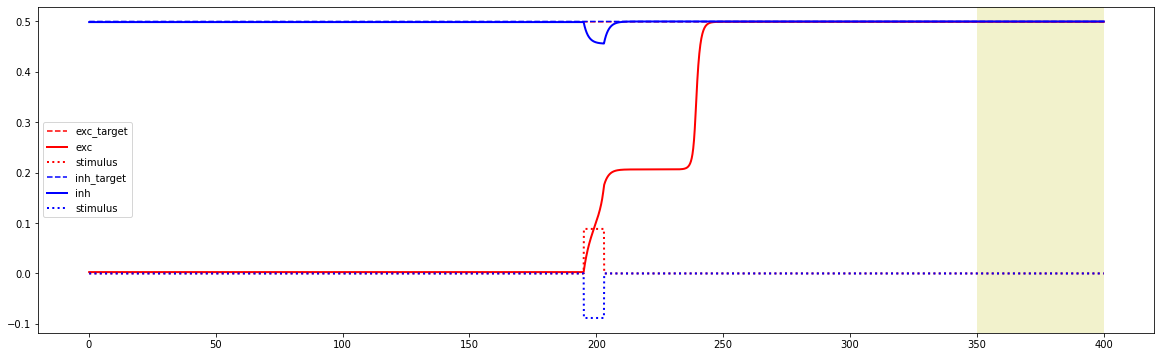

gradient:


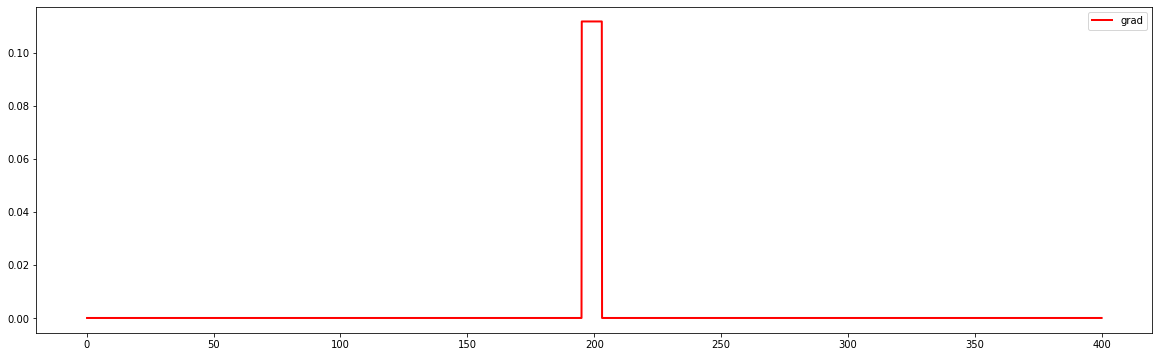

___
iteration: 200


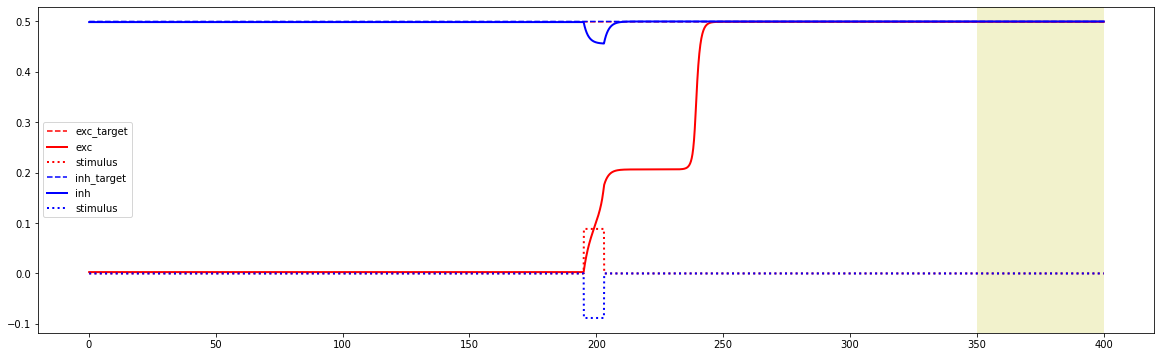

gradient:


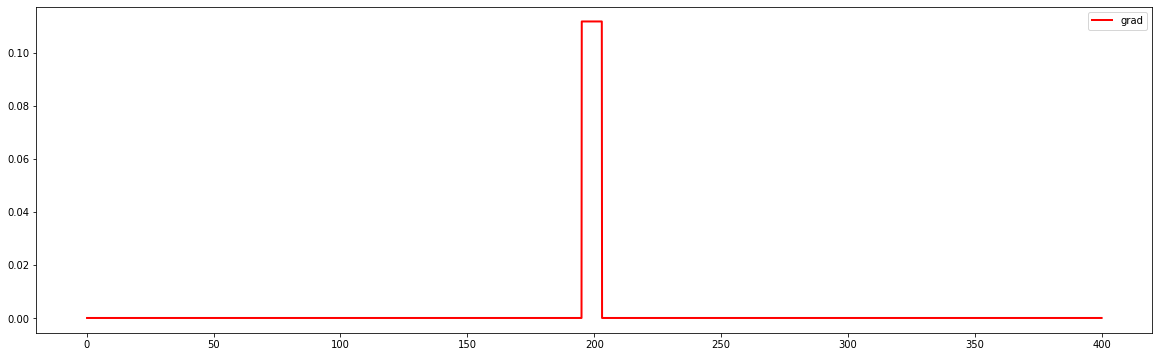

___
iteration: 220


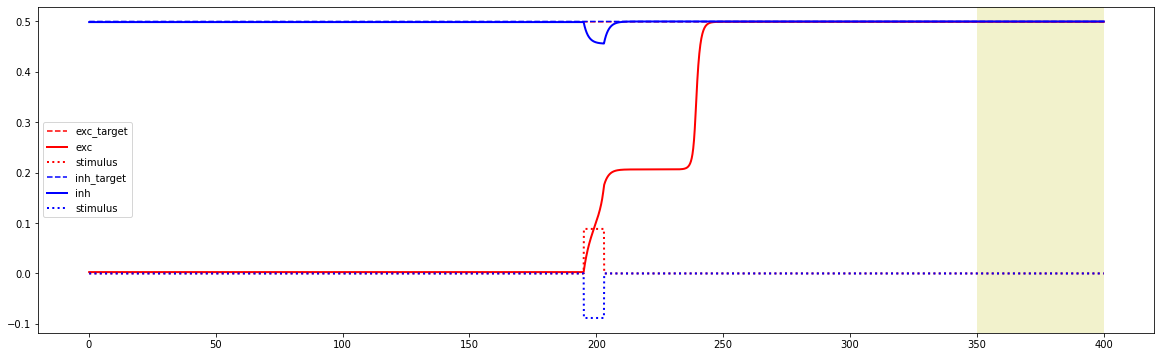

gradient:


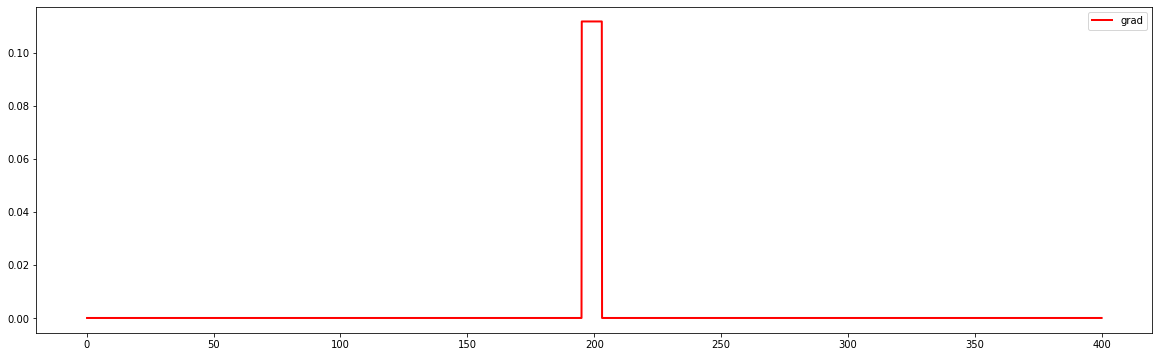

___
iteration: 240


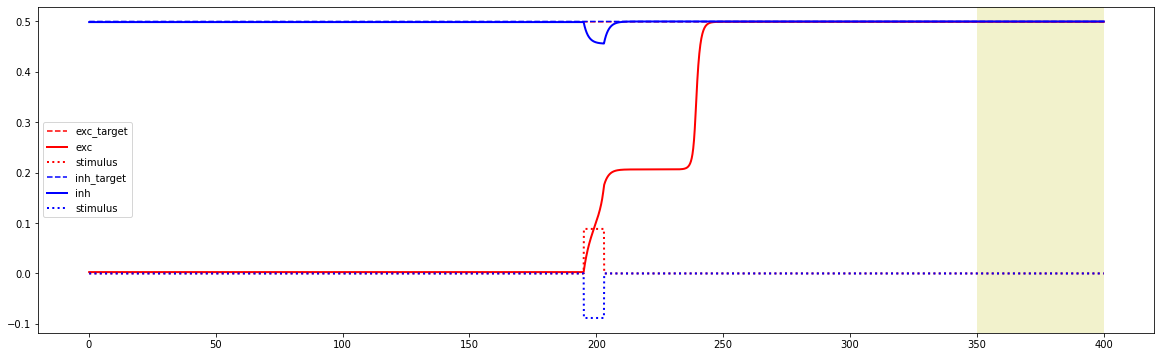

gradient:


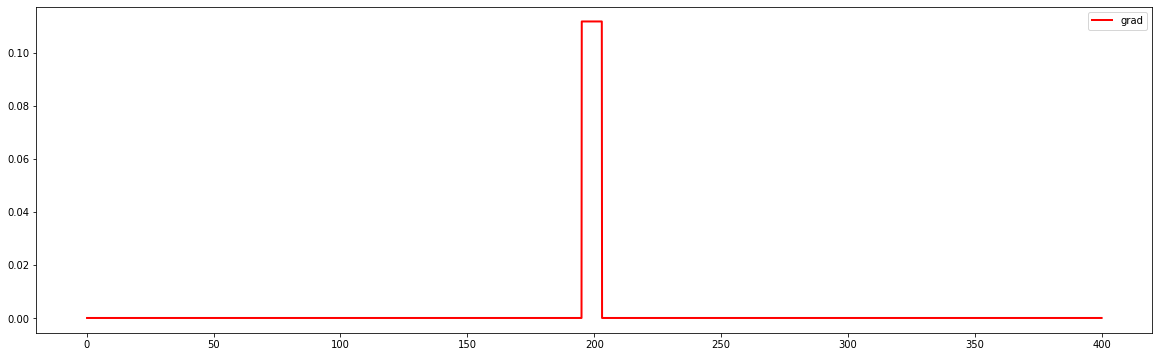

___
iteration: 260


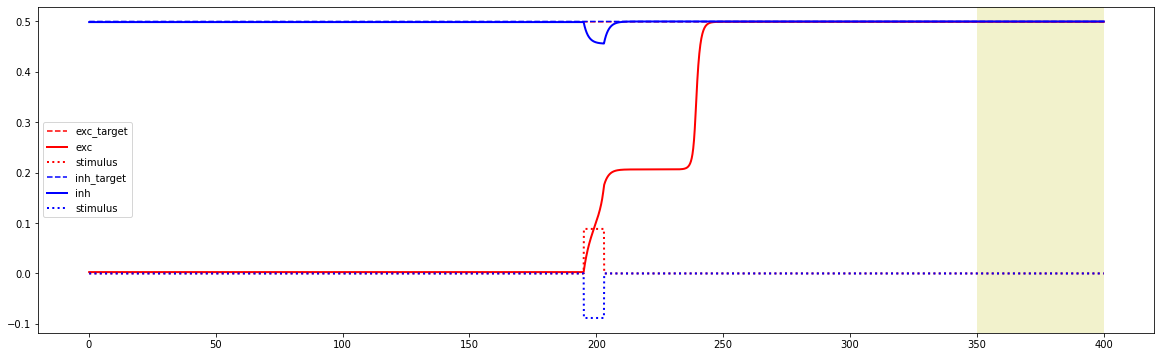

gradient:


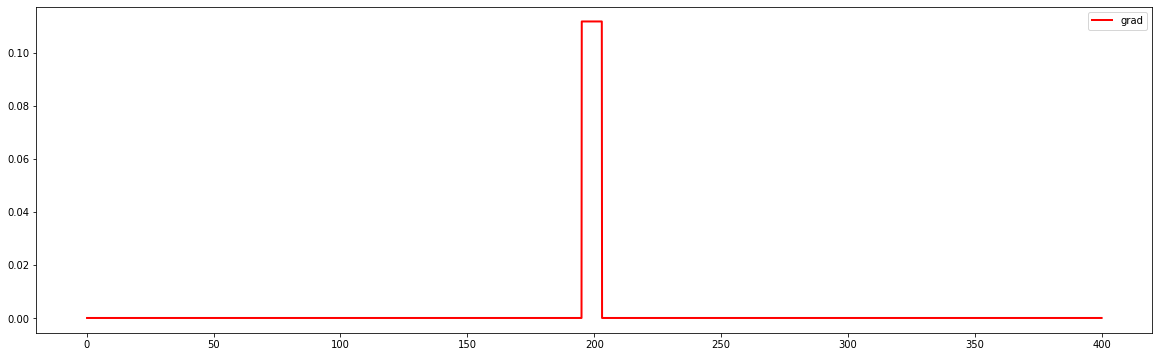

___
iteration: 280


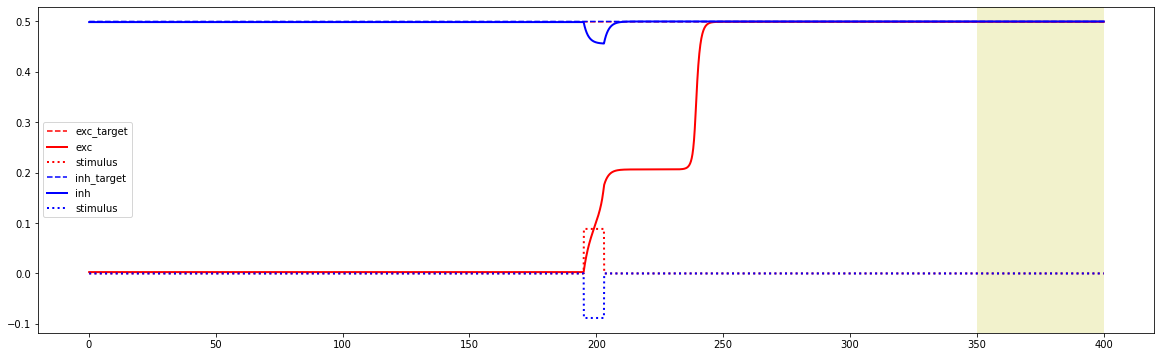

gradient:


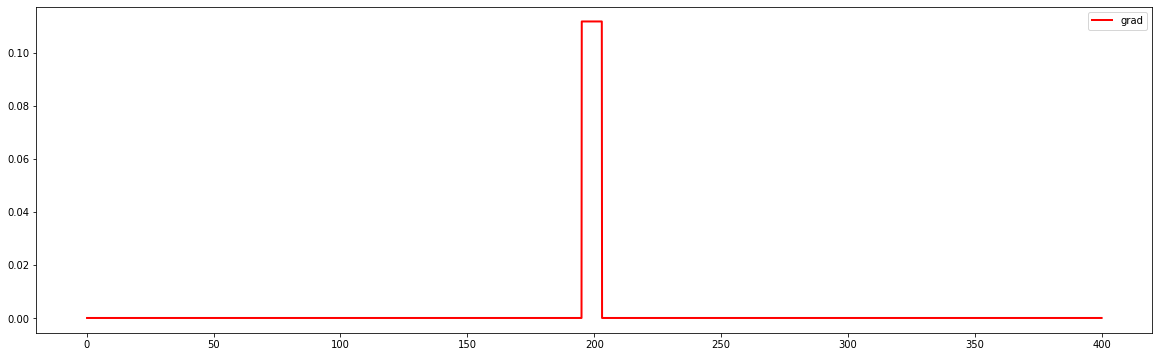

___
iteration: 300


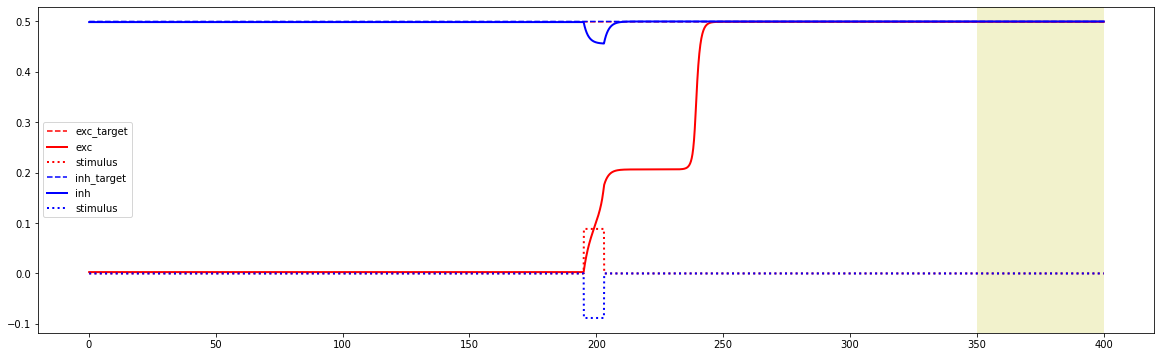

gradient:


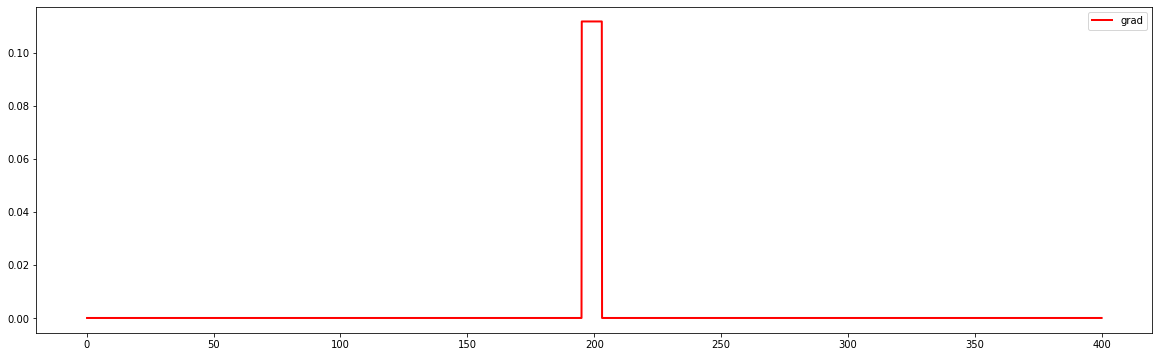

___
iteration: 320


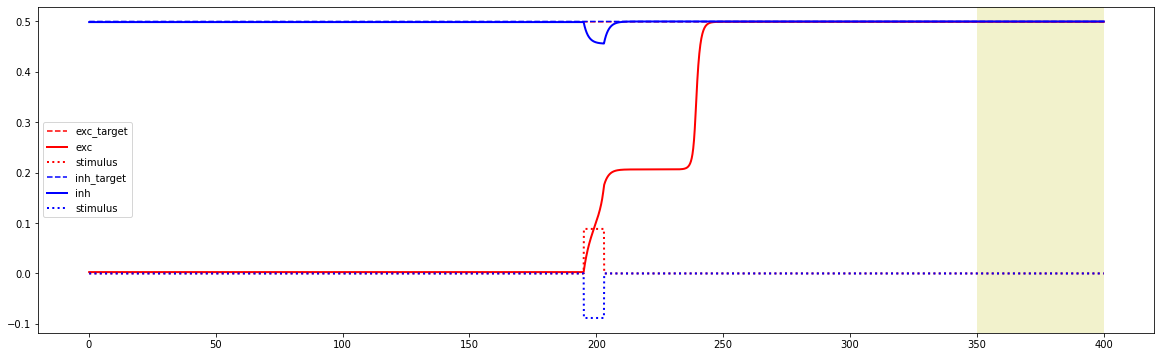

gradient:


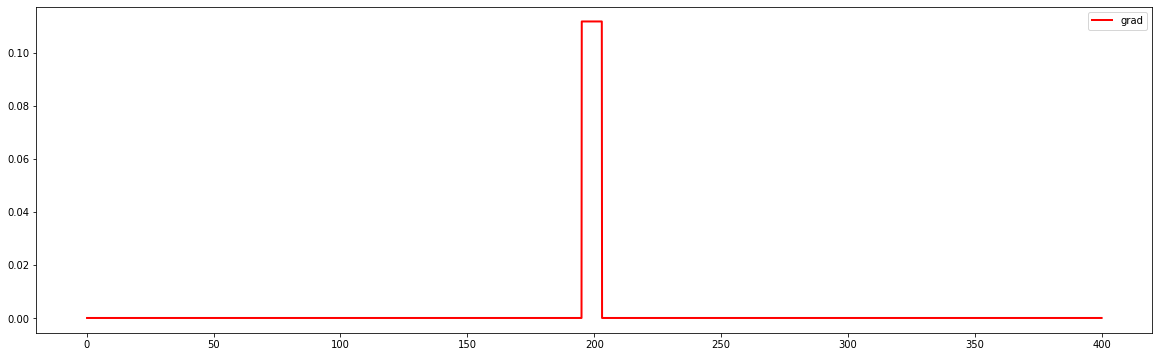

___
iteration: 340


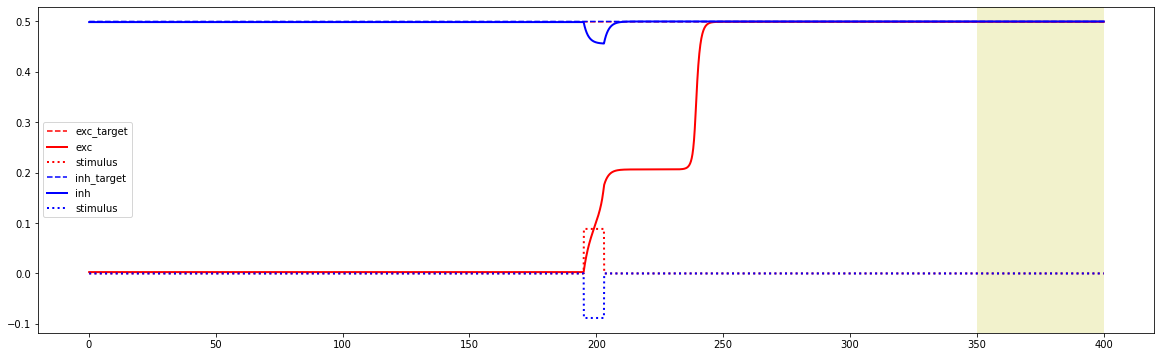

gradient:


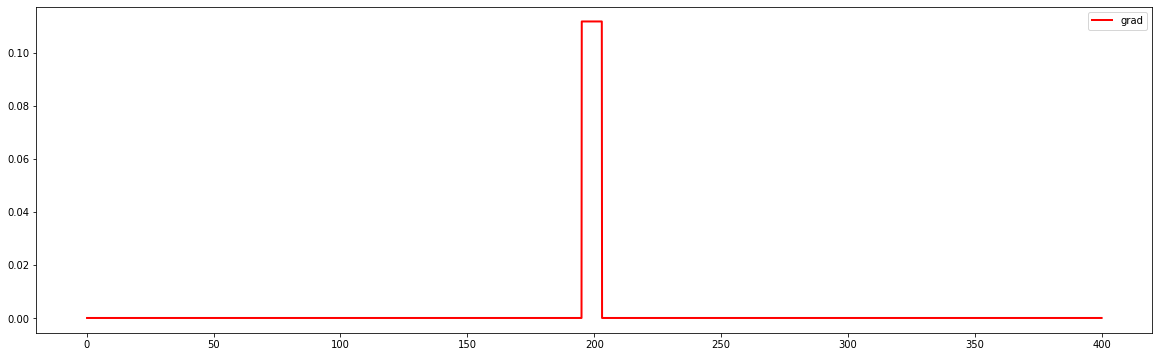

___
iteration: 360


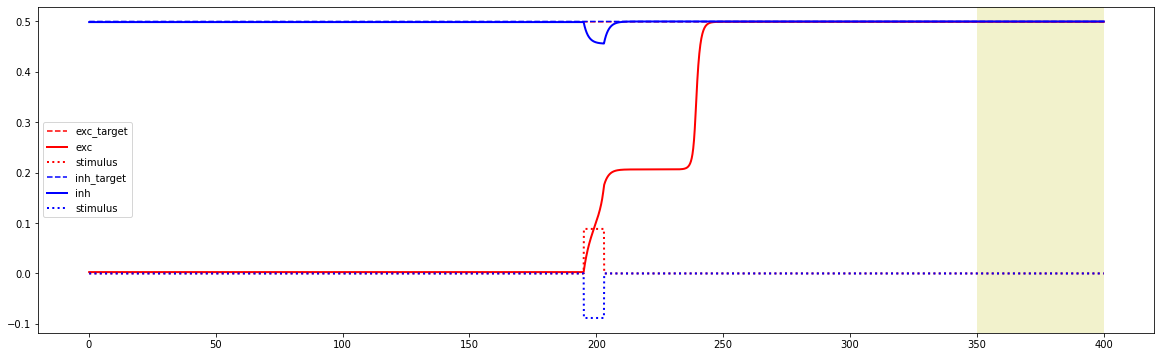

gradient:


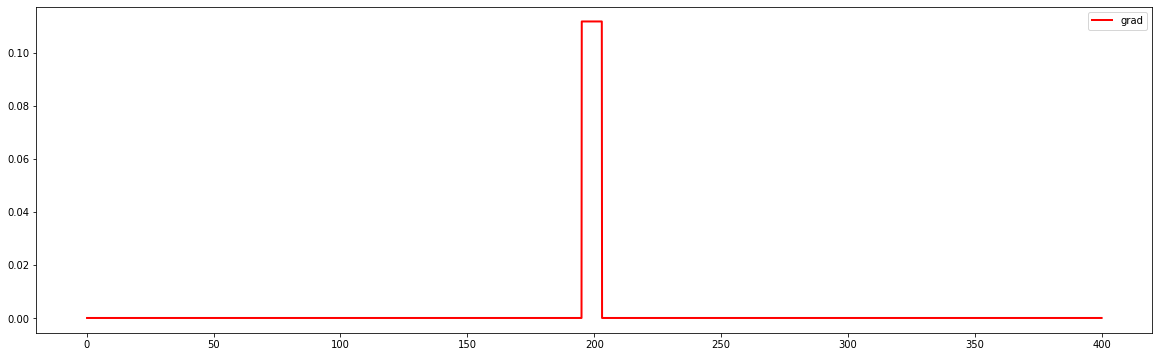

___
iteration: 380


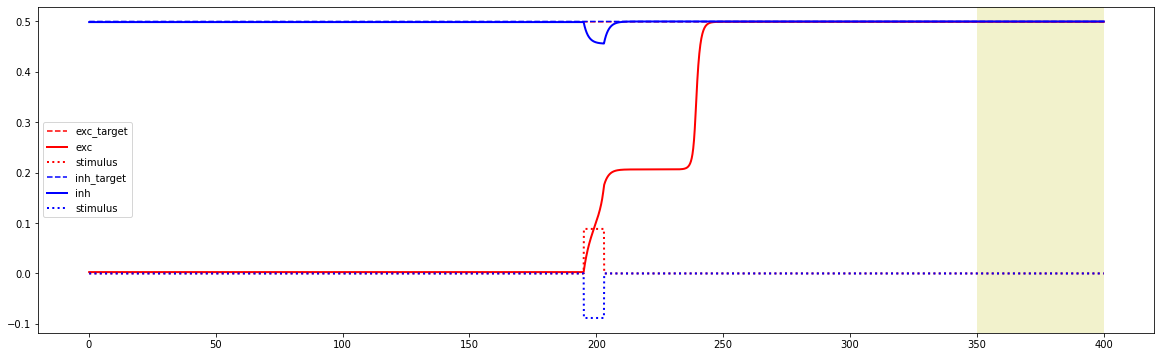

gradient:


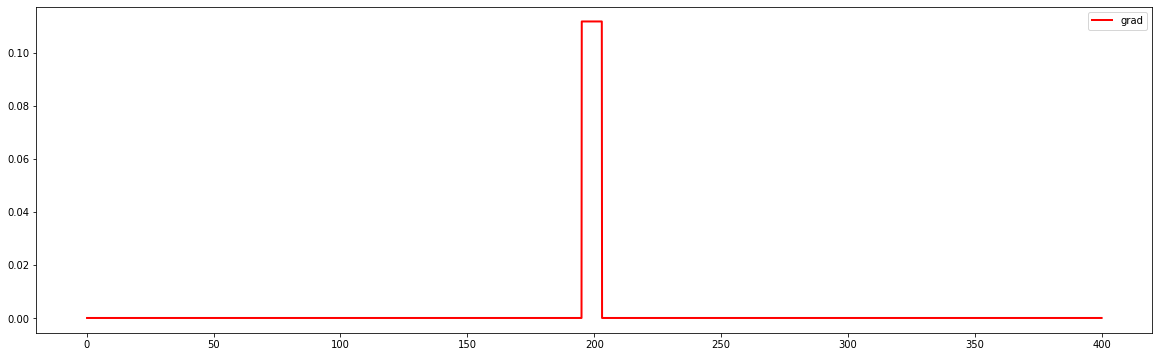

exc_ext, inh_ext 5 9


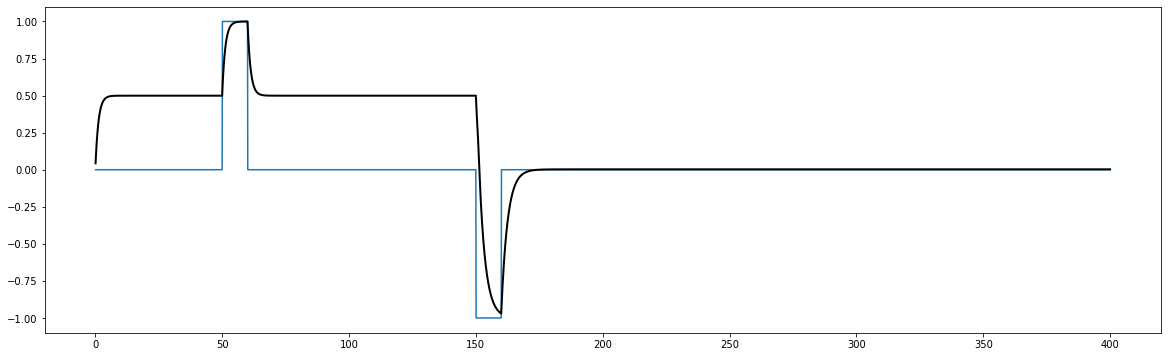

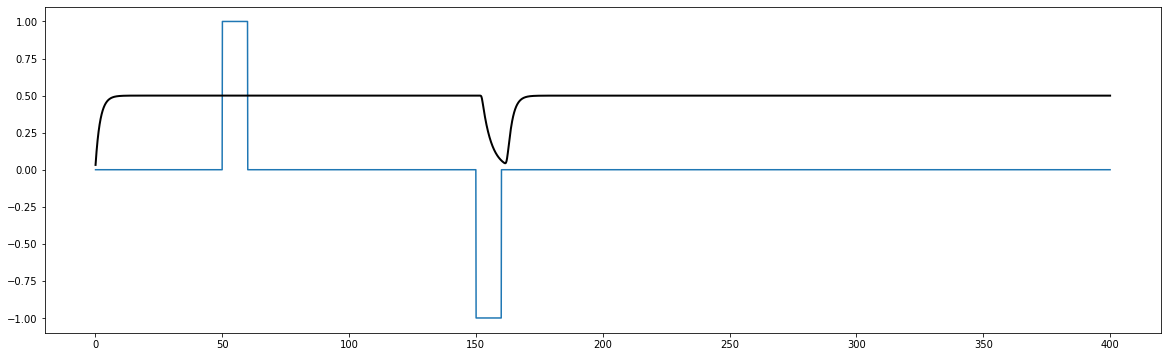

w 1
___
iteration: 0


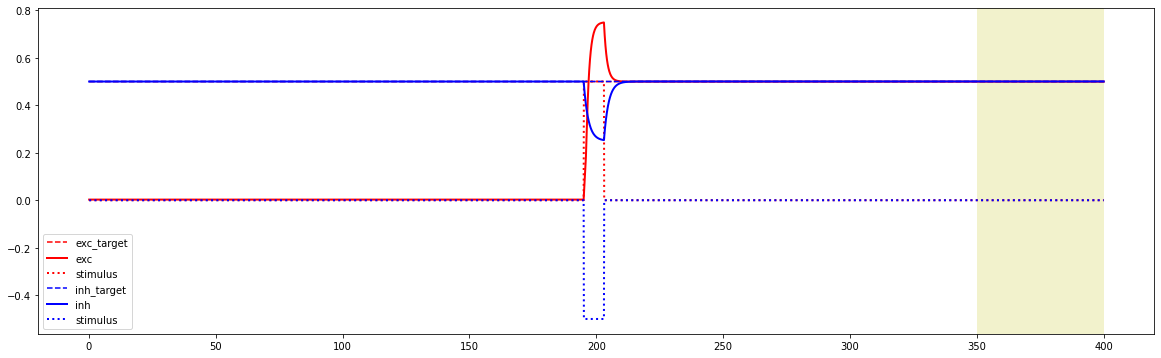

gradient:


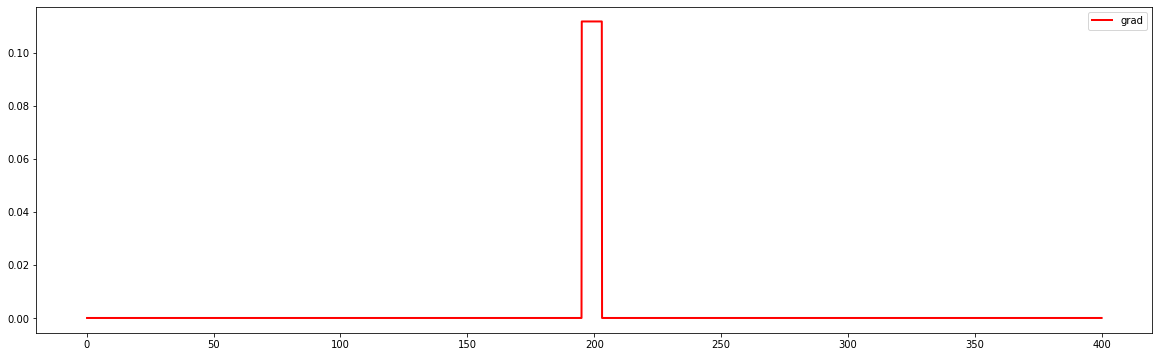

___
iteration: 20


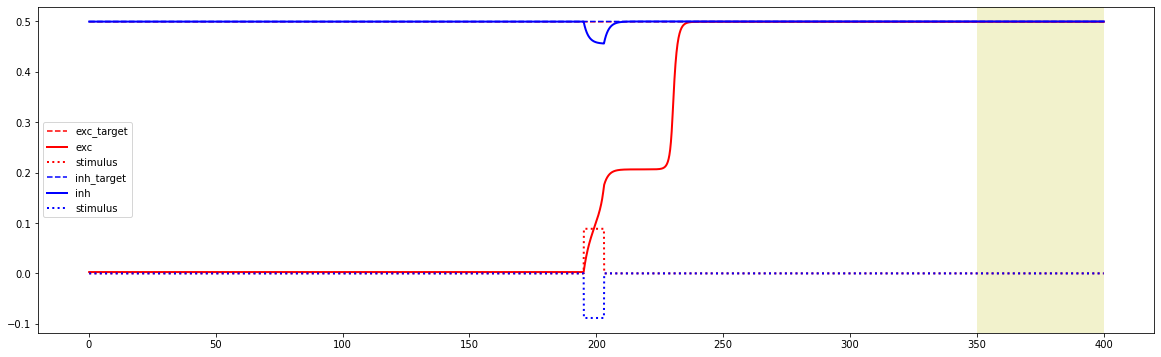

gradient:


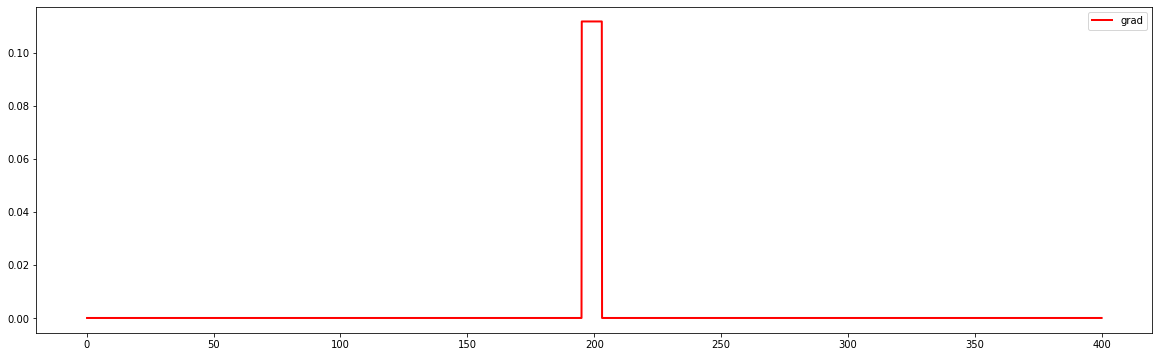

___
iteration: 40


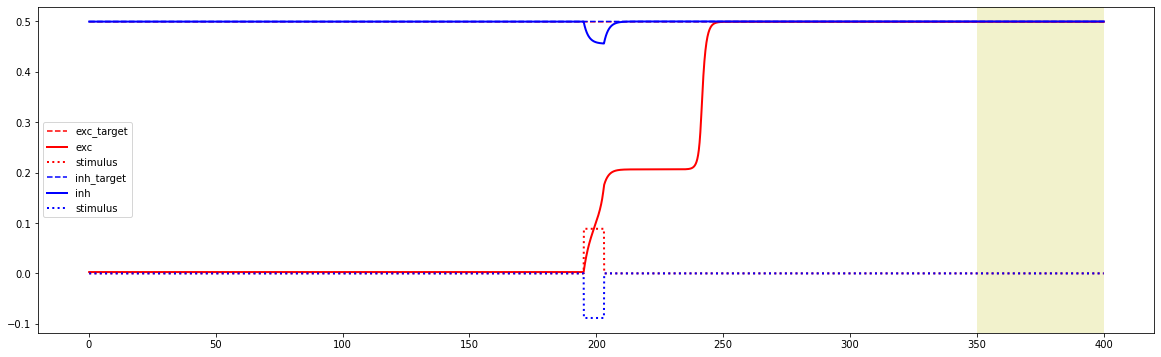

gradient:


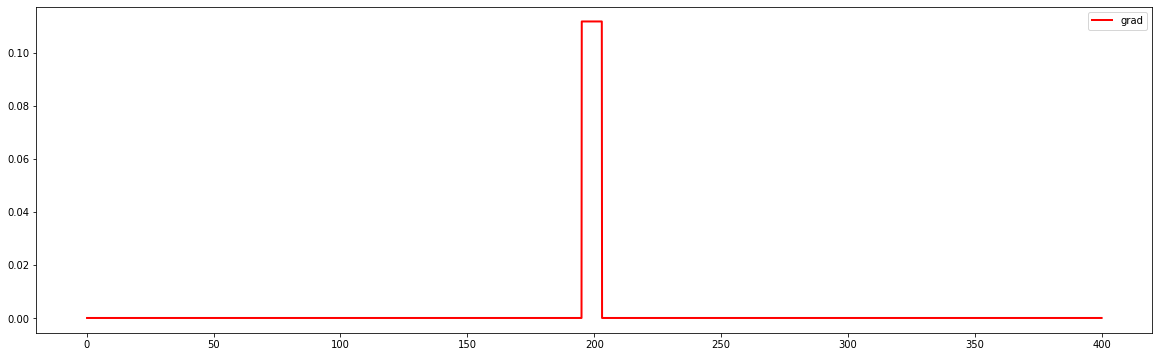

___
iteration: 60


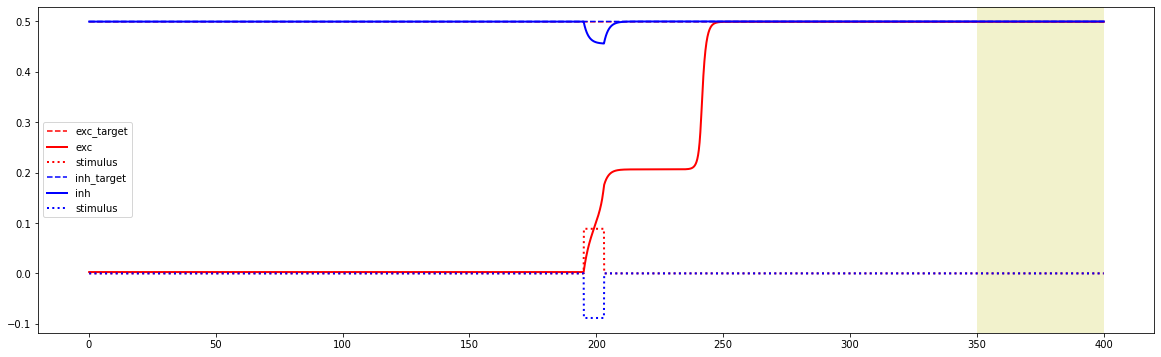

gradient:


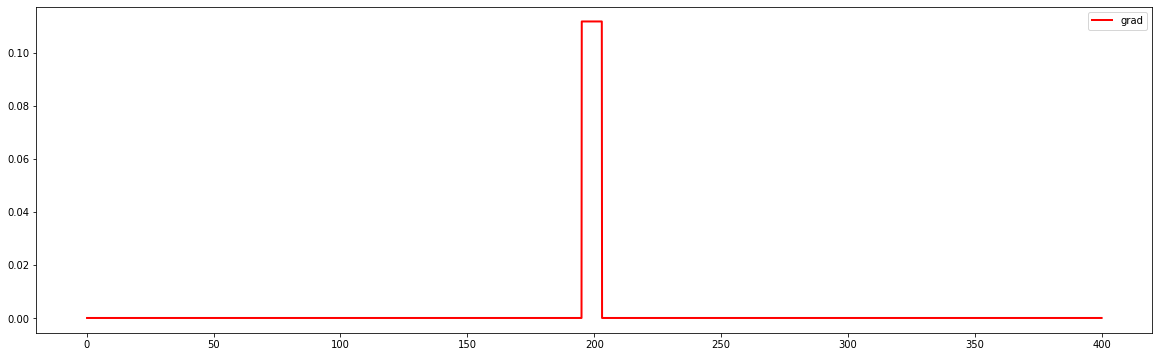

___
iteration: 80


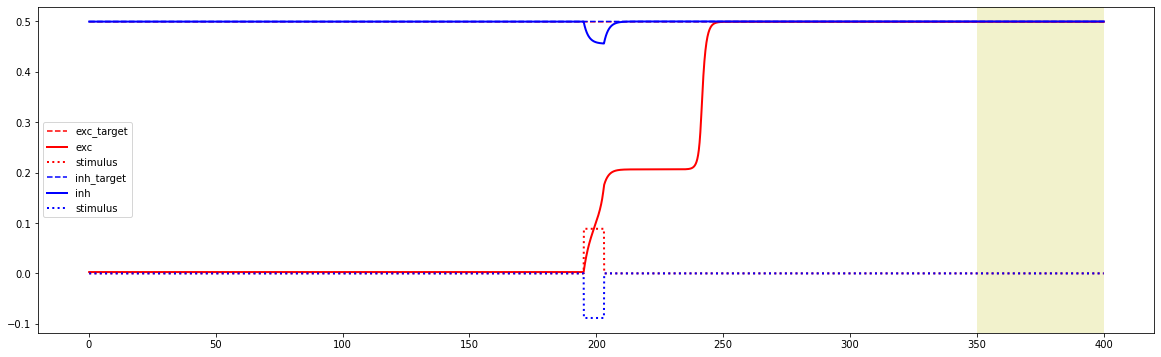

gradient:


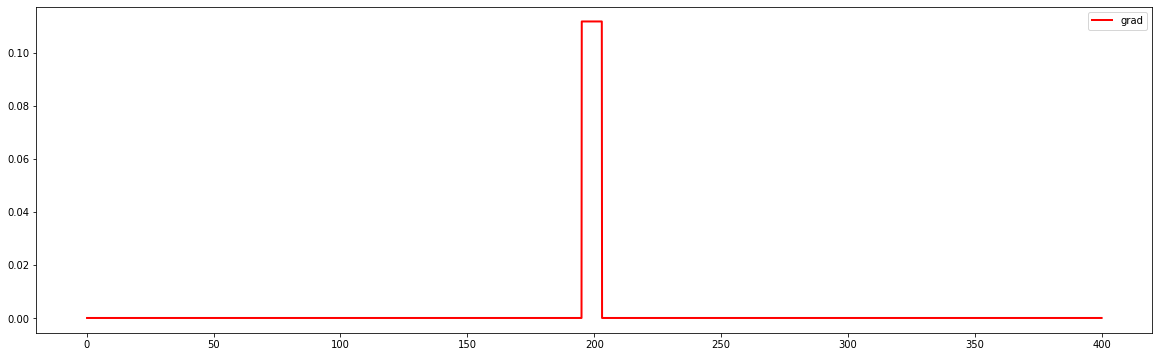

___
iteration: 100


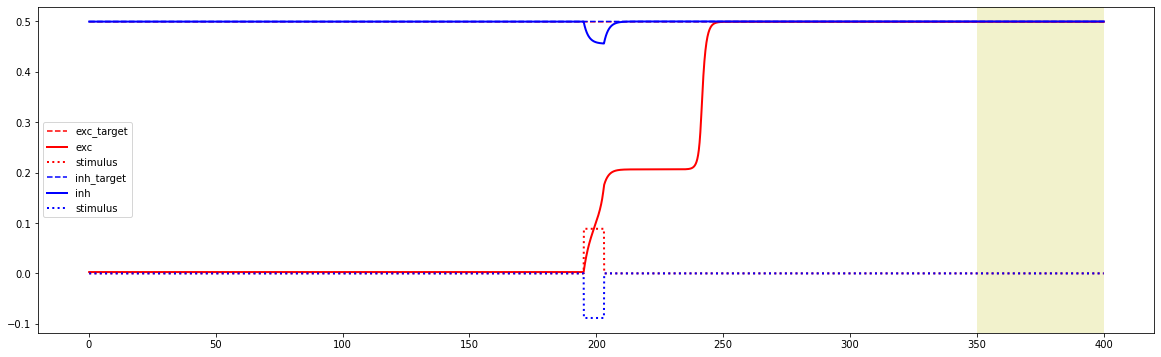

gradient:


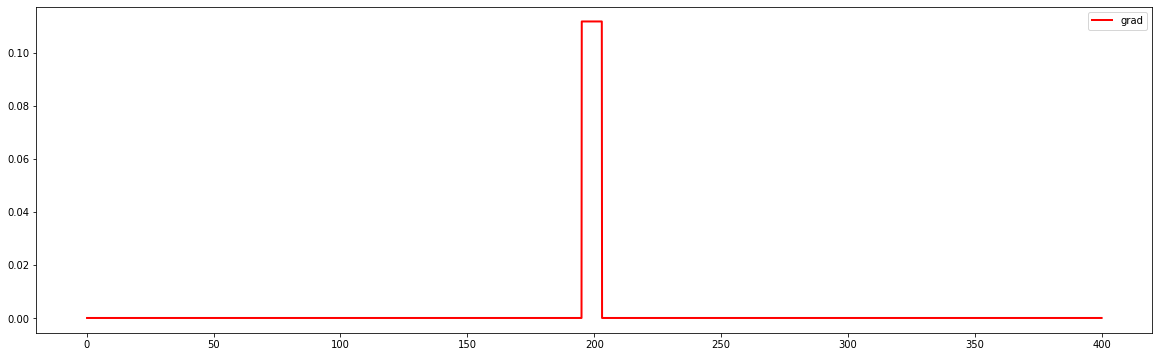

___
iteration: 120


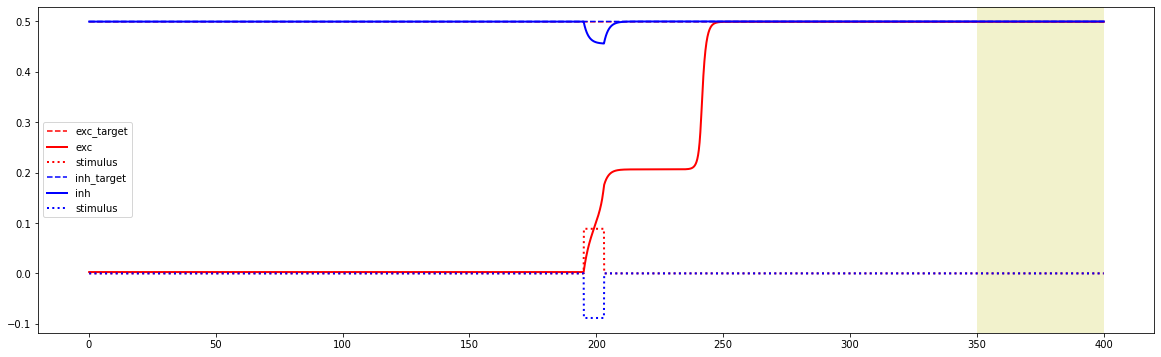

gradient:


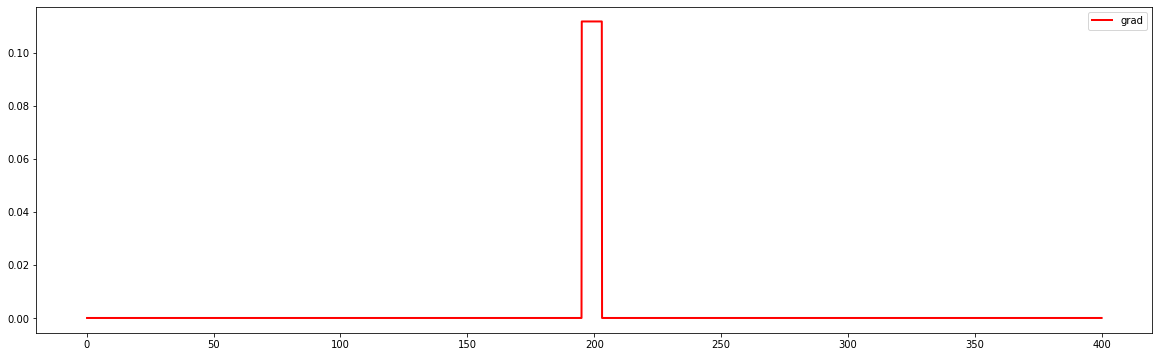

___
iteration: 140


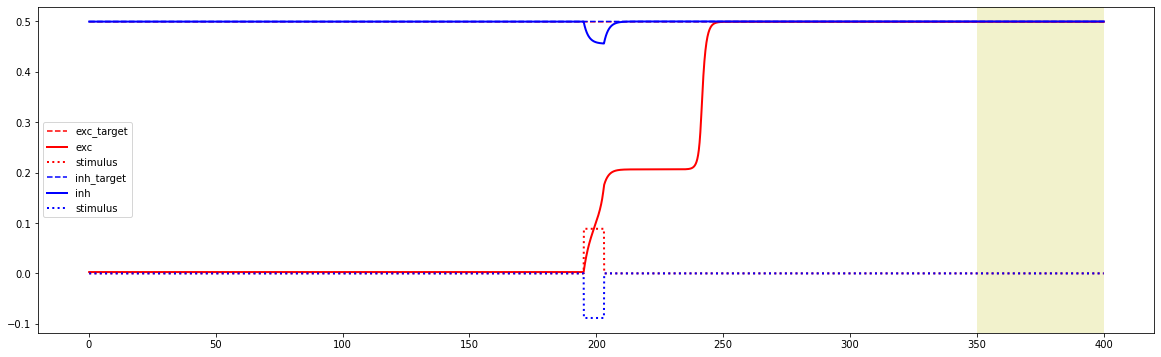

gradient:


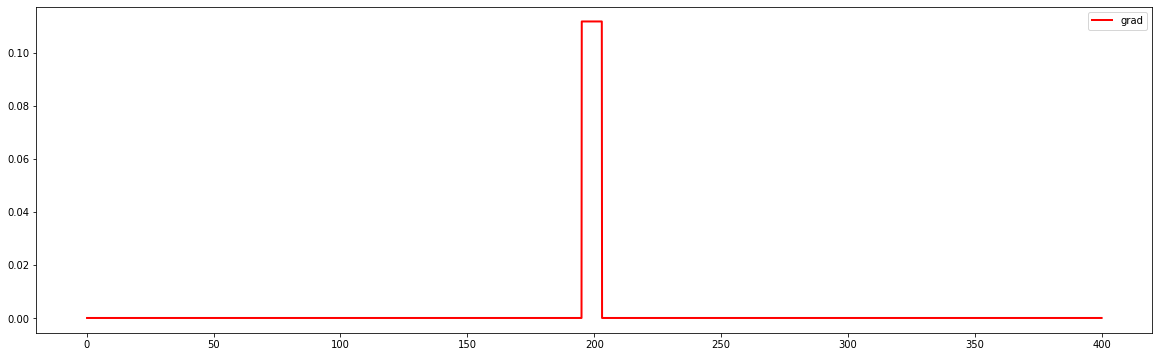

___
iteration: 160


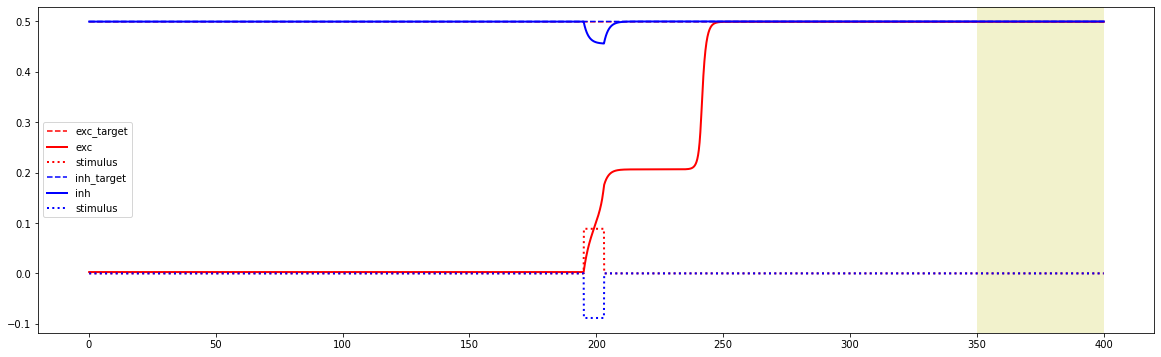

gradient:


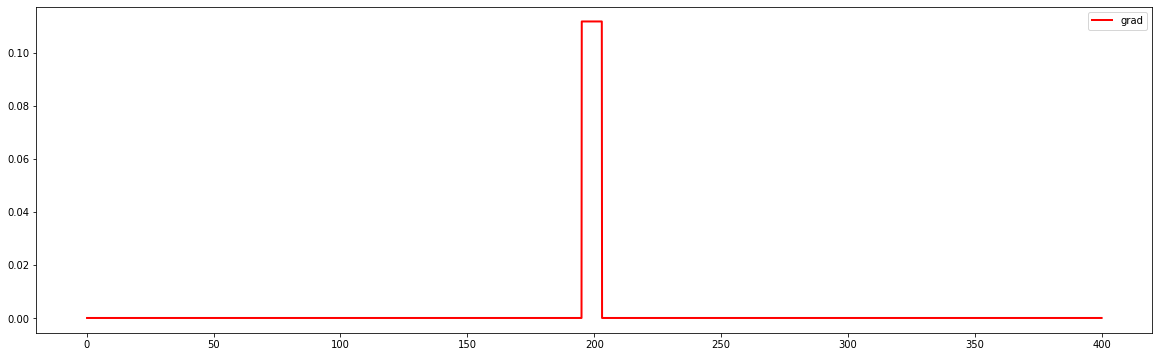

___
iteration: 180


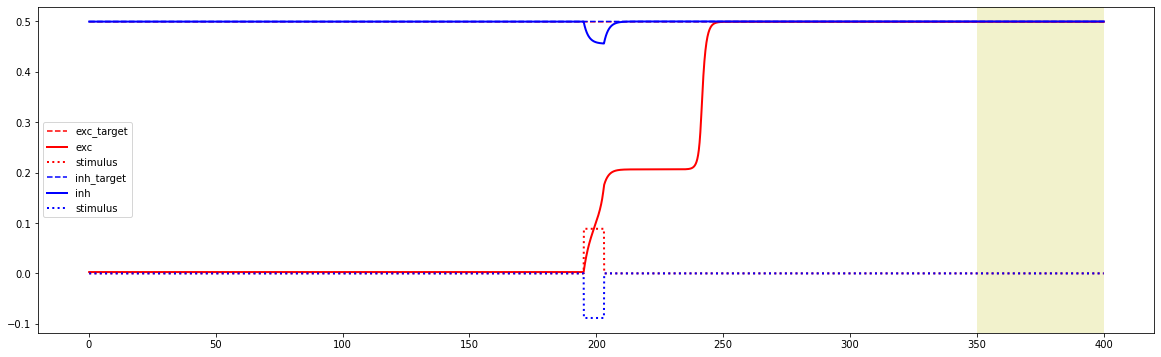

gradient:


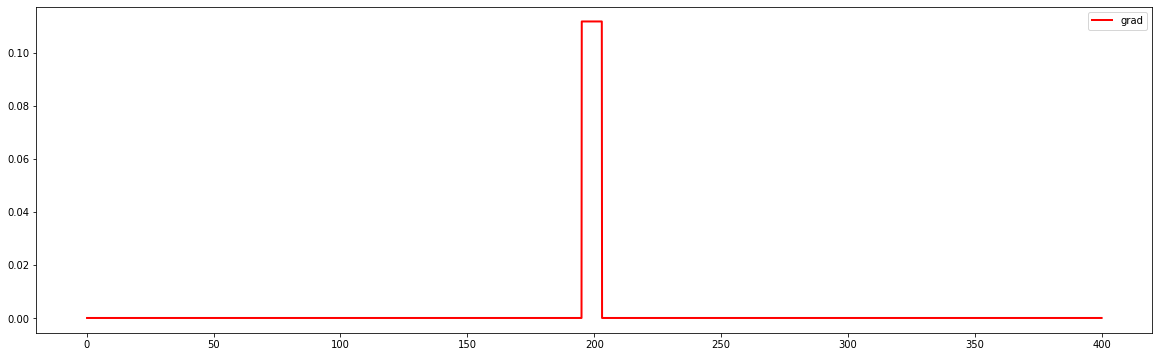

___
iteration: 200


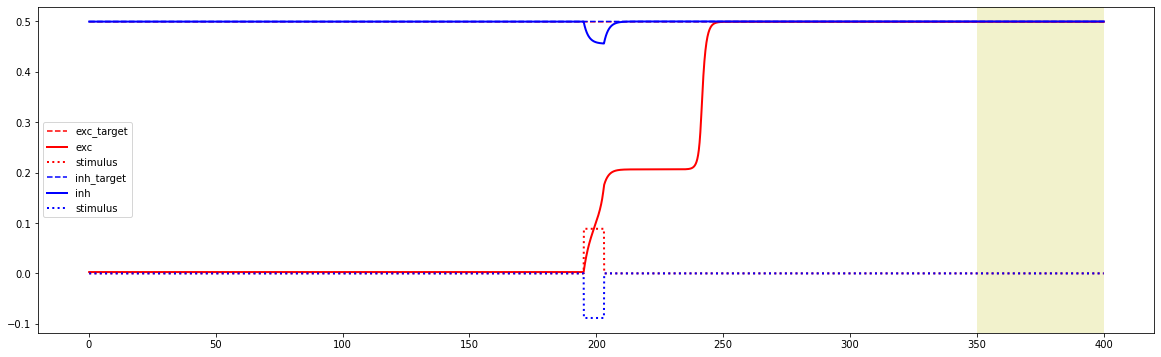

gradient:


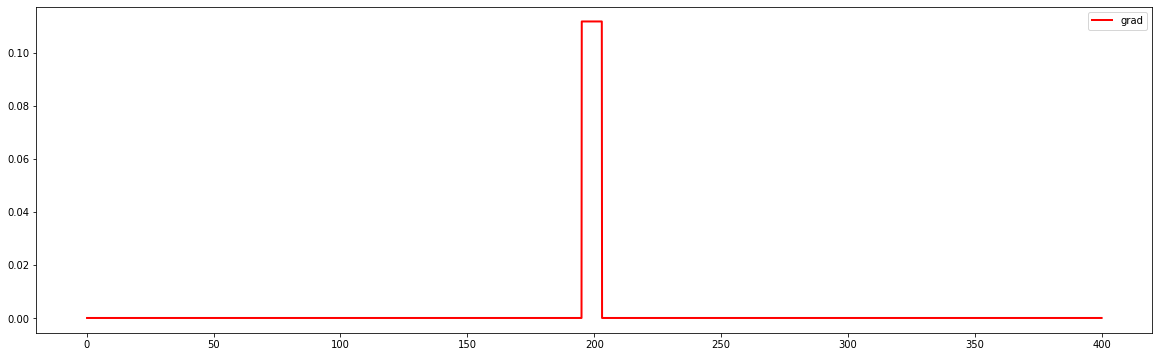

___
iteration: 220


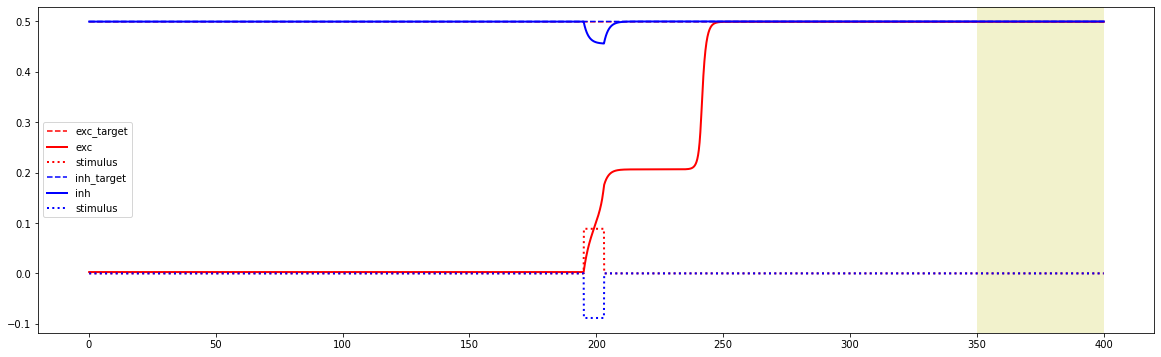

gradient:


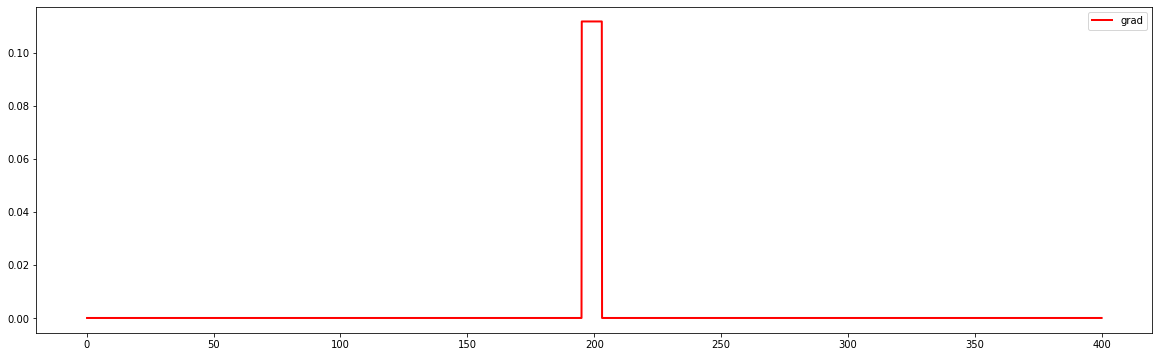

___
iteration: 240


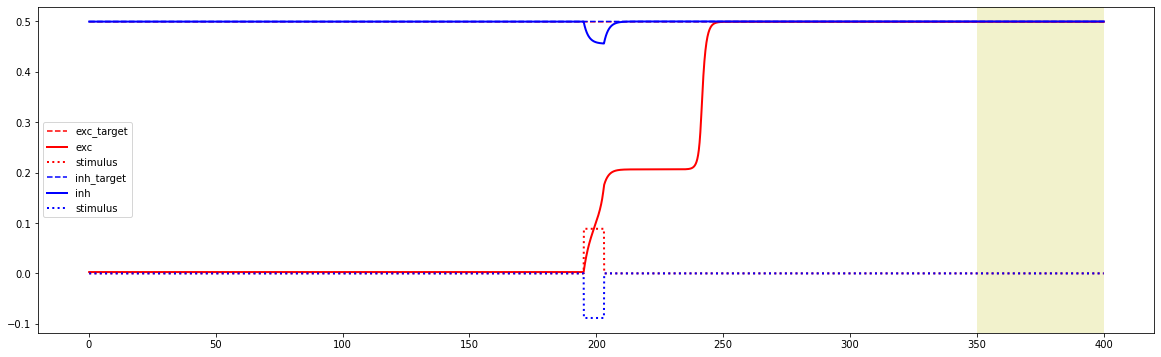

gradient:


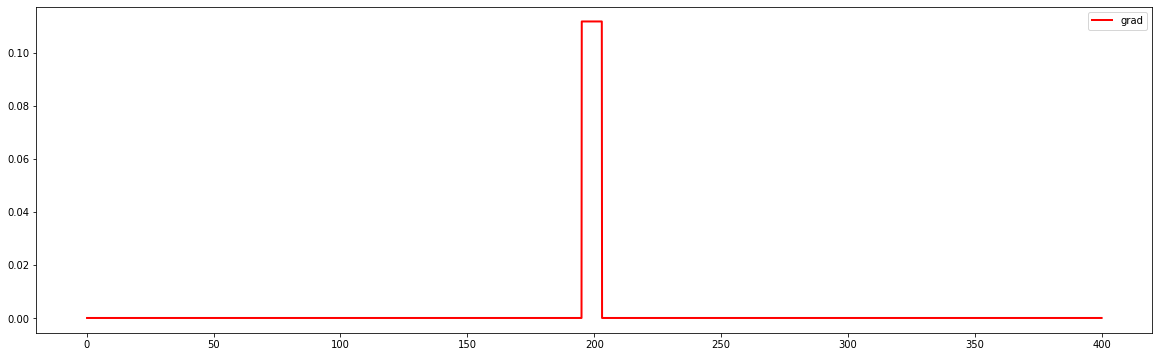

___
iteration: 260


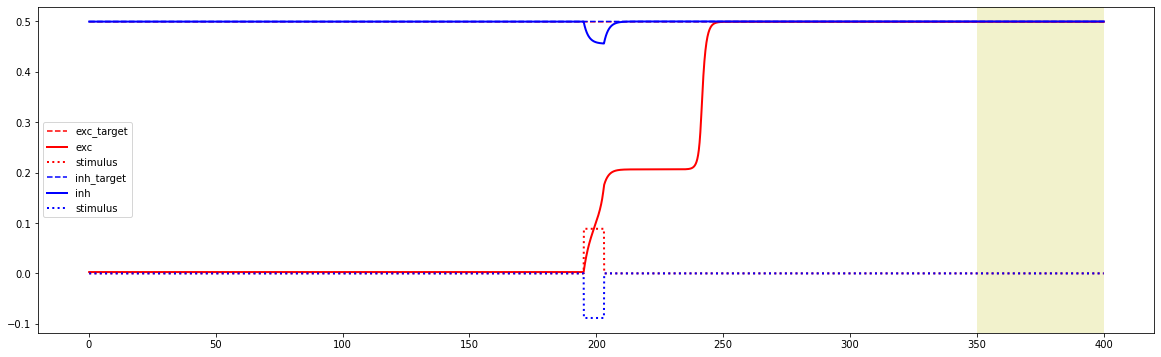

gradient:


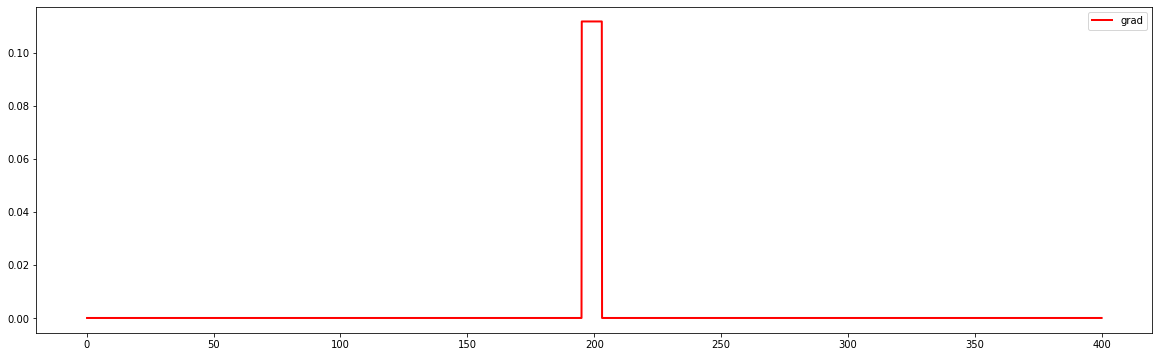

___
iteration: 280


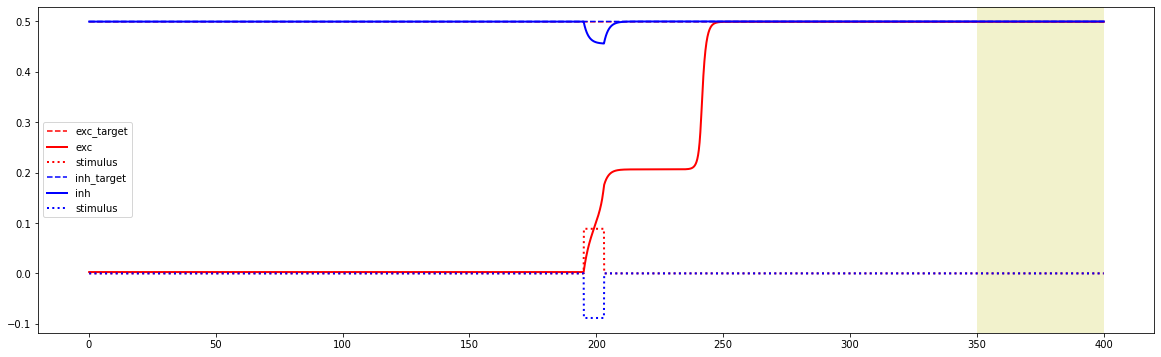

gradient:


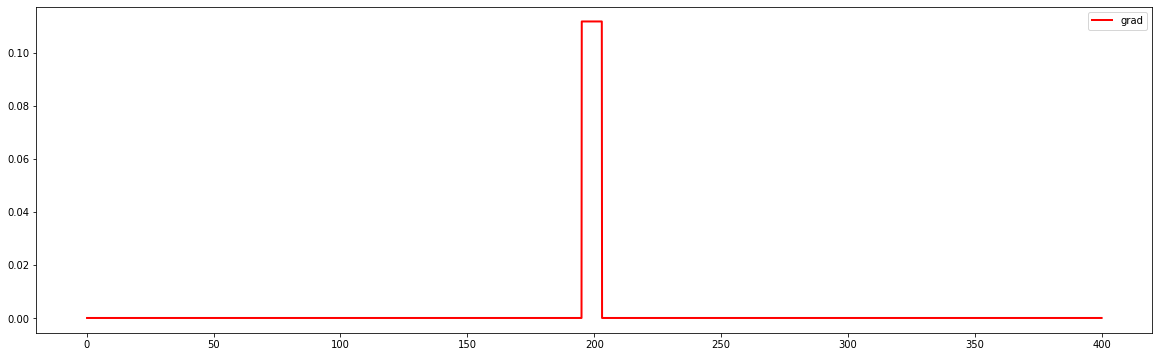

___
iteration: 300


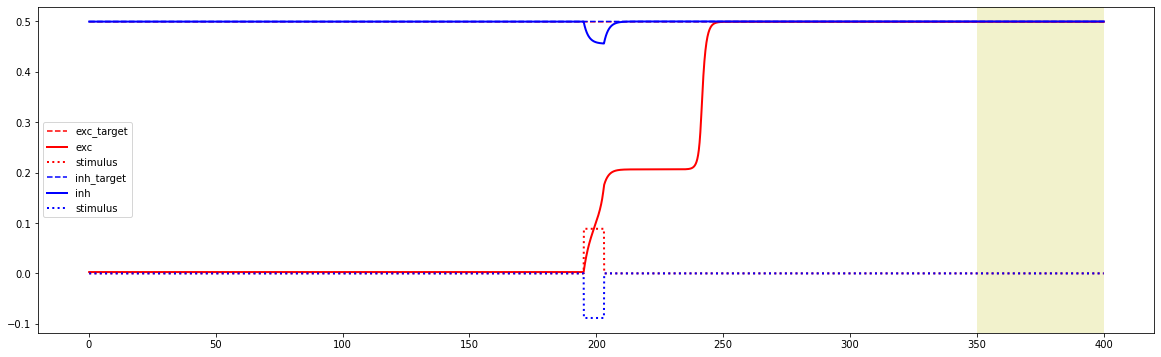

gradient:


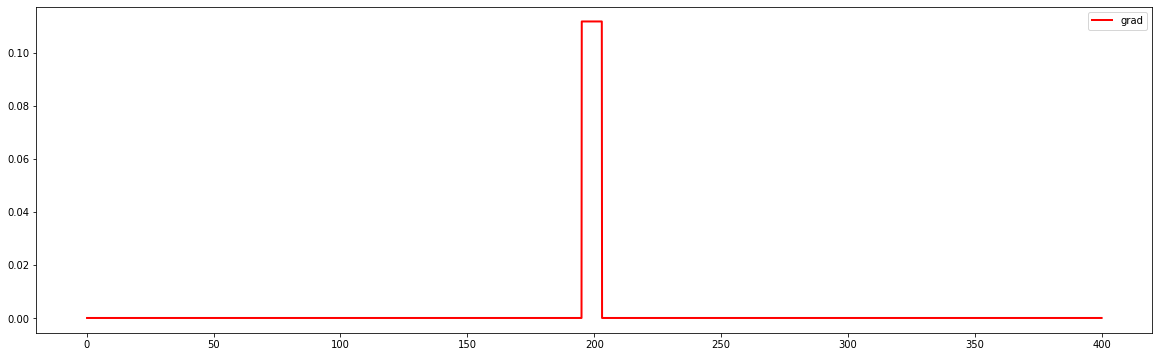

___
iteration: 320


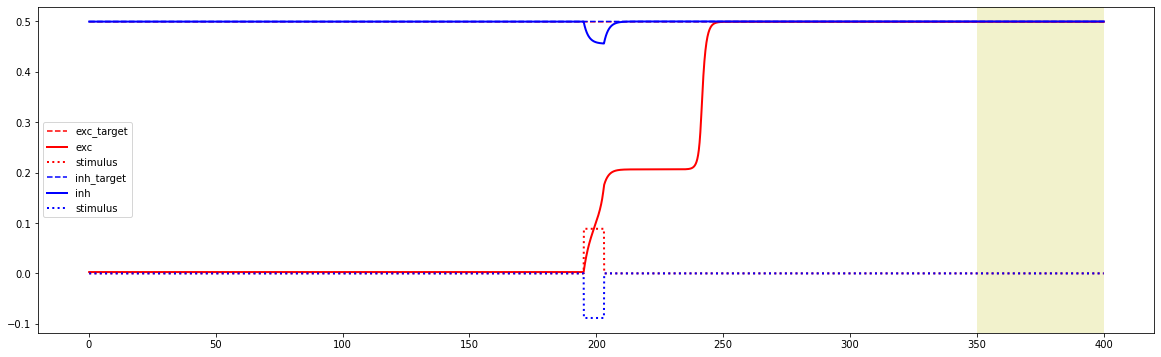

gradient:


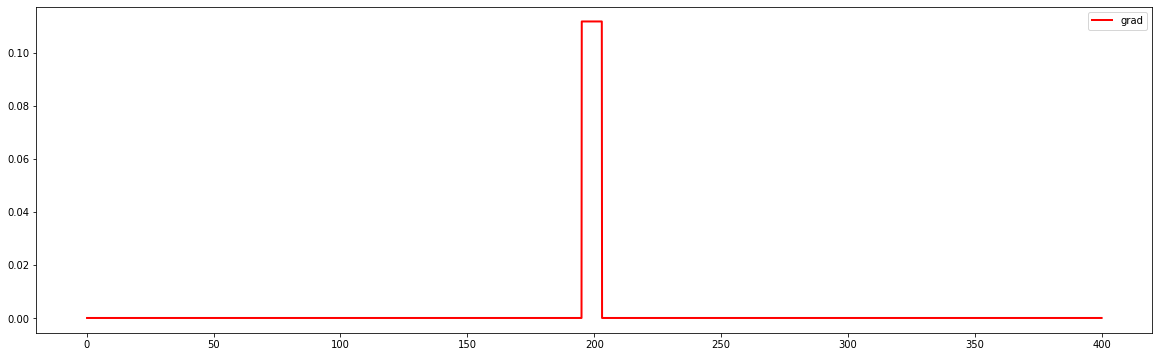

___
iteration: 340


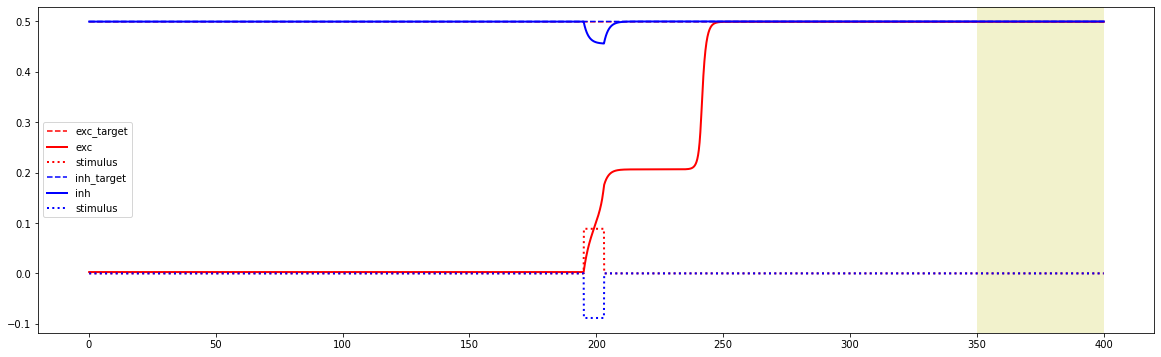

gradient:


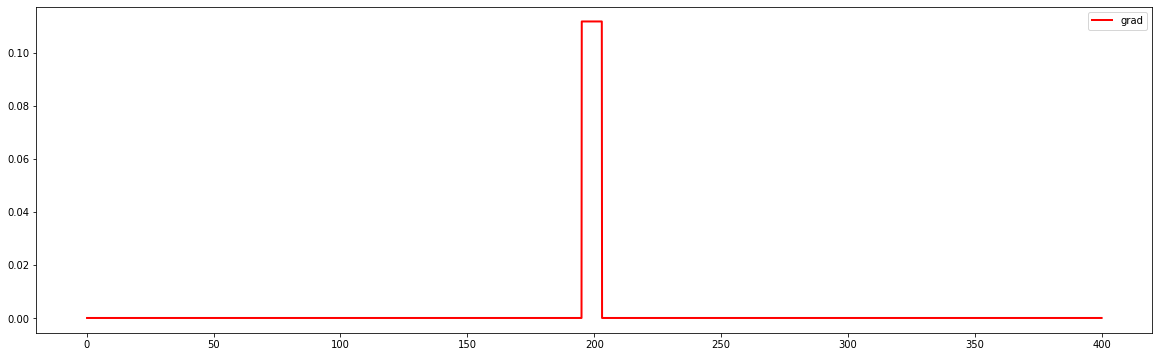

___
iteration: 360


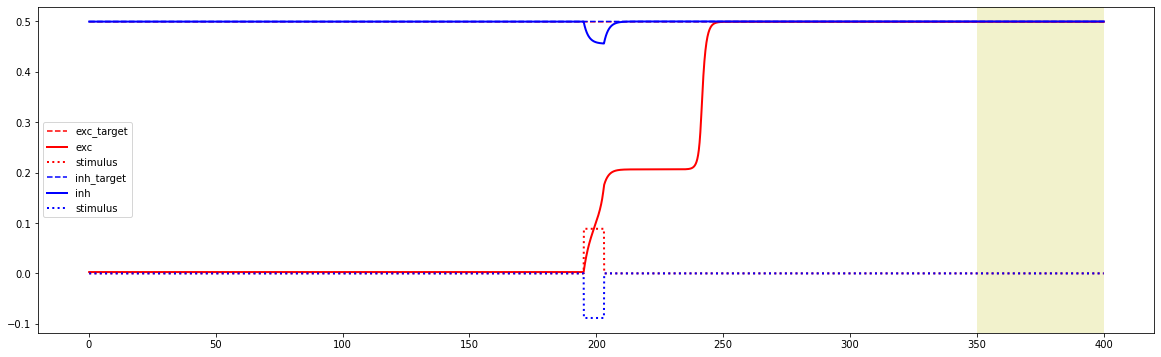

gradient:


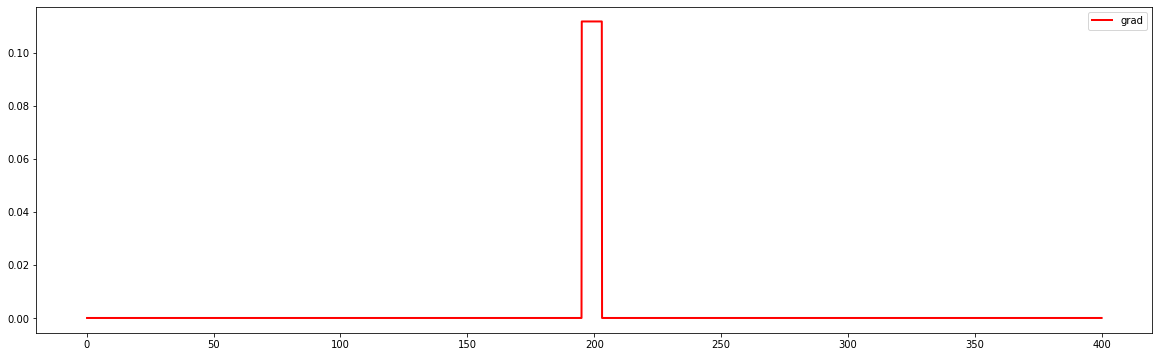

___
iteration: 380


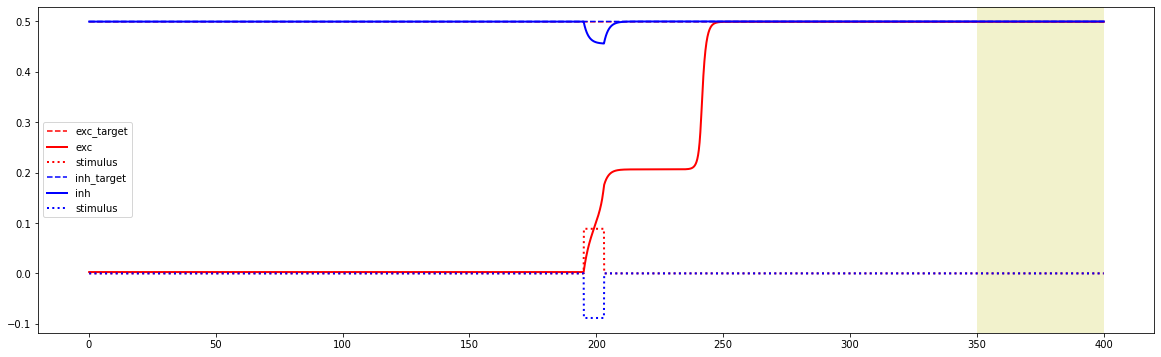

gradient:


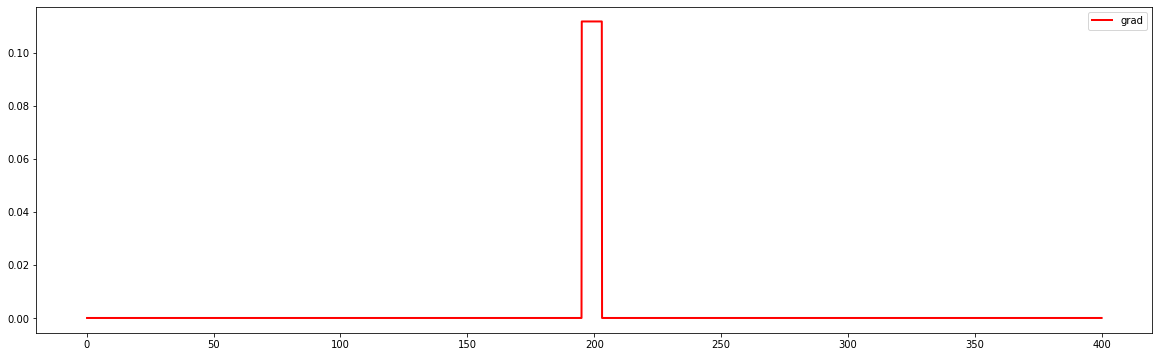

w 90
___
iteration: 0


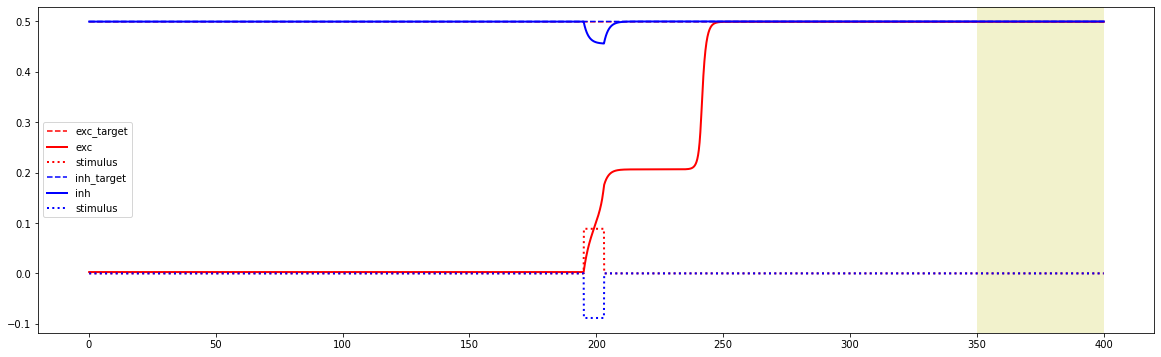

gradient:


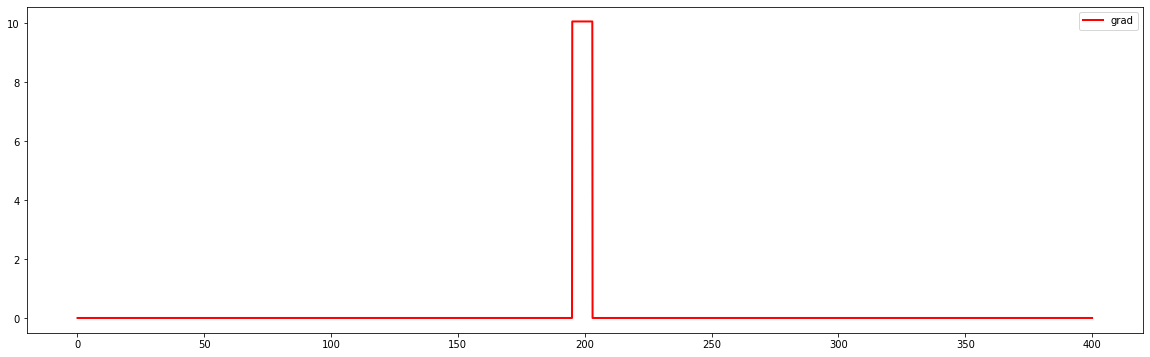

___
iteration: 20


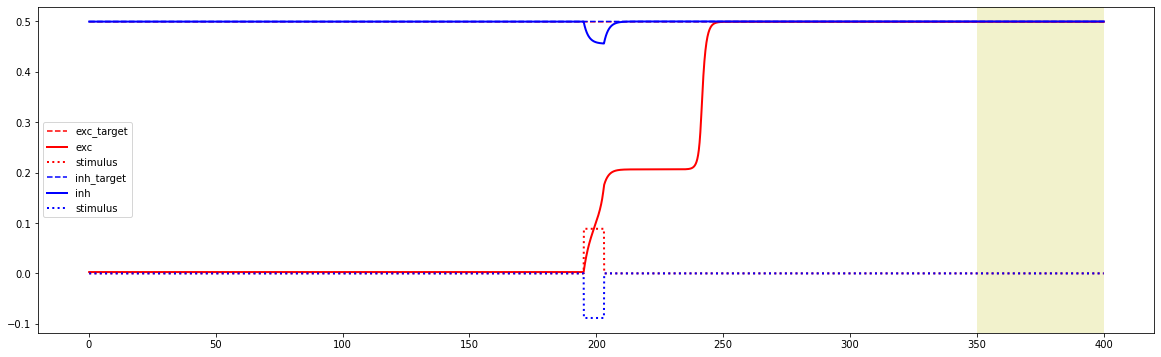

gradient:


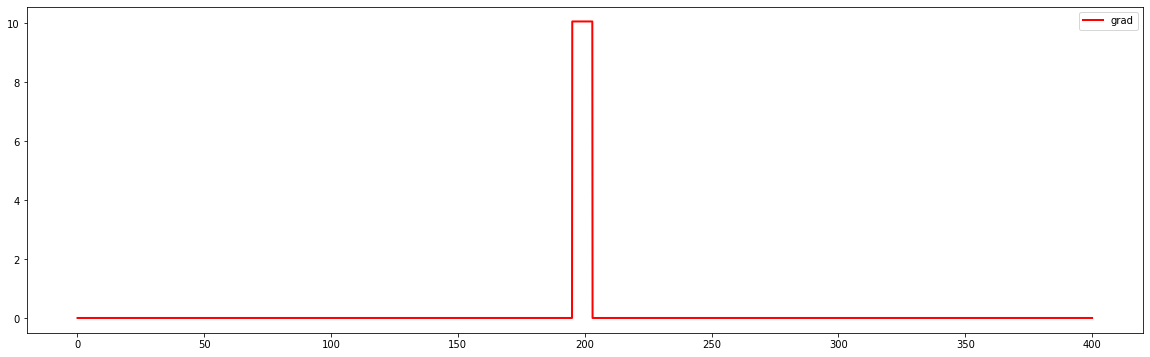

___
iteration: 40


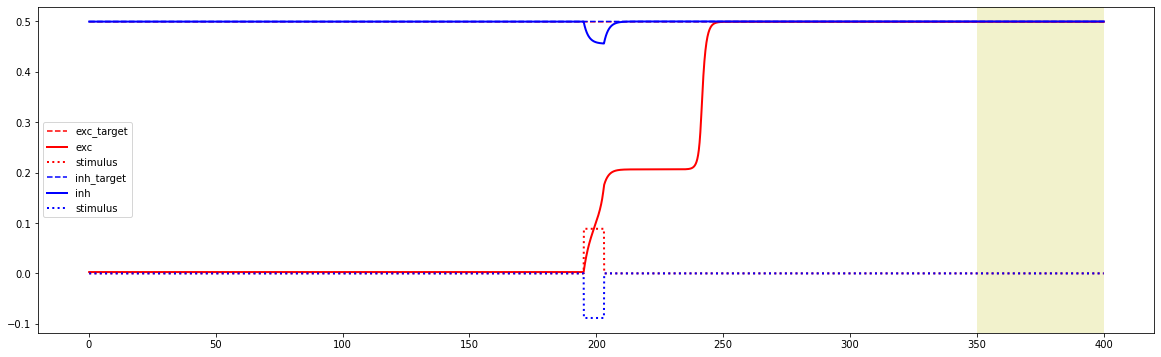

gradient:


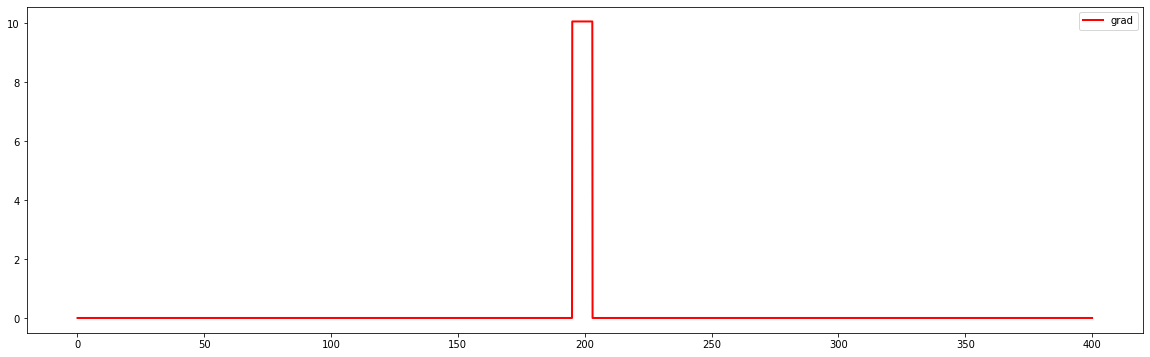

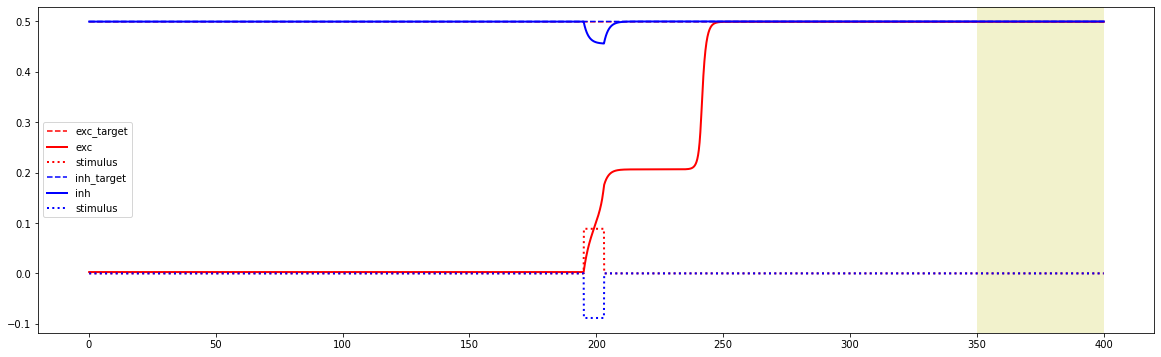

w 1
___
iteration: 0


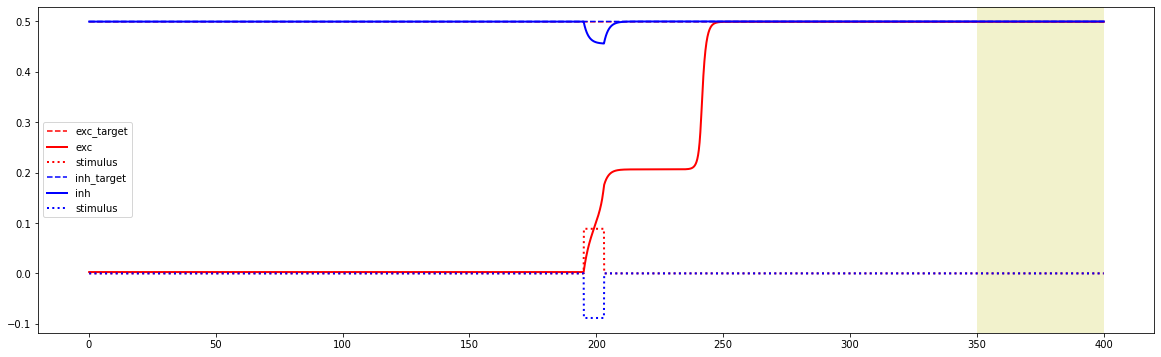

gradient:


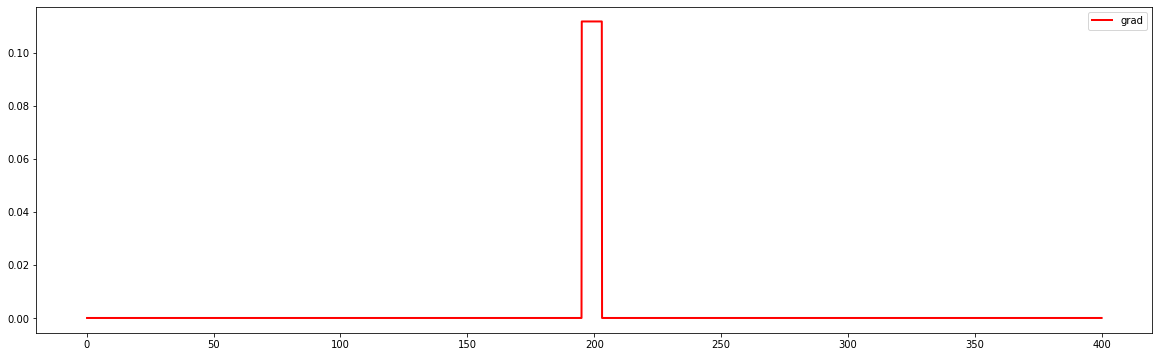

___
iteration: 20


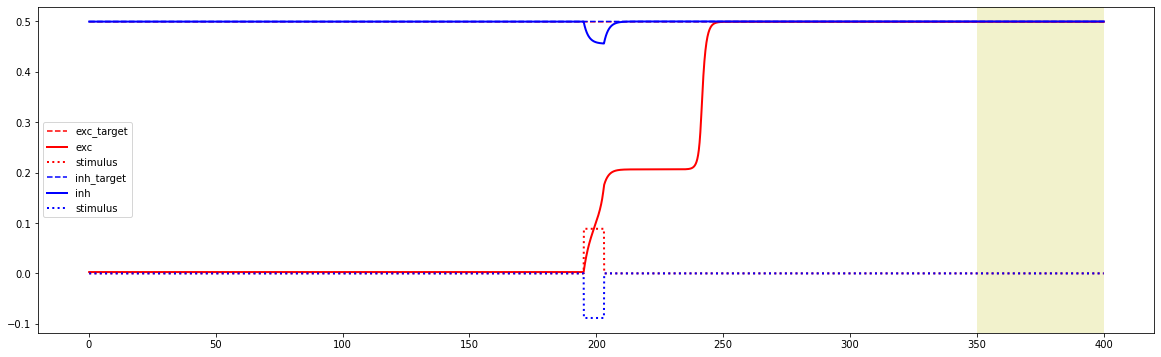

gradient:


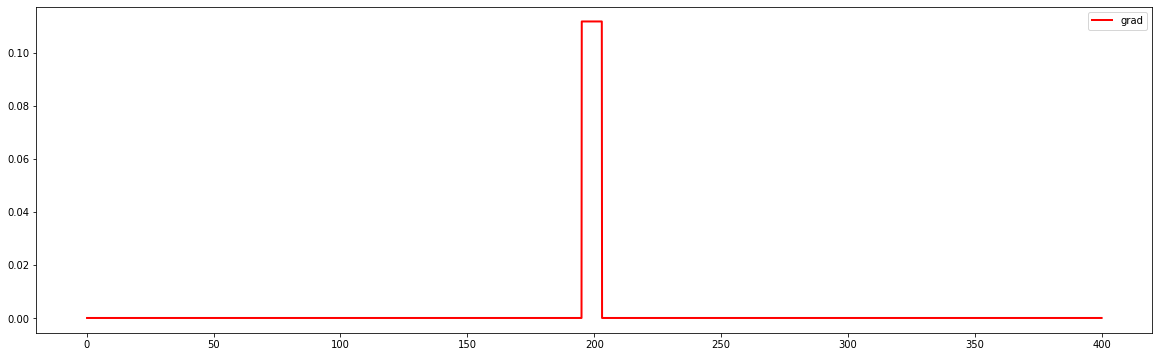

___
iteration: 40


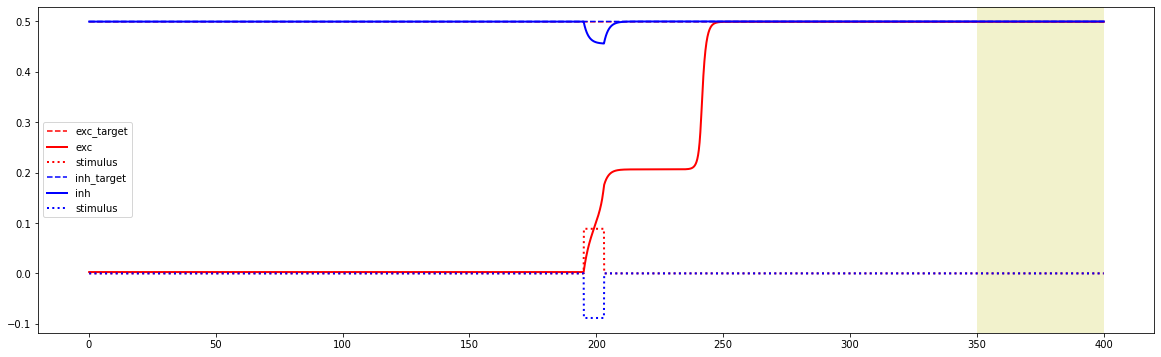

gradient:


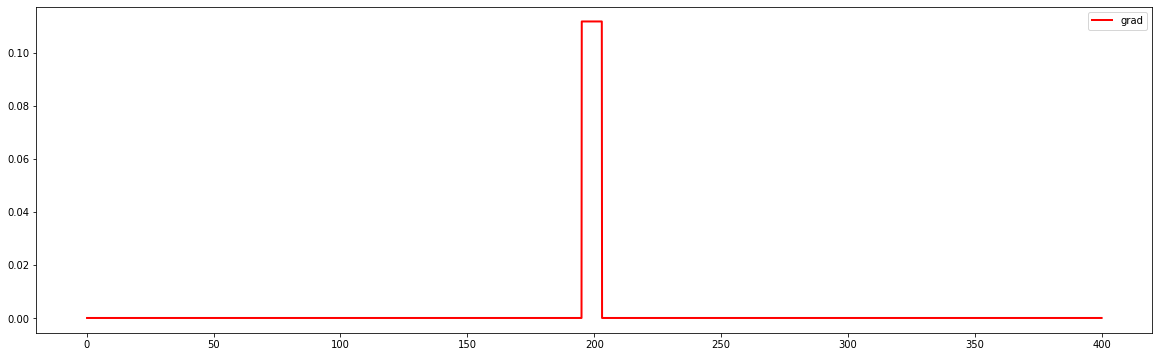

___
iteration: 60


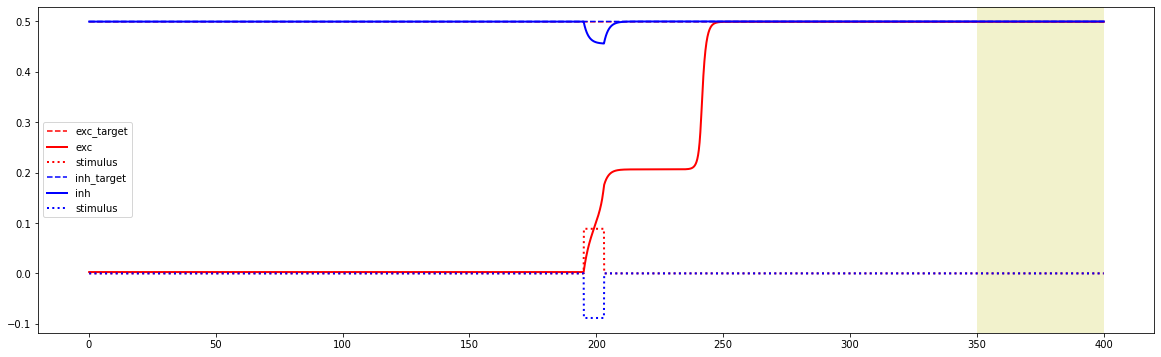

gradient:


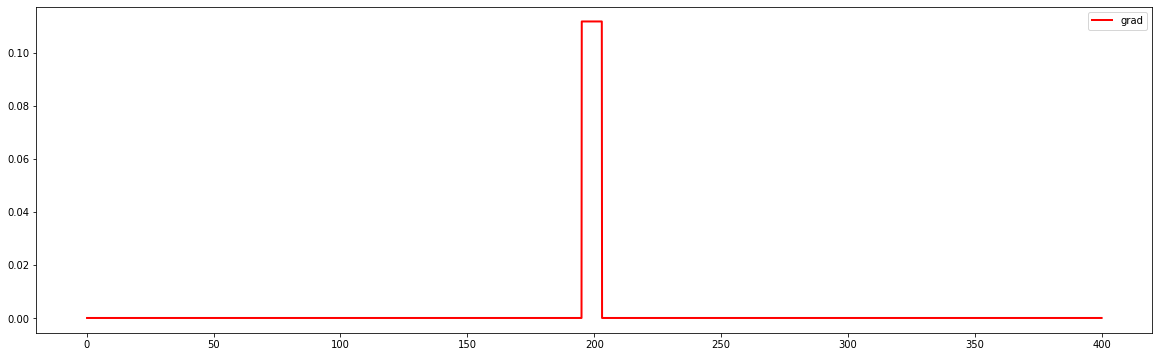

___
iteration: 80


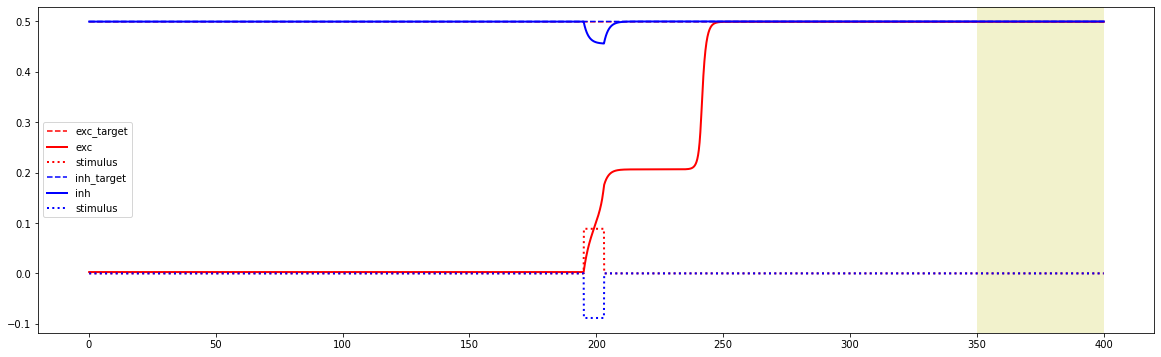

gradient:


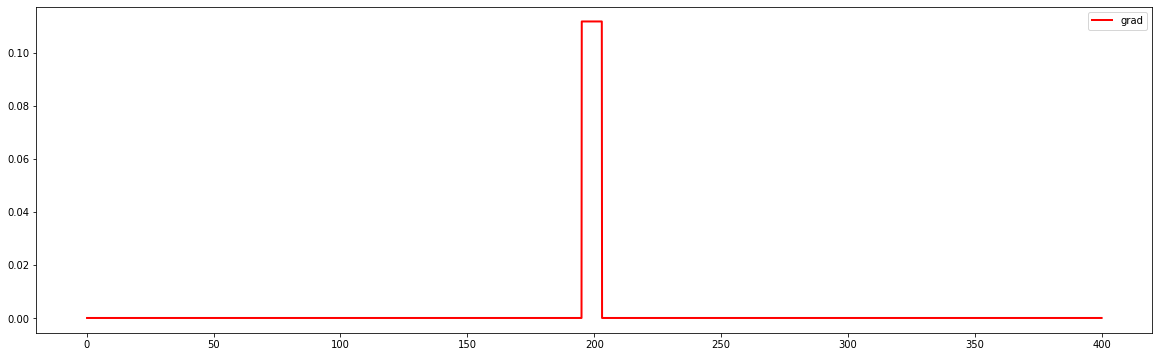

___
iteration: 100


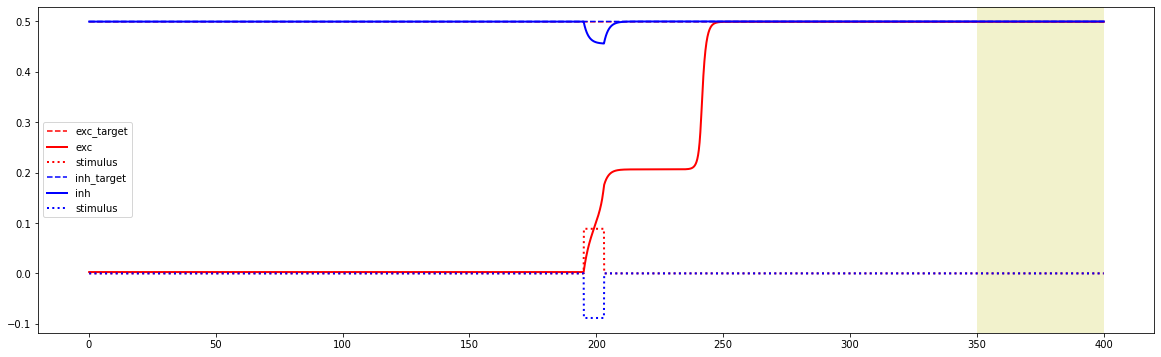

gradient:


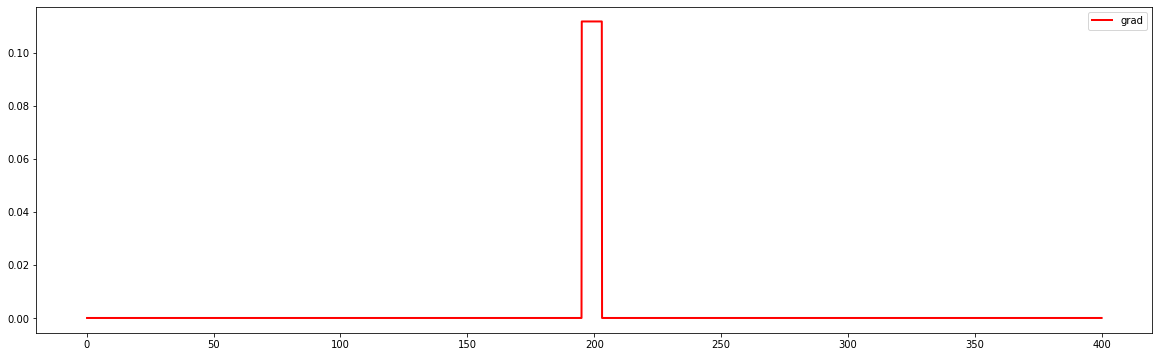

___
iteration: 120


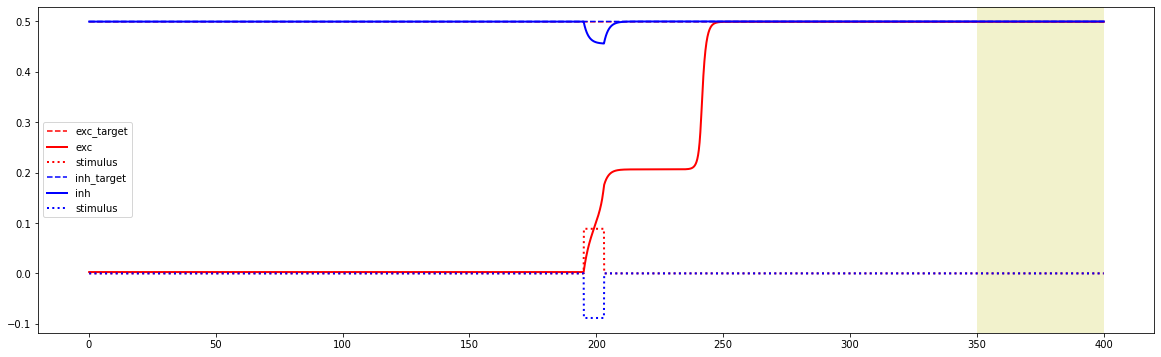

gradient:


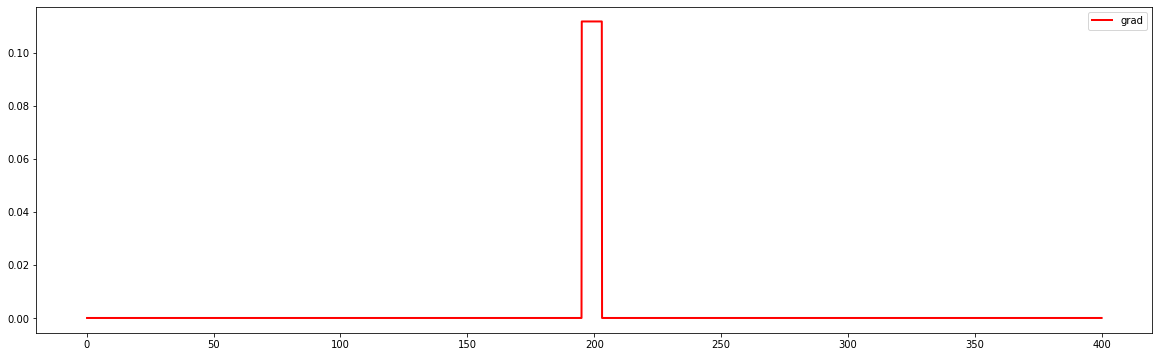

___
iteration: 140


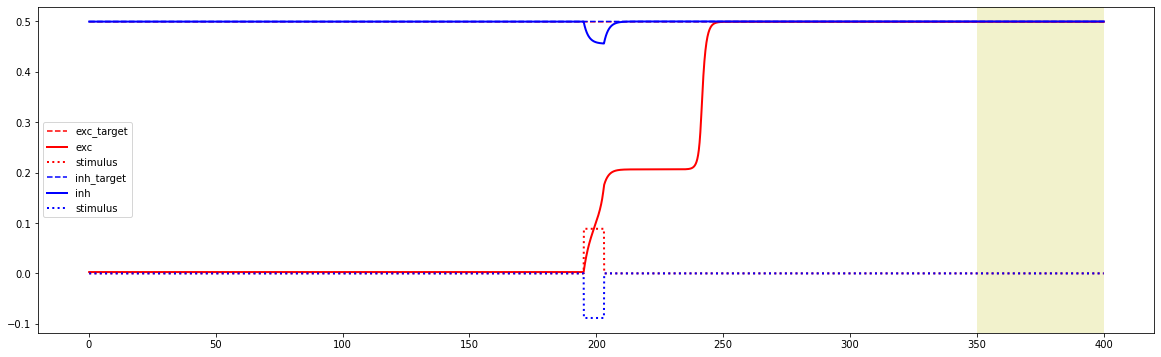

gradient:


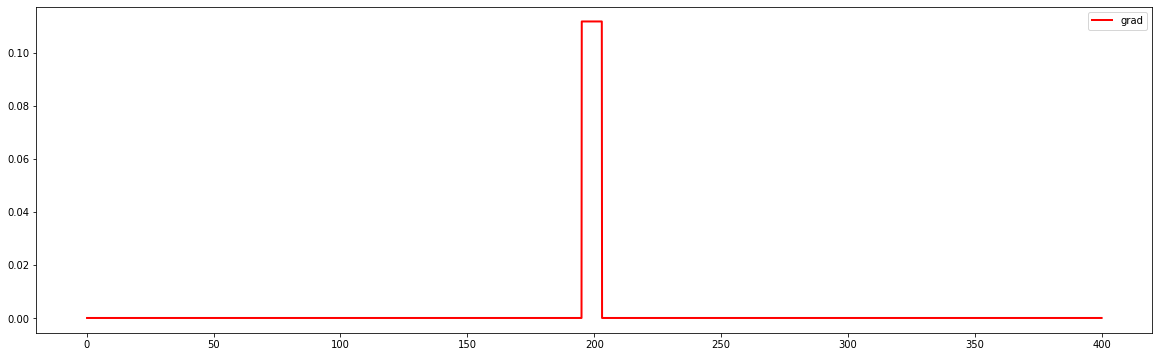

___
iteration: 160


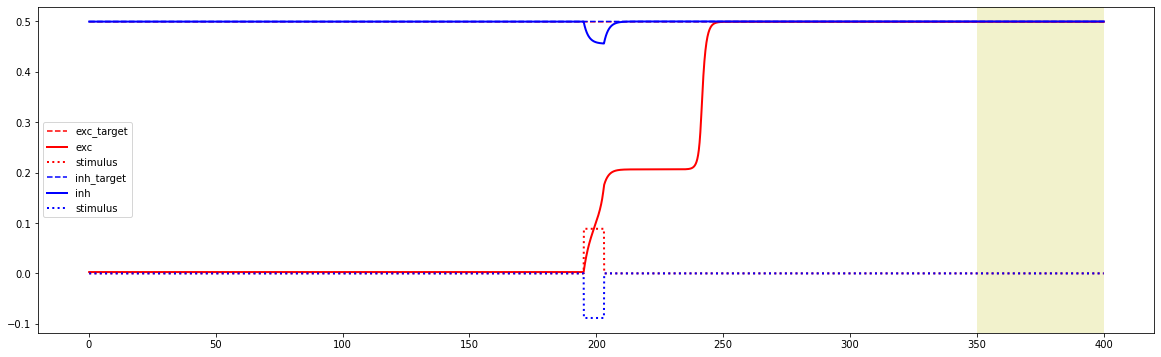

gradient:


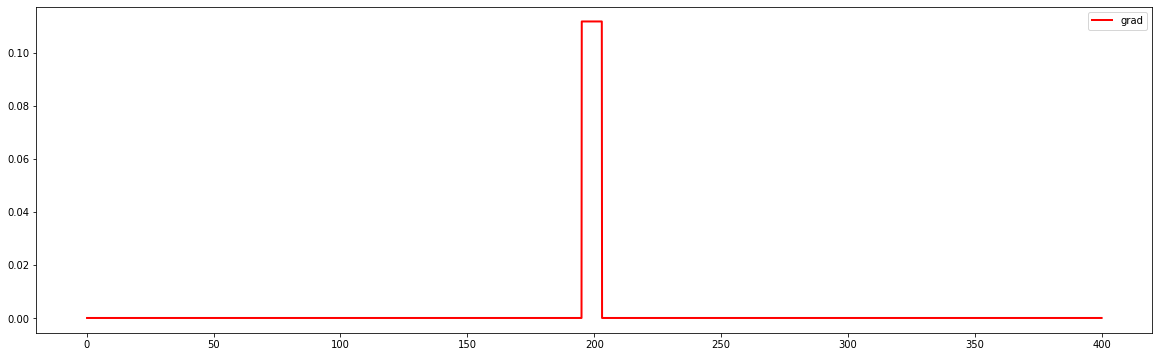

___
iteration: 180


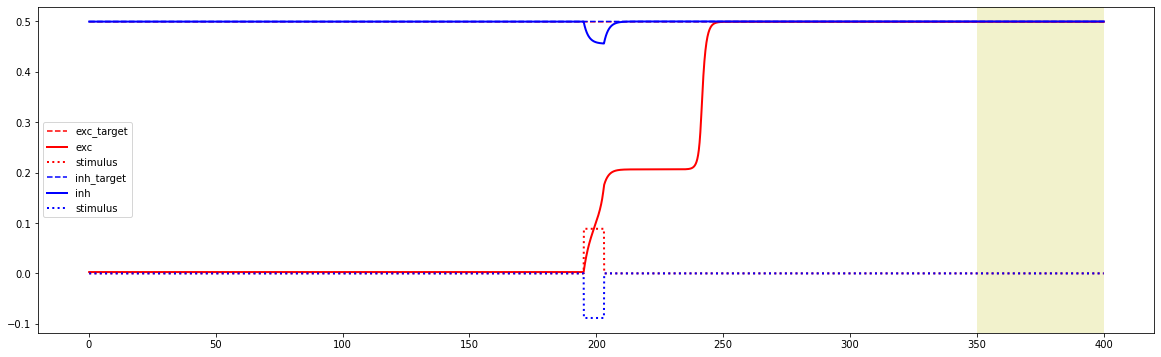

gradient:


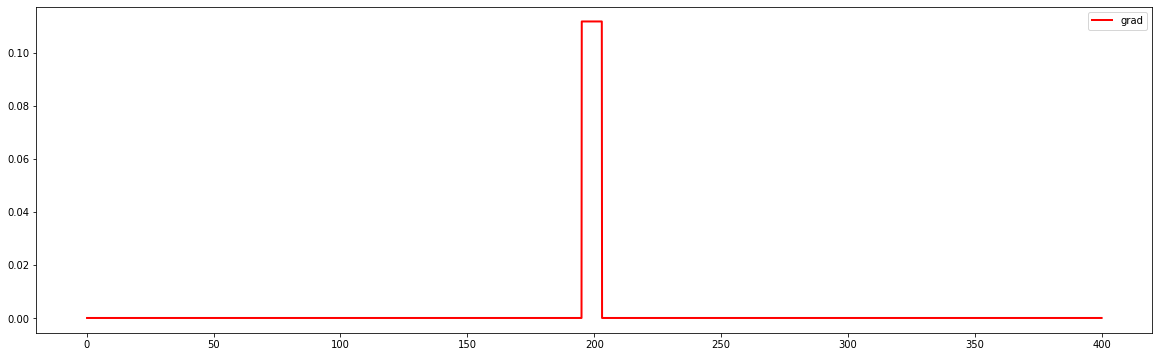

___
iteration: 200


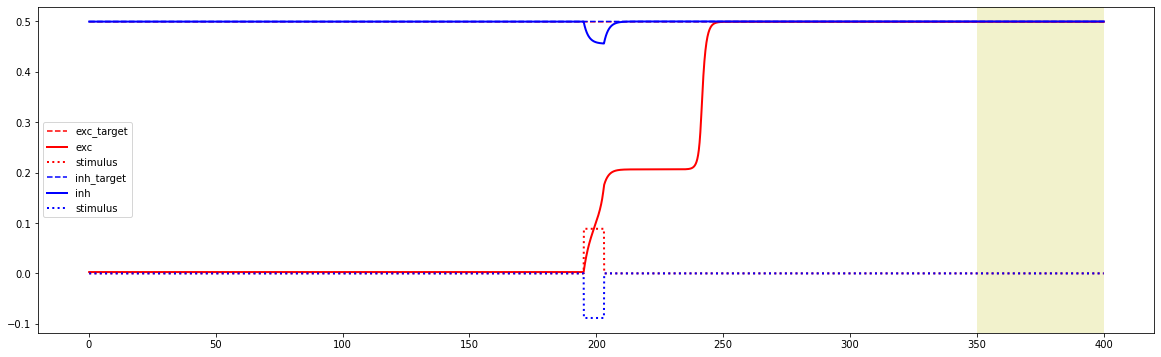

gradient:


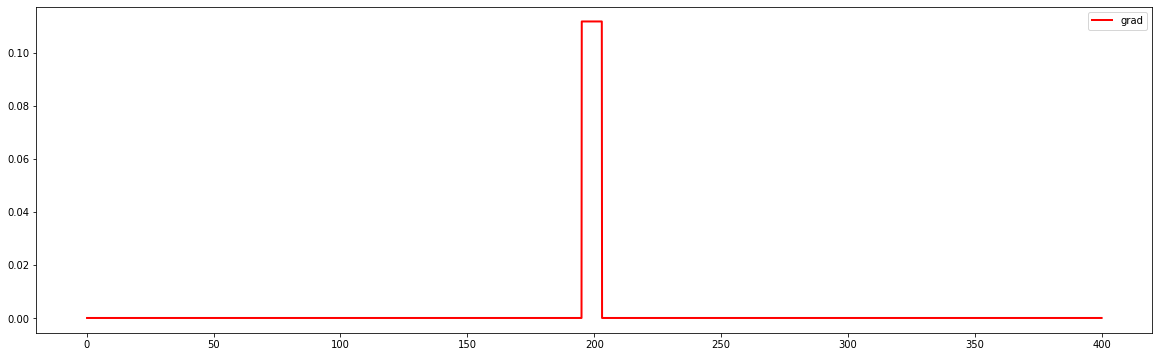

___
iteration: 220


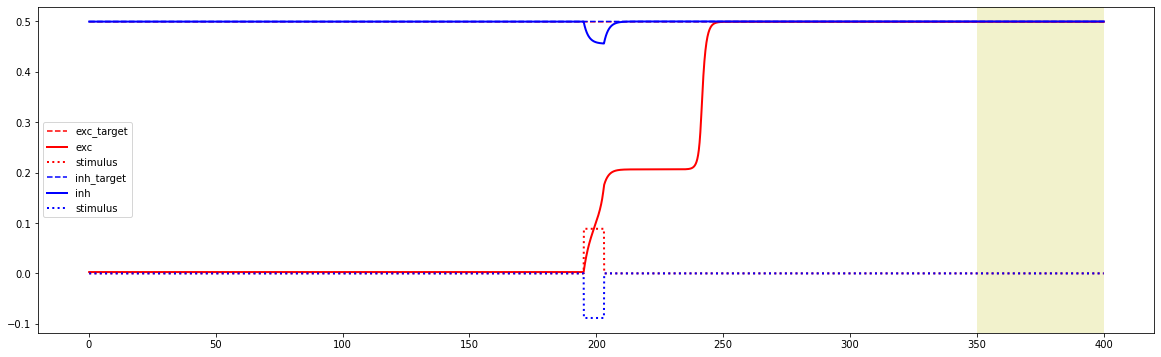

gradient:


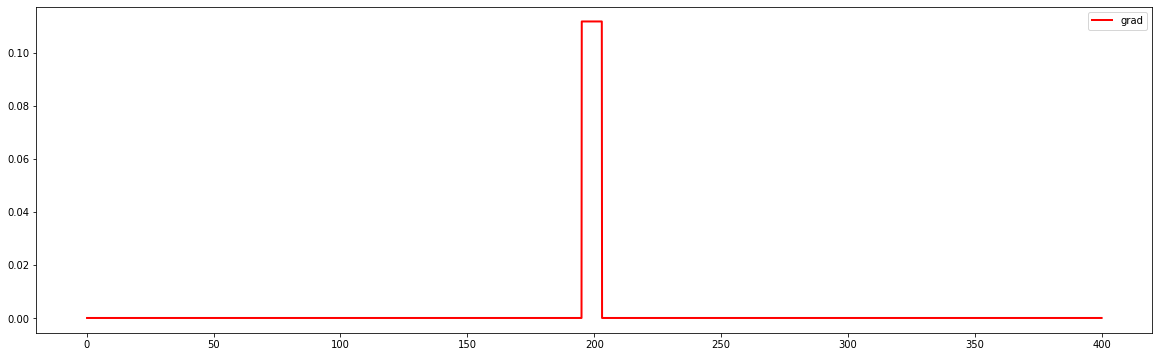

___
iteration: 240


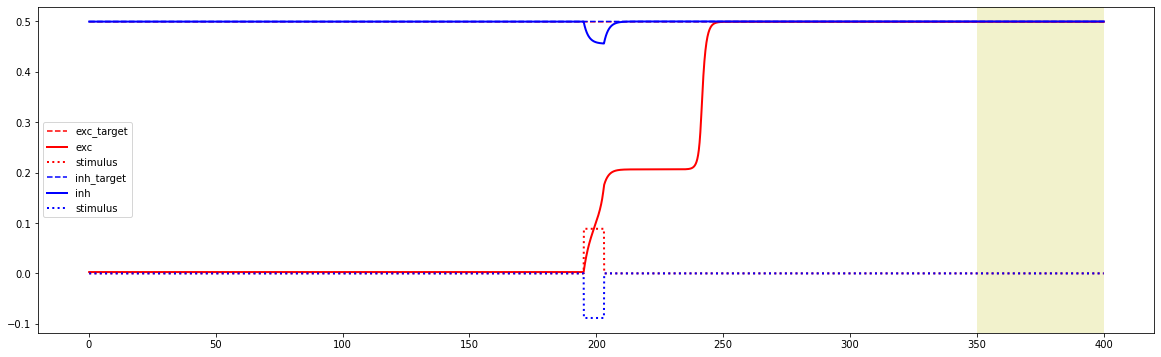

gradient:


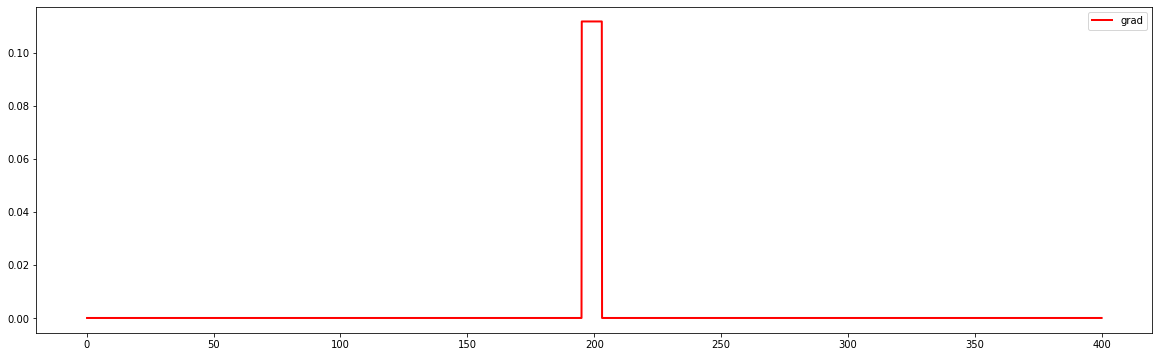

___
iteration: 260


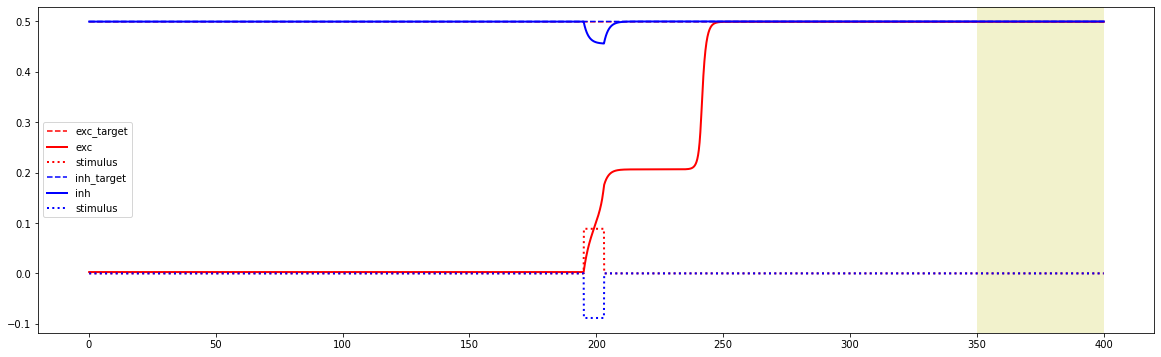

gradient:


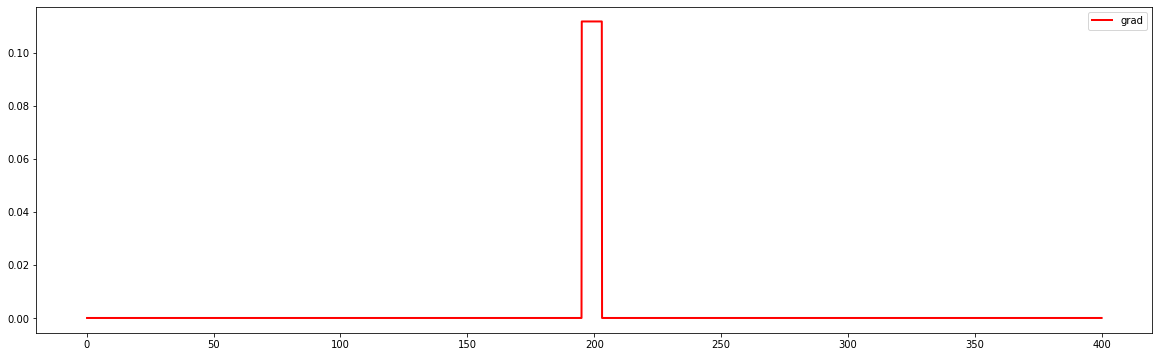

___
iteration: 280


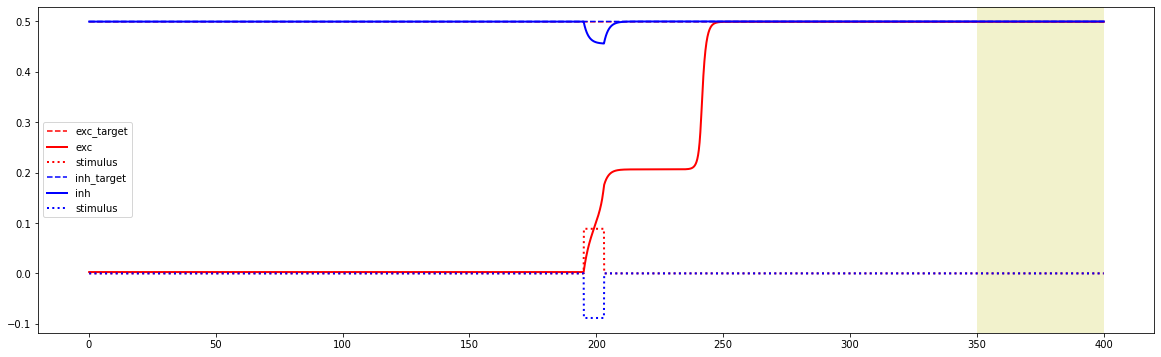

gradient:


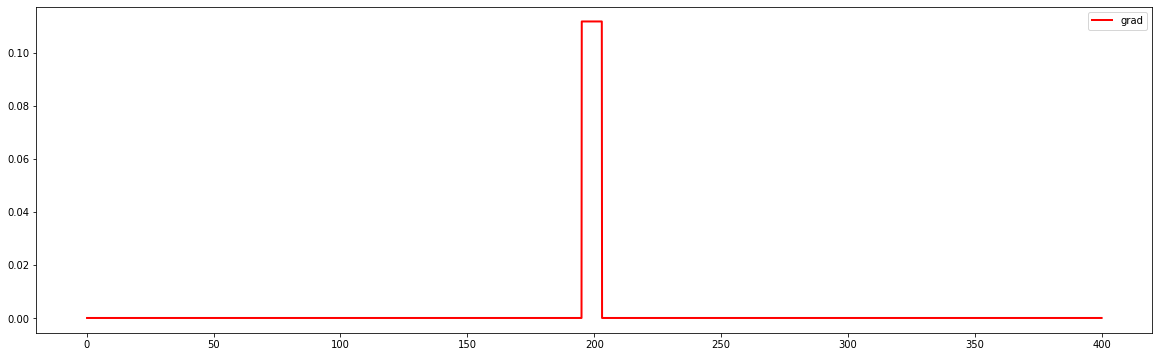

___
iteration: 300


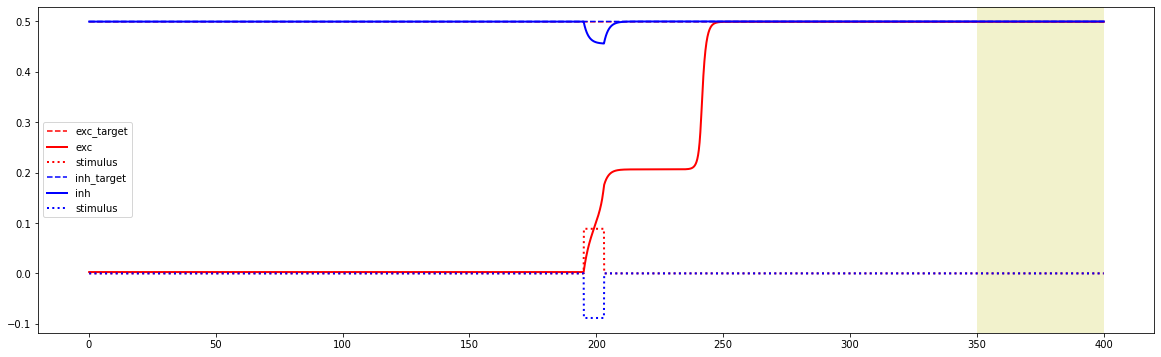

gradient:


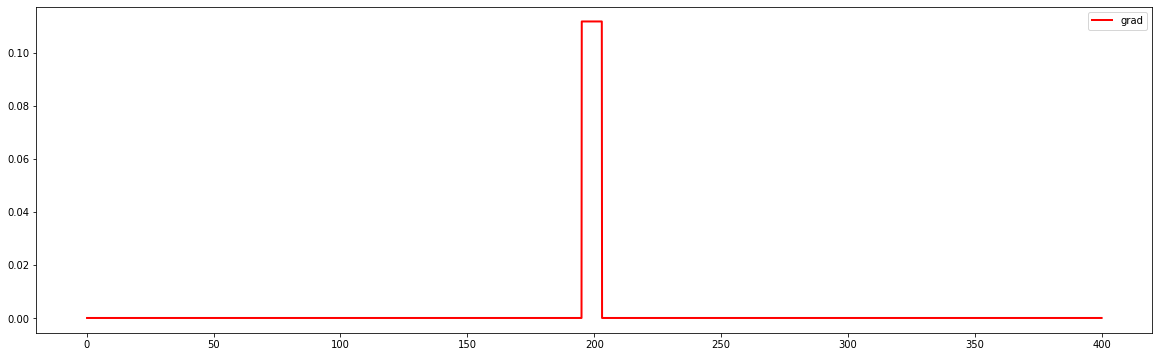

___
iteration: 320


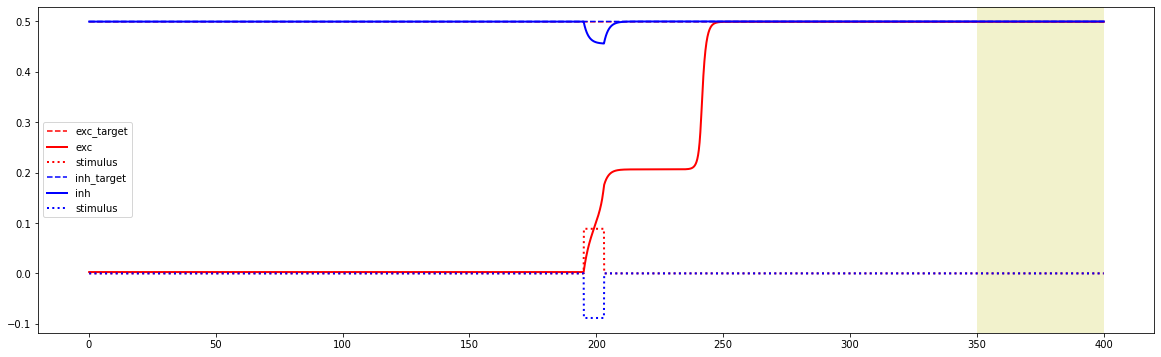

gradient:


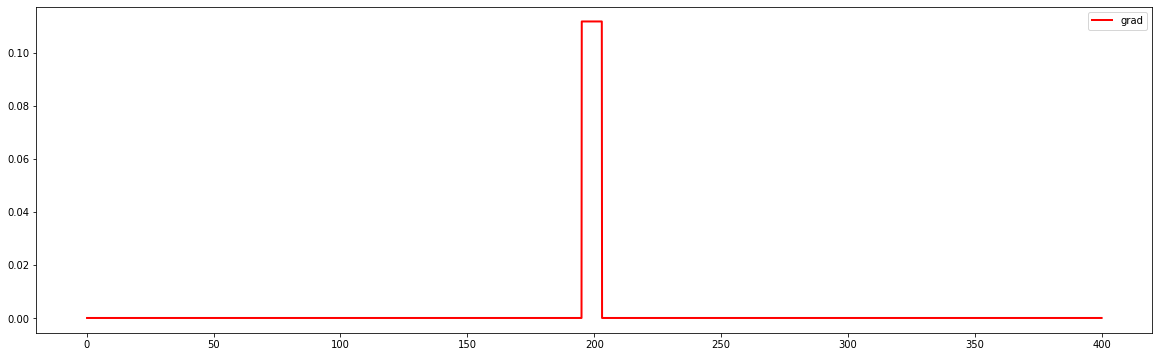

___
iteration: 340


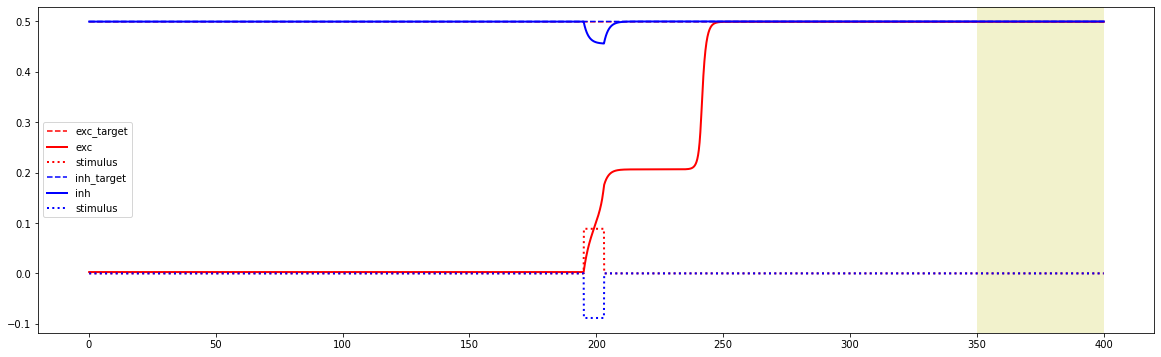

gradient:


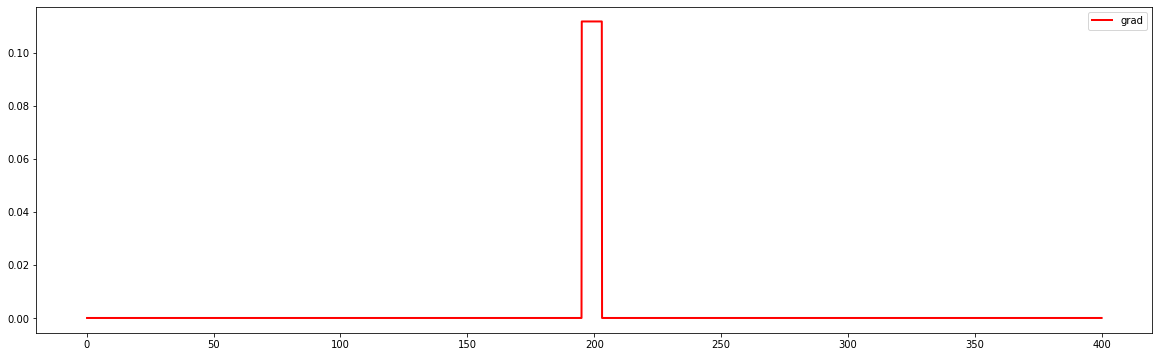

___
iteration: 360


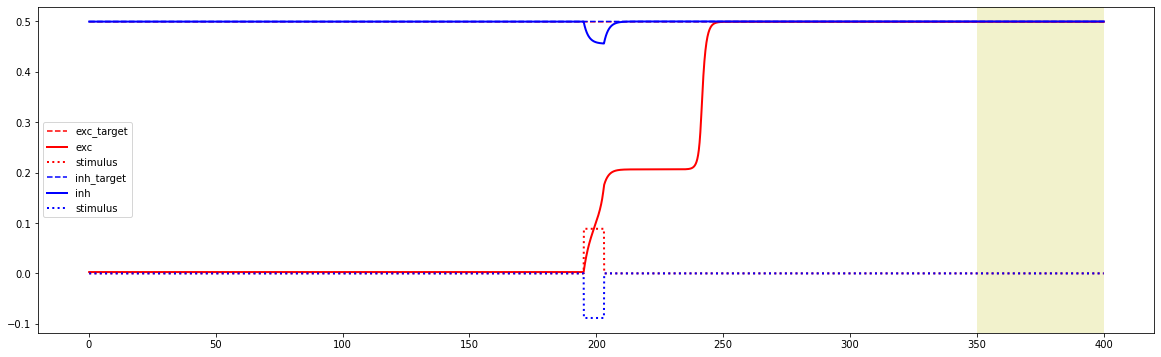

gradient:


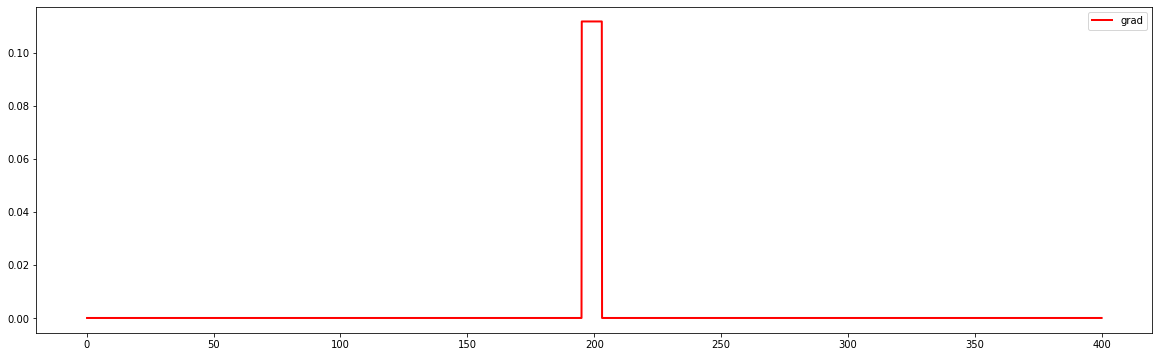

___
iteration: 380


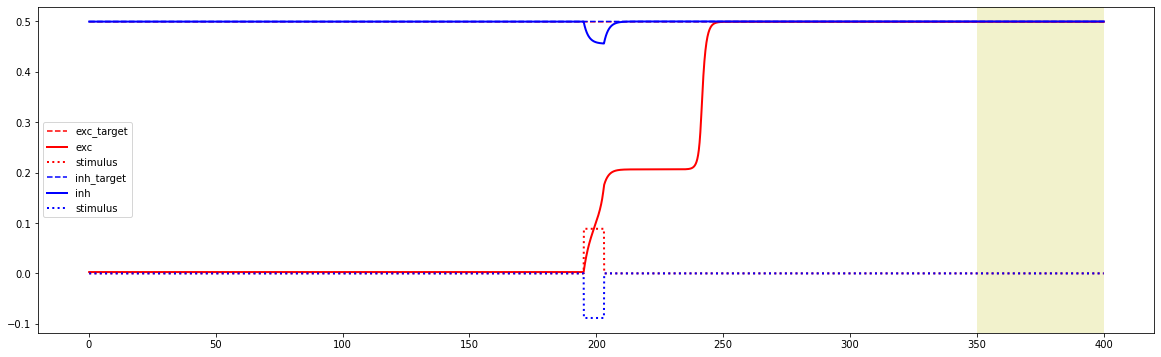

gradient:


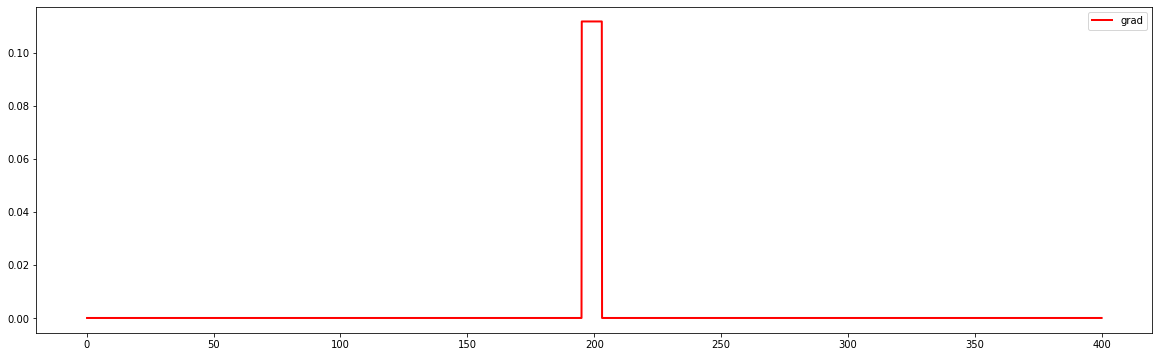

In [11]:
#set of experiments
for a,b in ext_list_full:
    parameters_prep(a, b, 400)

4000
exc_ext, inh_ext 5 8


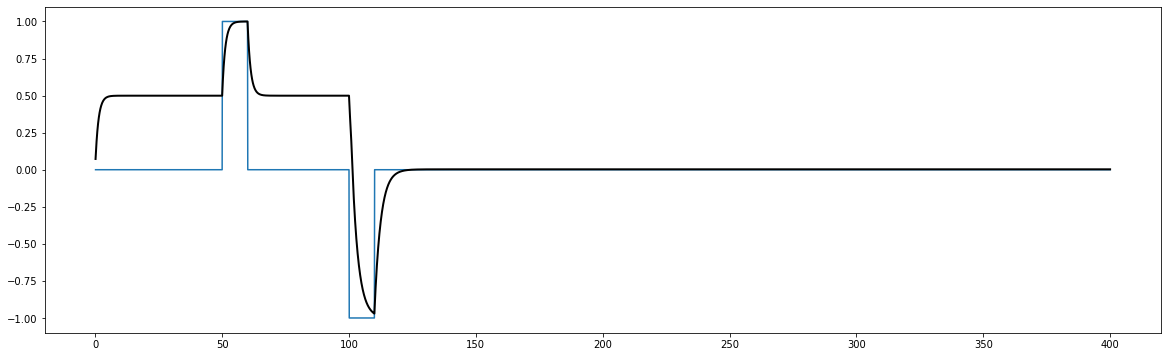

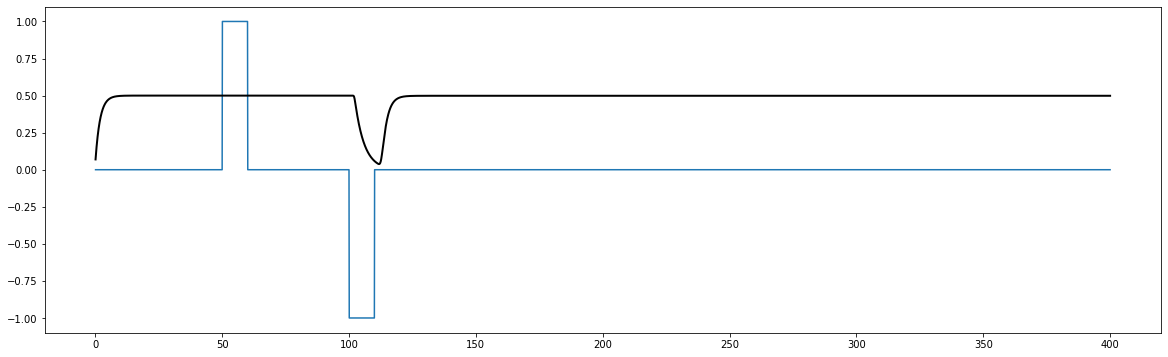

IndexError: index 13000 is out of bounds for axis 0 with size 4000

In [129]:
#one experiment

from scipy import stats

## x-axis for the plot
dt = 0.1
x_data = np.arange(0, 400, dt)
print(len(x_data))
  
## y-axis as the gaussian
y_data = 5*stats.norm.pdf(x_data, 200, 2)
y_data2 = -5*stats.norm.pdf(x_data, 200, 2)
tt = np.zeros((1,len(x_data)))
tt[0] = list(y_data)

tt2 = np.zeros((1,len(x_data)))
tt2[0] = list(y_data2)


parameters_prep(5, 8, 400, dt, tt, tt2)

40000
exc_ext, inh_ext 5 8


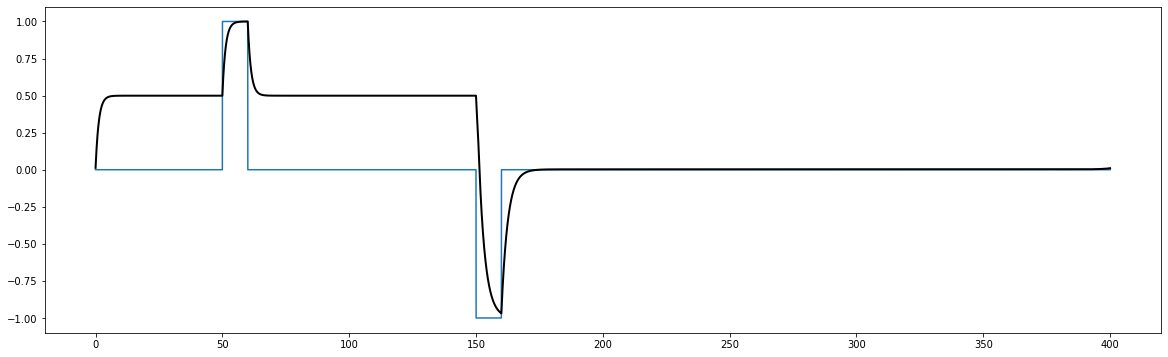

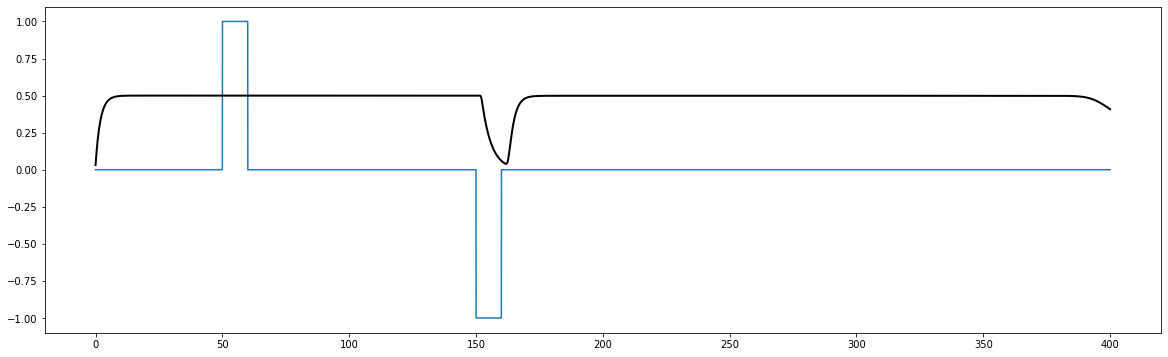

w 1
___
iteration: 0


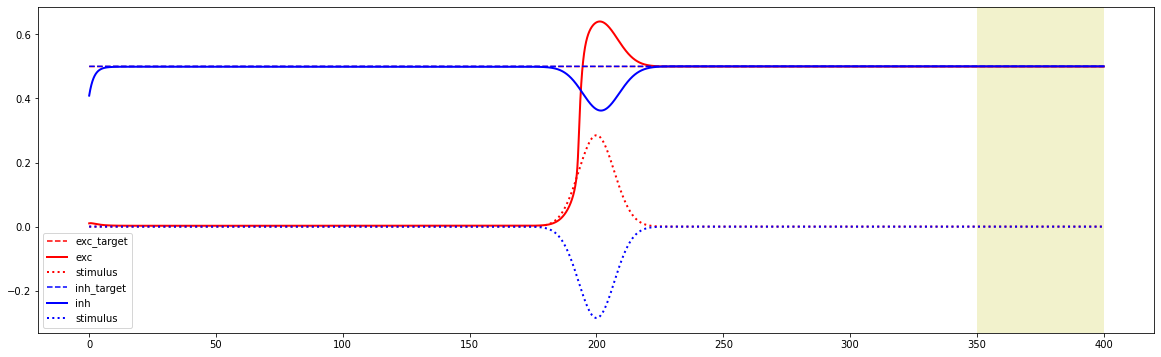

gradient:


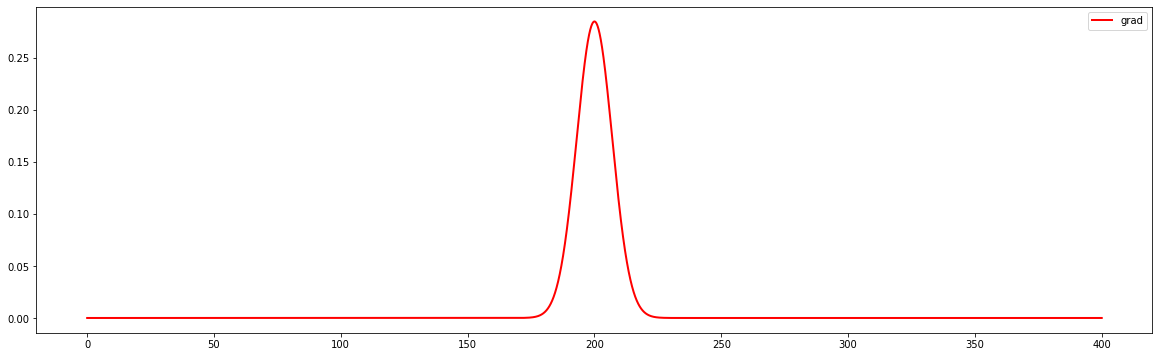

KeyboardInterrupt: 

In [102]:
#one experiment

from scipy import stats

## x-axis for the plot
x_data = np.arange(0, 400, 0.01)
print(len(x_data))
  
## y-axis as the gaussian
y_data = 5*stats.norm.pdf(x_data, 200, 7)
y_data2 = -5*stats.norm.pdf(x_data, 200, 7)
tt = np.zeros((1,40000))
tt[0] = list(y_data)

tt2 = np.zeros((1,40000))
tt2[0] = list(y_data2)


parameters_prep(5, 8, 400, tt, tt2)

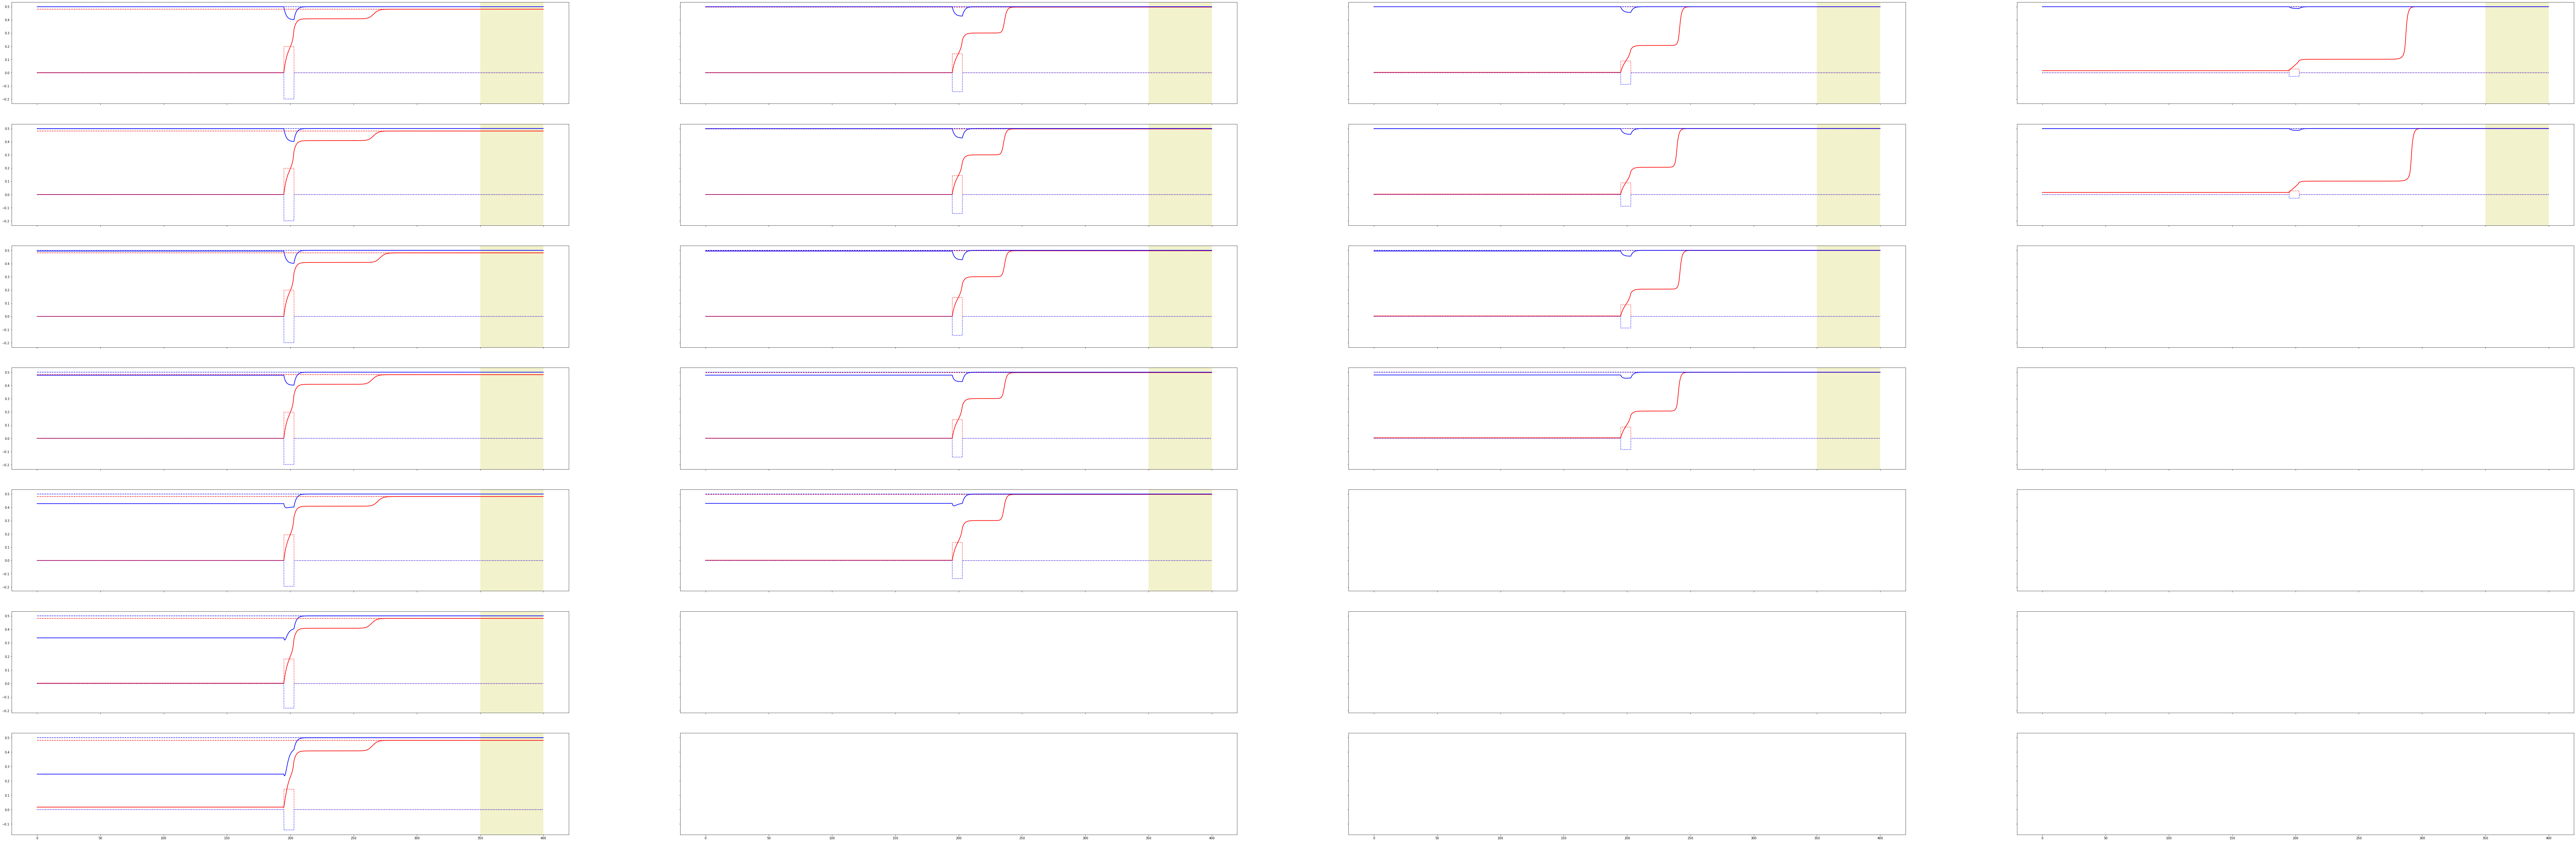

In [12]:
#script for plotting 


filepath = "../400_1_3_5_1_downup_w0i_early/" #path to where experiment data is stored

fig,a =  plt.subplots(7,4,  sharex='col', sharey='row', figsize=(150,50))

for i_i, i in enumerate(np.arange(3,7)):
    for j_j, j in enumerate(np.arange(3,10)):
        try:
            data = np.load(filepath+str(i)+'_'+str(j)+'.npz')
        except FileNotFoundError:
            continue
        
        with np.load(filepath+str(i)+'_'+str(j)+'.npz') as data:
            exc = data['exc']
            target_exc = data['target_exc']
            stimulus_exc = data['stimulus_exc']
            inh = data['inh']
            target_inh = data['target_inh']
            stimulus_inh = data['stimulus_inh']
            t = np.arange(0,400,0.1)

        a[6-j_j][i_i].plot(t, target_exc, '--', c = 'r', label="exc_target")
        a[6-j_j][i_i].plot(t, exc, c='r', lw = 2, label="exc")
        a[6-j_j][i_i].plot(t, stimulus_exc, ':', c='r', lw = 2,label="stimulus")
        a[6-j_j][i_i].axvspan(350, 400, color='y', alpha=0.2, lw=0)

        a[6-j_j][i_i].plot(t, target_inh, '--', c = 'blue',label="inh_target")
        a[6-j_j][i_i].plot(t, inh, c='blue', lw = 2, label="inh")
        a[6-j_j][i_i].plot(t, stimulus_inh, ':', c='blue', lw = 2,label="stimulus")


fig.savefig(filepath + '400_1_3_5_1_downup_w0i_early.png', dpi=fig.dpi)

